In [5]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import h5py
import os
import seaborn as sns

from util import *
from data_loader import * 
# from module_deconv import *
# from module_exp import *
from sc_deconv import *
from fig_gen import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

import scanpy.api as sc
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import pairwise_distances

sc.settings.verbosity = 3                # increase for more output
sc.settings.set_dpi(100)                  # low pixel number yields small inline figures
sc.logging.print_version_and_date()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Running Scanpy 0.4.2 on 2018-03-07 10:59.


In [31]:
data_8k = load_10x_8k()
data_68k = load_10x_68k()

In [32]:
data_8k.X

<8381x33694 sparse matrix of type '<class 'numpy.float32'>'
	with 11788294 stored elements in Compressed Sparse Row format>

In [18]:
## sanity check of dd_moment_anndata
temp = sc.pp.filter_genes(data_8k,min_counts=data_8k.shape[0],copy=True)
M,M_ml,gene_name = dd_moment_anndata(temp,k=4)
print(M[0])
_,_,M_hat,_ = dd_moments_1d(np.array(temp[:,0].X,dtype=int),k=4,gamma=1)
print(M_hat)

[9.01780224e+00 1.07765035e+02 1.69312704e+03 3.48909312e+04]
[9.01789763e+00 1.07763513e+02 1.69316979e+03 3.48924663e+04]


In [12]:
temp

View of AnnData object with n_obs × n_vars = 8381 × 4 
    var_keys = ['n_counts']

In [84]:
## moment calculation with size factor normalization 
temp = sc.pp.filter_genes(data_8k,min_counts=data_8k.shape[0],copy=True)
temp = temp[:,[0,1,2]]
M,M_ml,gene_name = dd_moment_anndata(temp,k=4)
print(M_ml)

[[9.01780224e+00 1.16782837e+02 2.02543994e+03 4.58130664e+04]
 [1.01160288e+00 2.95589828e+00 1.73464508e+01 2.02427933e+02]
 [1.58017838e+00 6.42906141e+00 5.25296478e+01 7.59631165e+02]]


In [83]:
## moment calculation with size factor normalization 
temp = sc.pp.filter_genes(data_8k,min_counts=data_8k.shape[0],copy=True)
temp = temp[:,[0,1,2]]
M,M_ml,gene_name = dd_moment_anndata(temp,k=4,size_norm=False)
print(M_ml)

[[9.01789763e+00 1.16781410e+02 2.02547822e+03 4.58148474e+04]
 [1.01157380e+00 2.95597184e+00 1.73463787e+01 2.02425725e+02]
 [1.58012170e+00 6.42918506e+00 5.25303663e+01 7.59634292e+02]]


In [33]:
temp.X.indptr

array([   0,  254,  525,  868, 1165], dtype=int32)

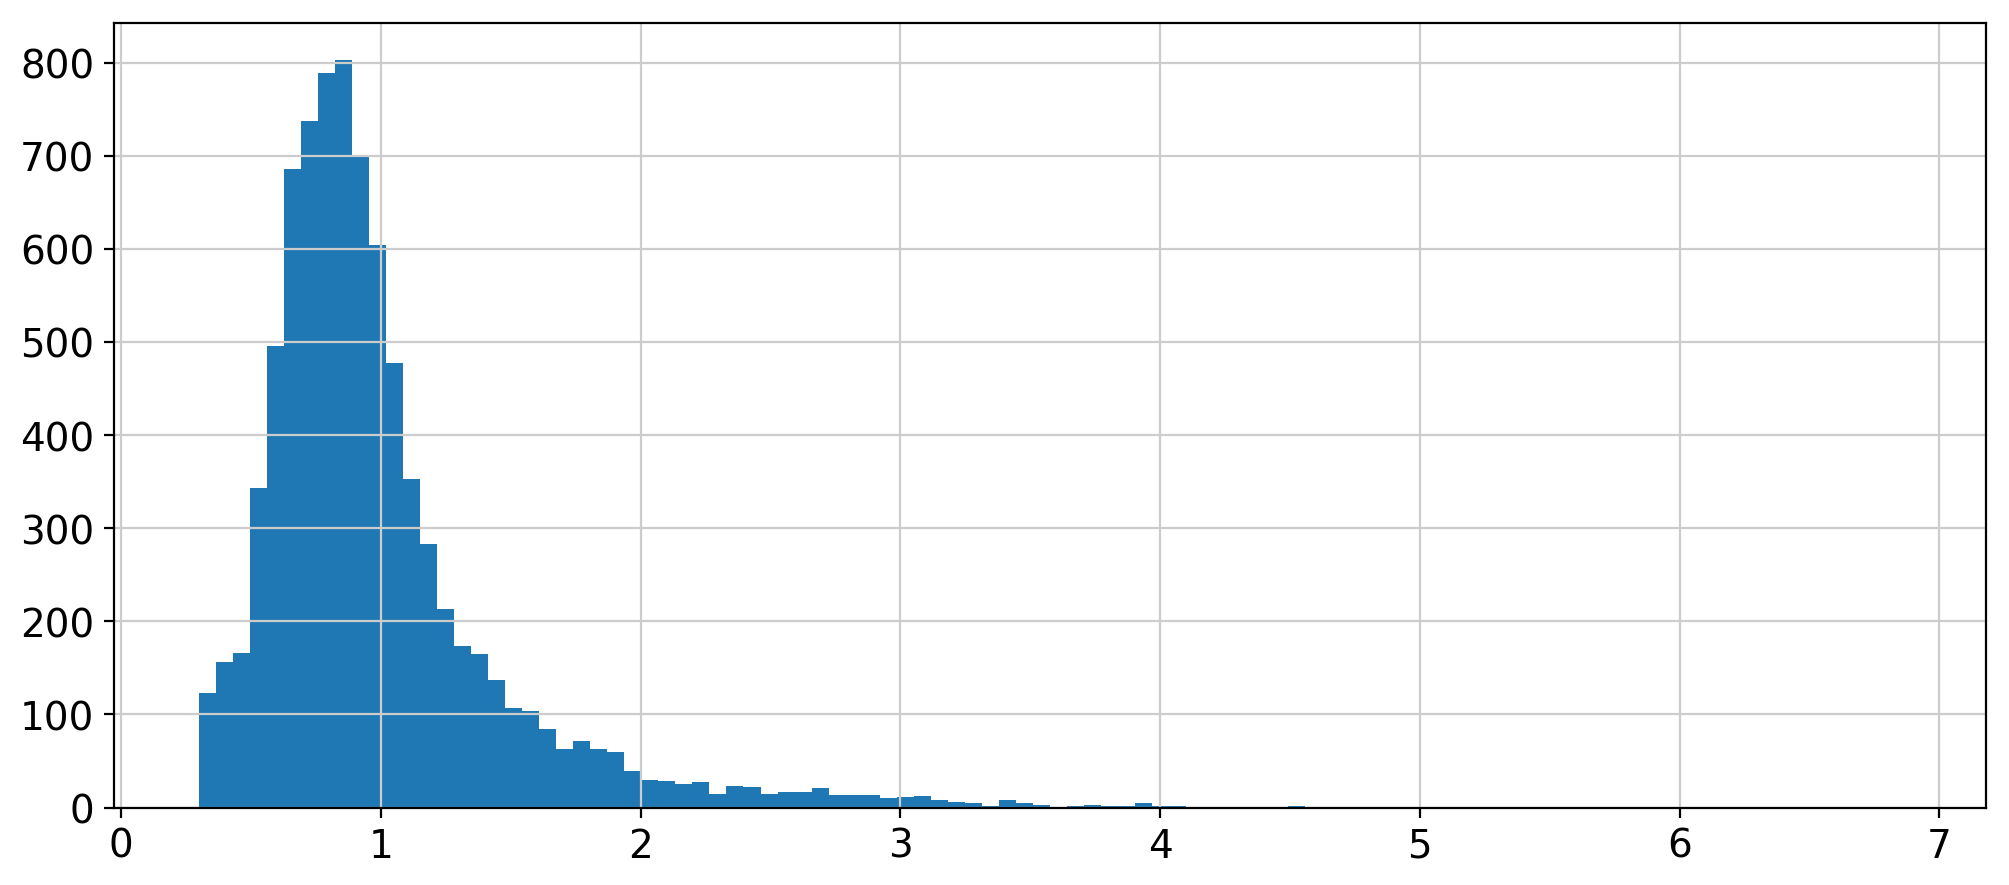

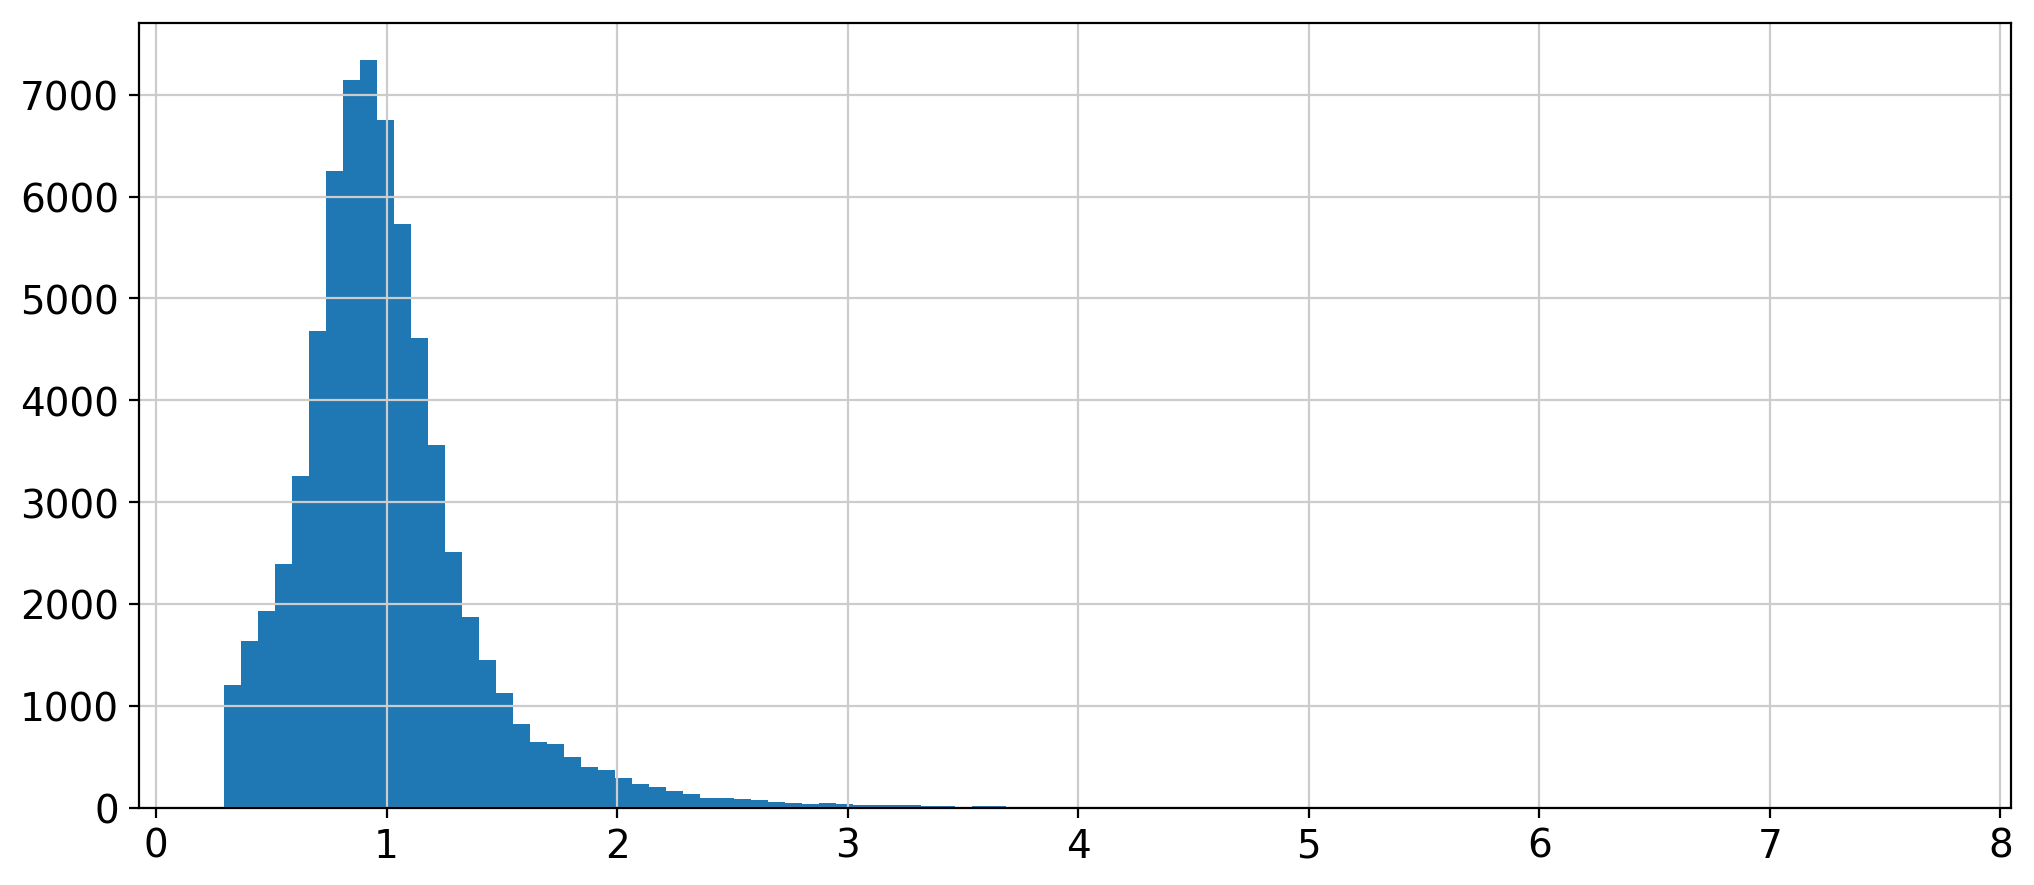

In [3]:
sf_8k = size_factor(data_8k.X.todense(),verbose=True)
sf_68k = size_factor(data_68k.X.todense(),verbose=True)

In [4]:
sf_8k = np.array(sf_8k).flatten()
sf_68k = np.array(sf_68k).flatten()

# sanity check

[ 2.29  4.04  3.6  -2.05 -7.89]
--- ccdf ---
>0.05: 62.26%
>0.1: 57.46%
>0.15: 55.12%
>0.2: 52.98%
>0.25: 50.01%
>0.3: 44.93%
>0.35: 38.28%
>0.4: 23.60%


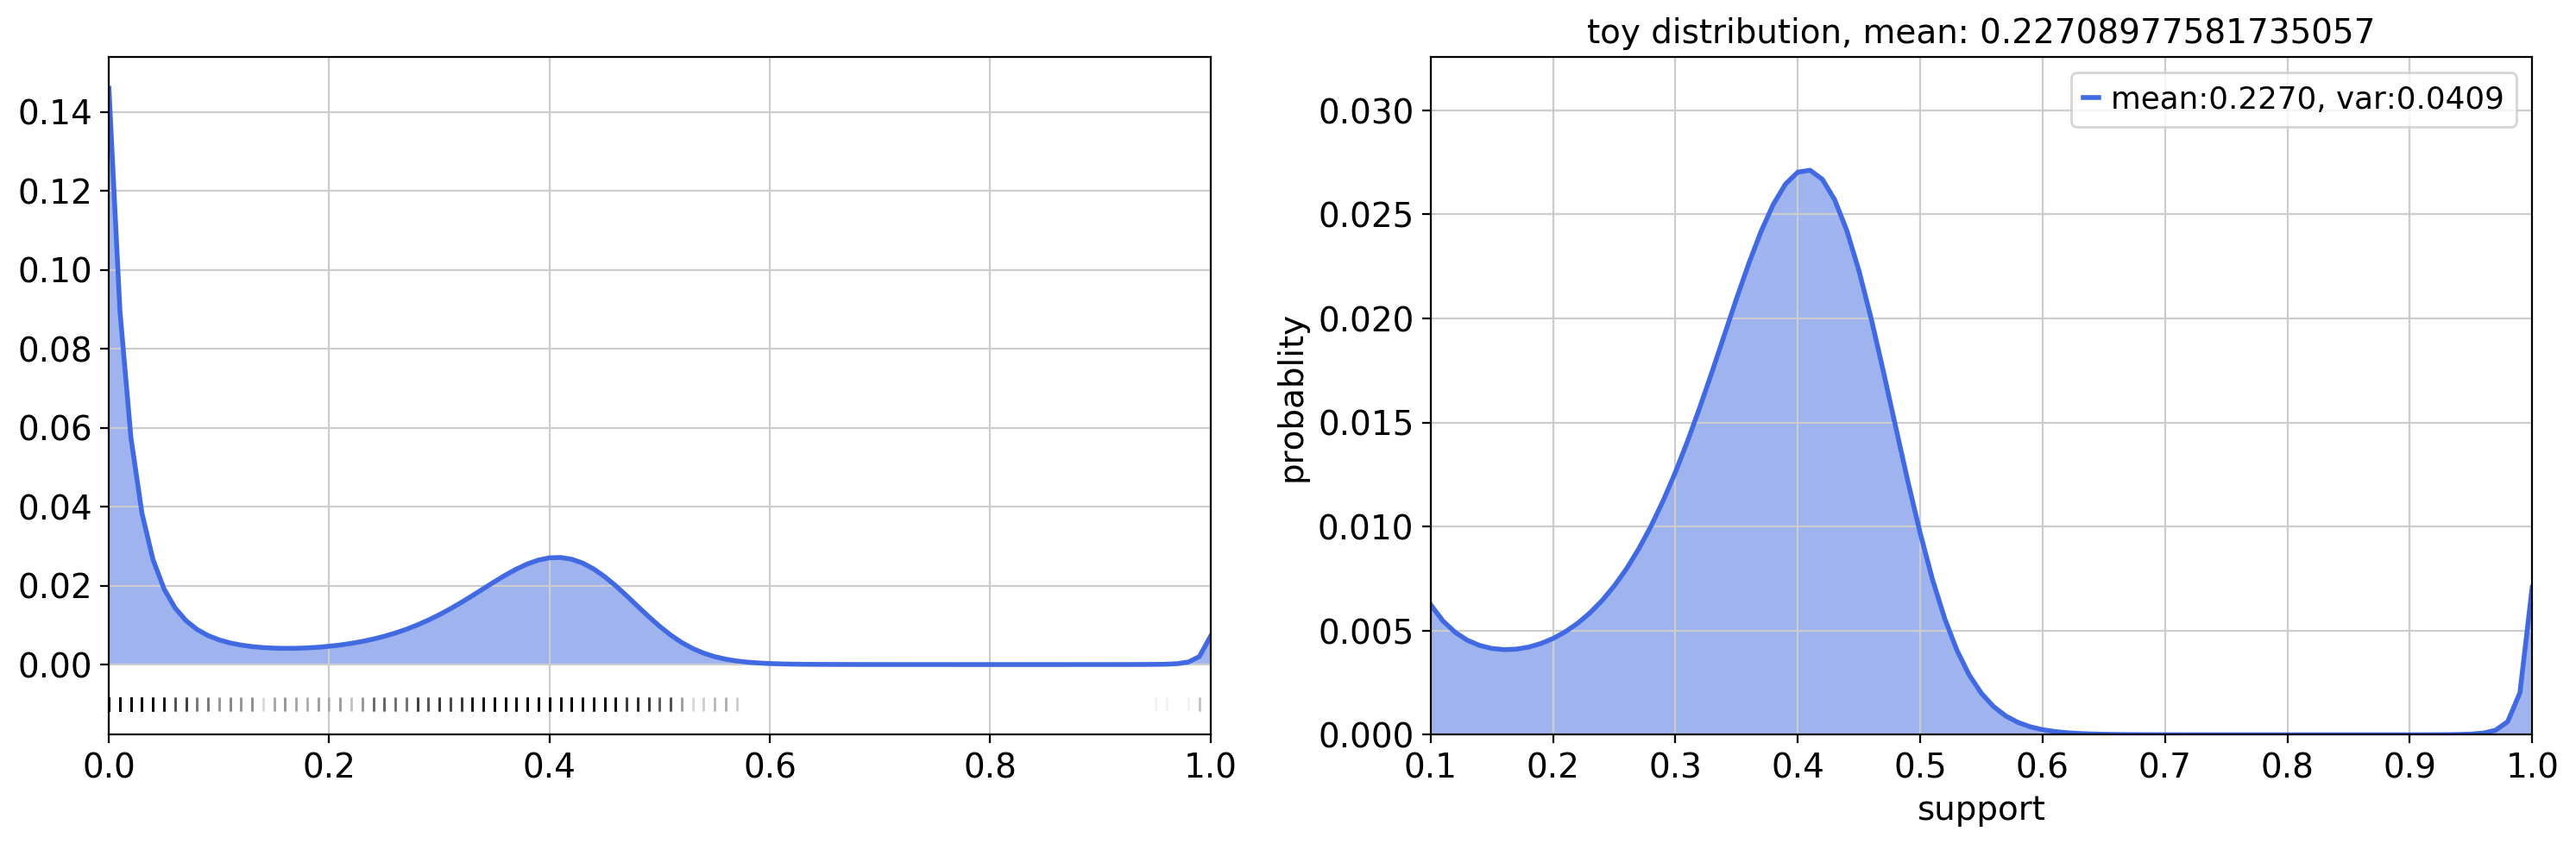

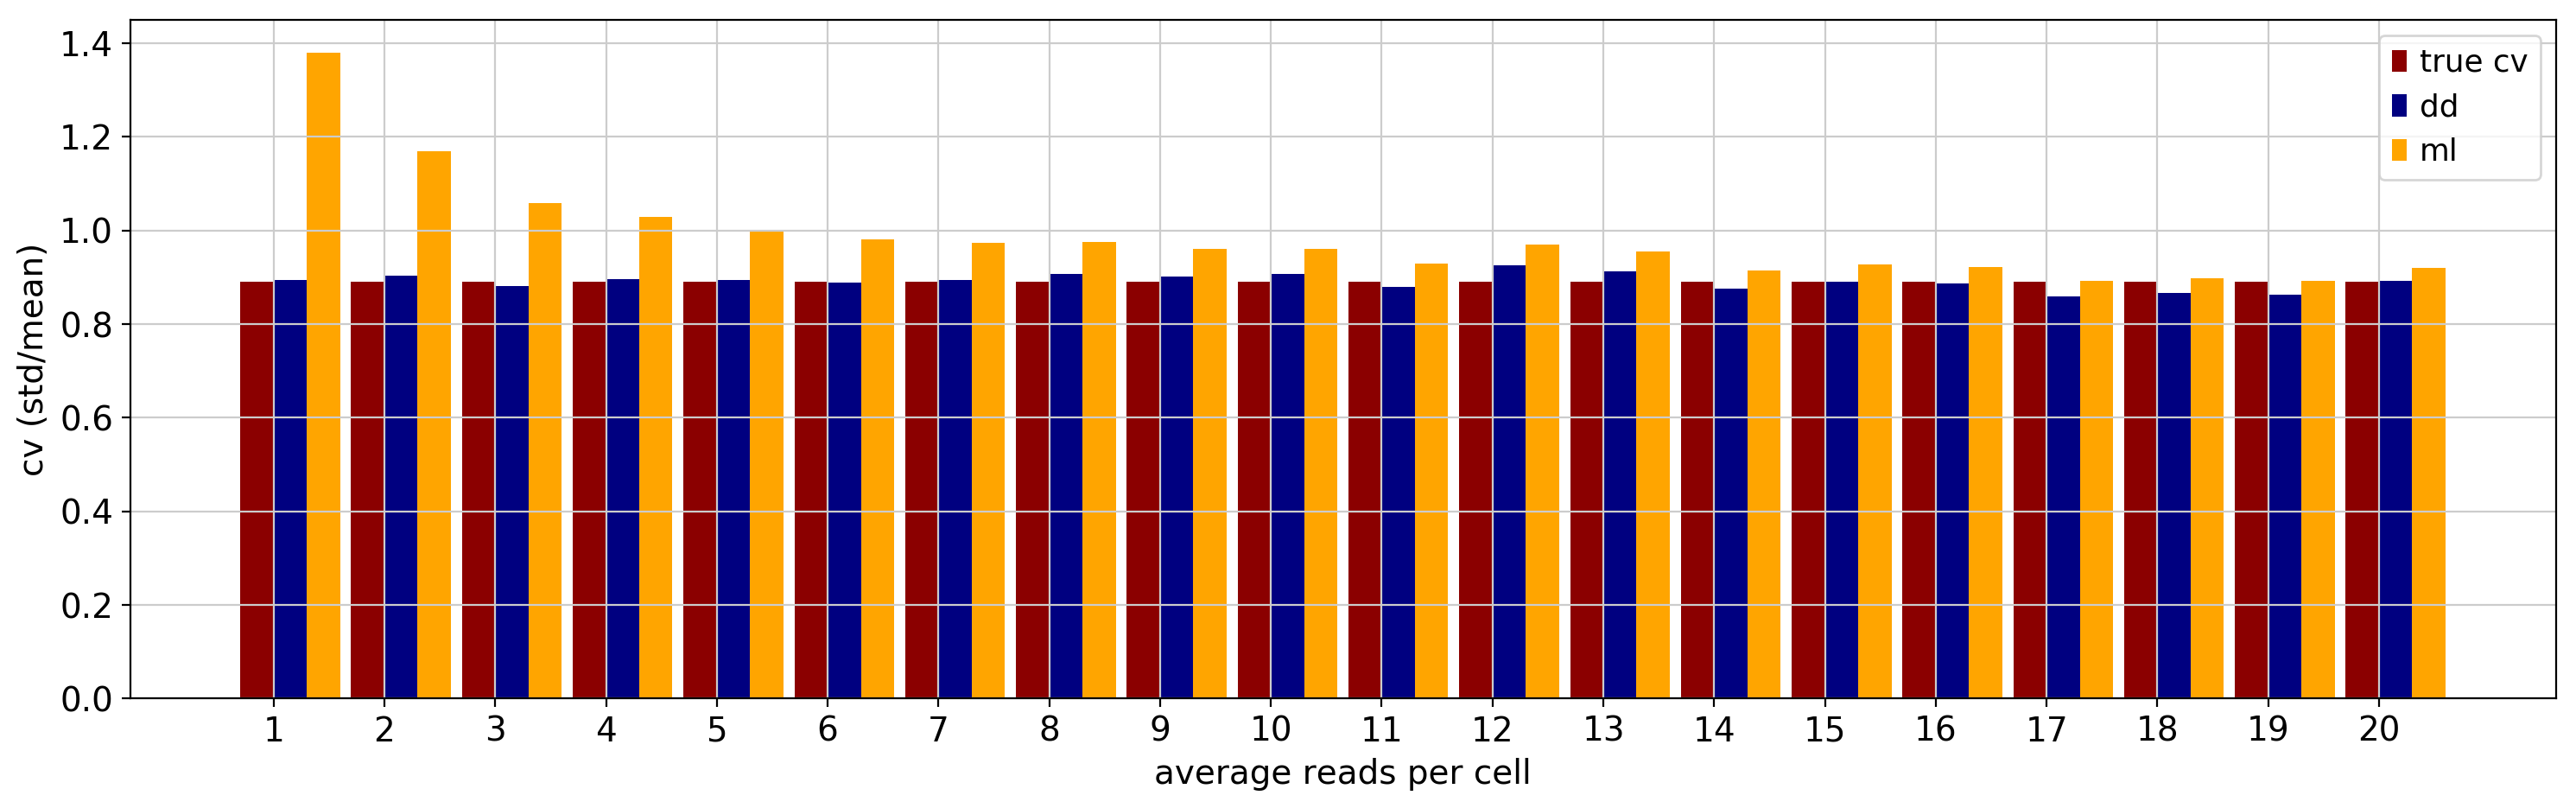

In [5]:
p,x = toy_dist(opt='1d_CD3E',verbose=True)
m_x = p.dot(x)
tot_reads = 2e4
# Nr_list = [1,2,3,5,8,13,21]
Nr_list = list(np.arange(20)+1)
cv = np.zeros([len(Nr_list)])
cv_ml = np.zeros([len(Nr_list)])
true_cv = np.sqrt(p.dot(x**2)-(p.dot(x))**2)/p.dot(x)

for i_nr,Nr in enumerate(Nr_list):
    gamma = int(Nr/m_x)
    N_c = int(tot_reads/Nr)
    x_samp,Y,data_info = data_gen_1d(p,x,N_c,gamma,noise='poi',verbose=False)
    m_,var_,M_,_=dd_moments_1d(Y,gamma=gamma,size_factor=None)
    cv[i_nr] = np.sqrt(var_)/m_ 
    cv_ml[i_nr] = np.std(Y)/np.mean(Y)
    
plt.figure(figsize=[18,5])
plt.bar(np.arange(len(Nr_list))+0.1,np.ones([len(Nr_list)])*true_cv,width=0.3,color='darkred',label='true cv')
plt.bar(np.arange(len(Nr_list))+0.4,cv,width=0.3,color='navy',label='dd')
plt.bar(np.arange(len(Nr_list))+0.7,cv_ml,width=0.3,color='orange',label='ml')
plt.xticks(np.arange(len(Nr_list))+0.25,Nr_list)
plt.xlabel('average reads per cell')
plt.ylabel('cv (std/mean)')
plt.legend()
plt.show()

# some population statistics

In [112]:
data_8k

AnnData object with n_obs × n_vars = 8381 × 429 
    var_keys = ['n_counts']

In [111]:
temp1 = sc.pp.filter_genes(data_8k,min_counts=0.1*data_8k.shape[0],copy=True)
print(temp1.shape)

(8381, 429)


In [104]:
## 8k 
temp = sc.pp.filter_genes(data_8k,min_counts=0.1*data_8k.shape[0],copy=True)
# M_8k,M_ml_8k,gene_list_8k = moment_1d_mp(temp,n_job=8,verbose=True)
M_8k,M_ml_8k,gene_list_8k=dd_moment_anndata(temp,k=2,verbose=True)

#time start: 0.0s
#time total: 2.6676s


In [86]:
## 68k
temp = sc.pp.filter_genes(data_68k,min_counts=0.1*data_68k.shape[0],copy=True)
M_68k,M_ml_68k,gene_list_68k=dd_moment_anndata(temp,k=2,verbose=True)

#time start: 0.0s
#time total: 58.8200s


In [87]:
def basic_cal(M):
    mean_ = M[:,0]
    var_ = (M[:,1]-M[:,0]**2).clip(min=0)
    cv_ = np.sqrt(var_) / mean_
    fano_ = var_/mean_
    return mean_,var_,cv_,fano_

In [105]:
## basic statistics 
mean_8k,var_8k,cv_8k,fano_8k = basic_cal(M_8k)
mean_ml_8k,var_ml_8k,cv_ml_8k,fano_ml_8k = basic_cal(M_ml_8k)
mean_68k,var_68k,cv_68k,fano_68k = basic_cal(M_68k)
mean_ml_68k,var_ml_68k,cv_ml_68k,fano_ml_68k = basic_cal(M_ml_68k)

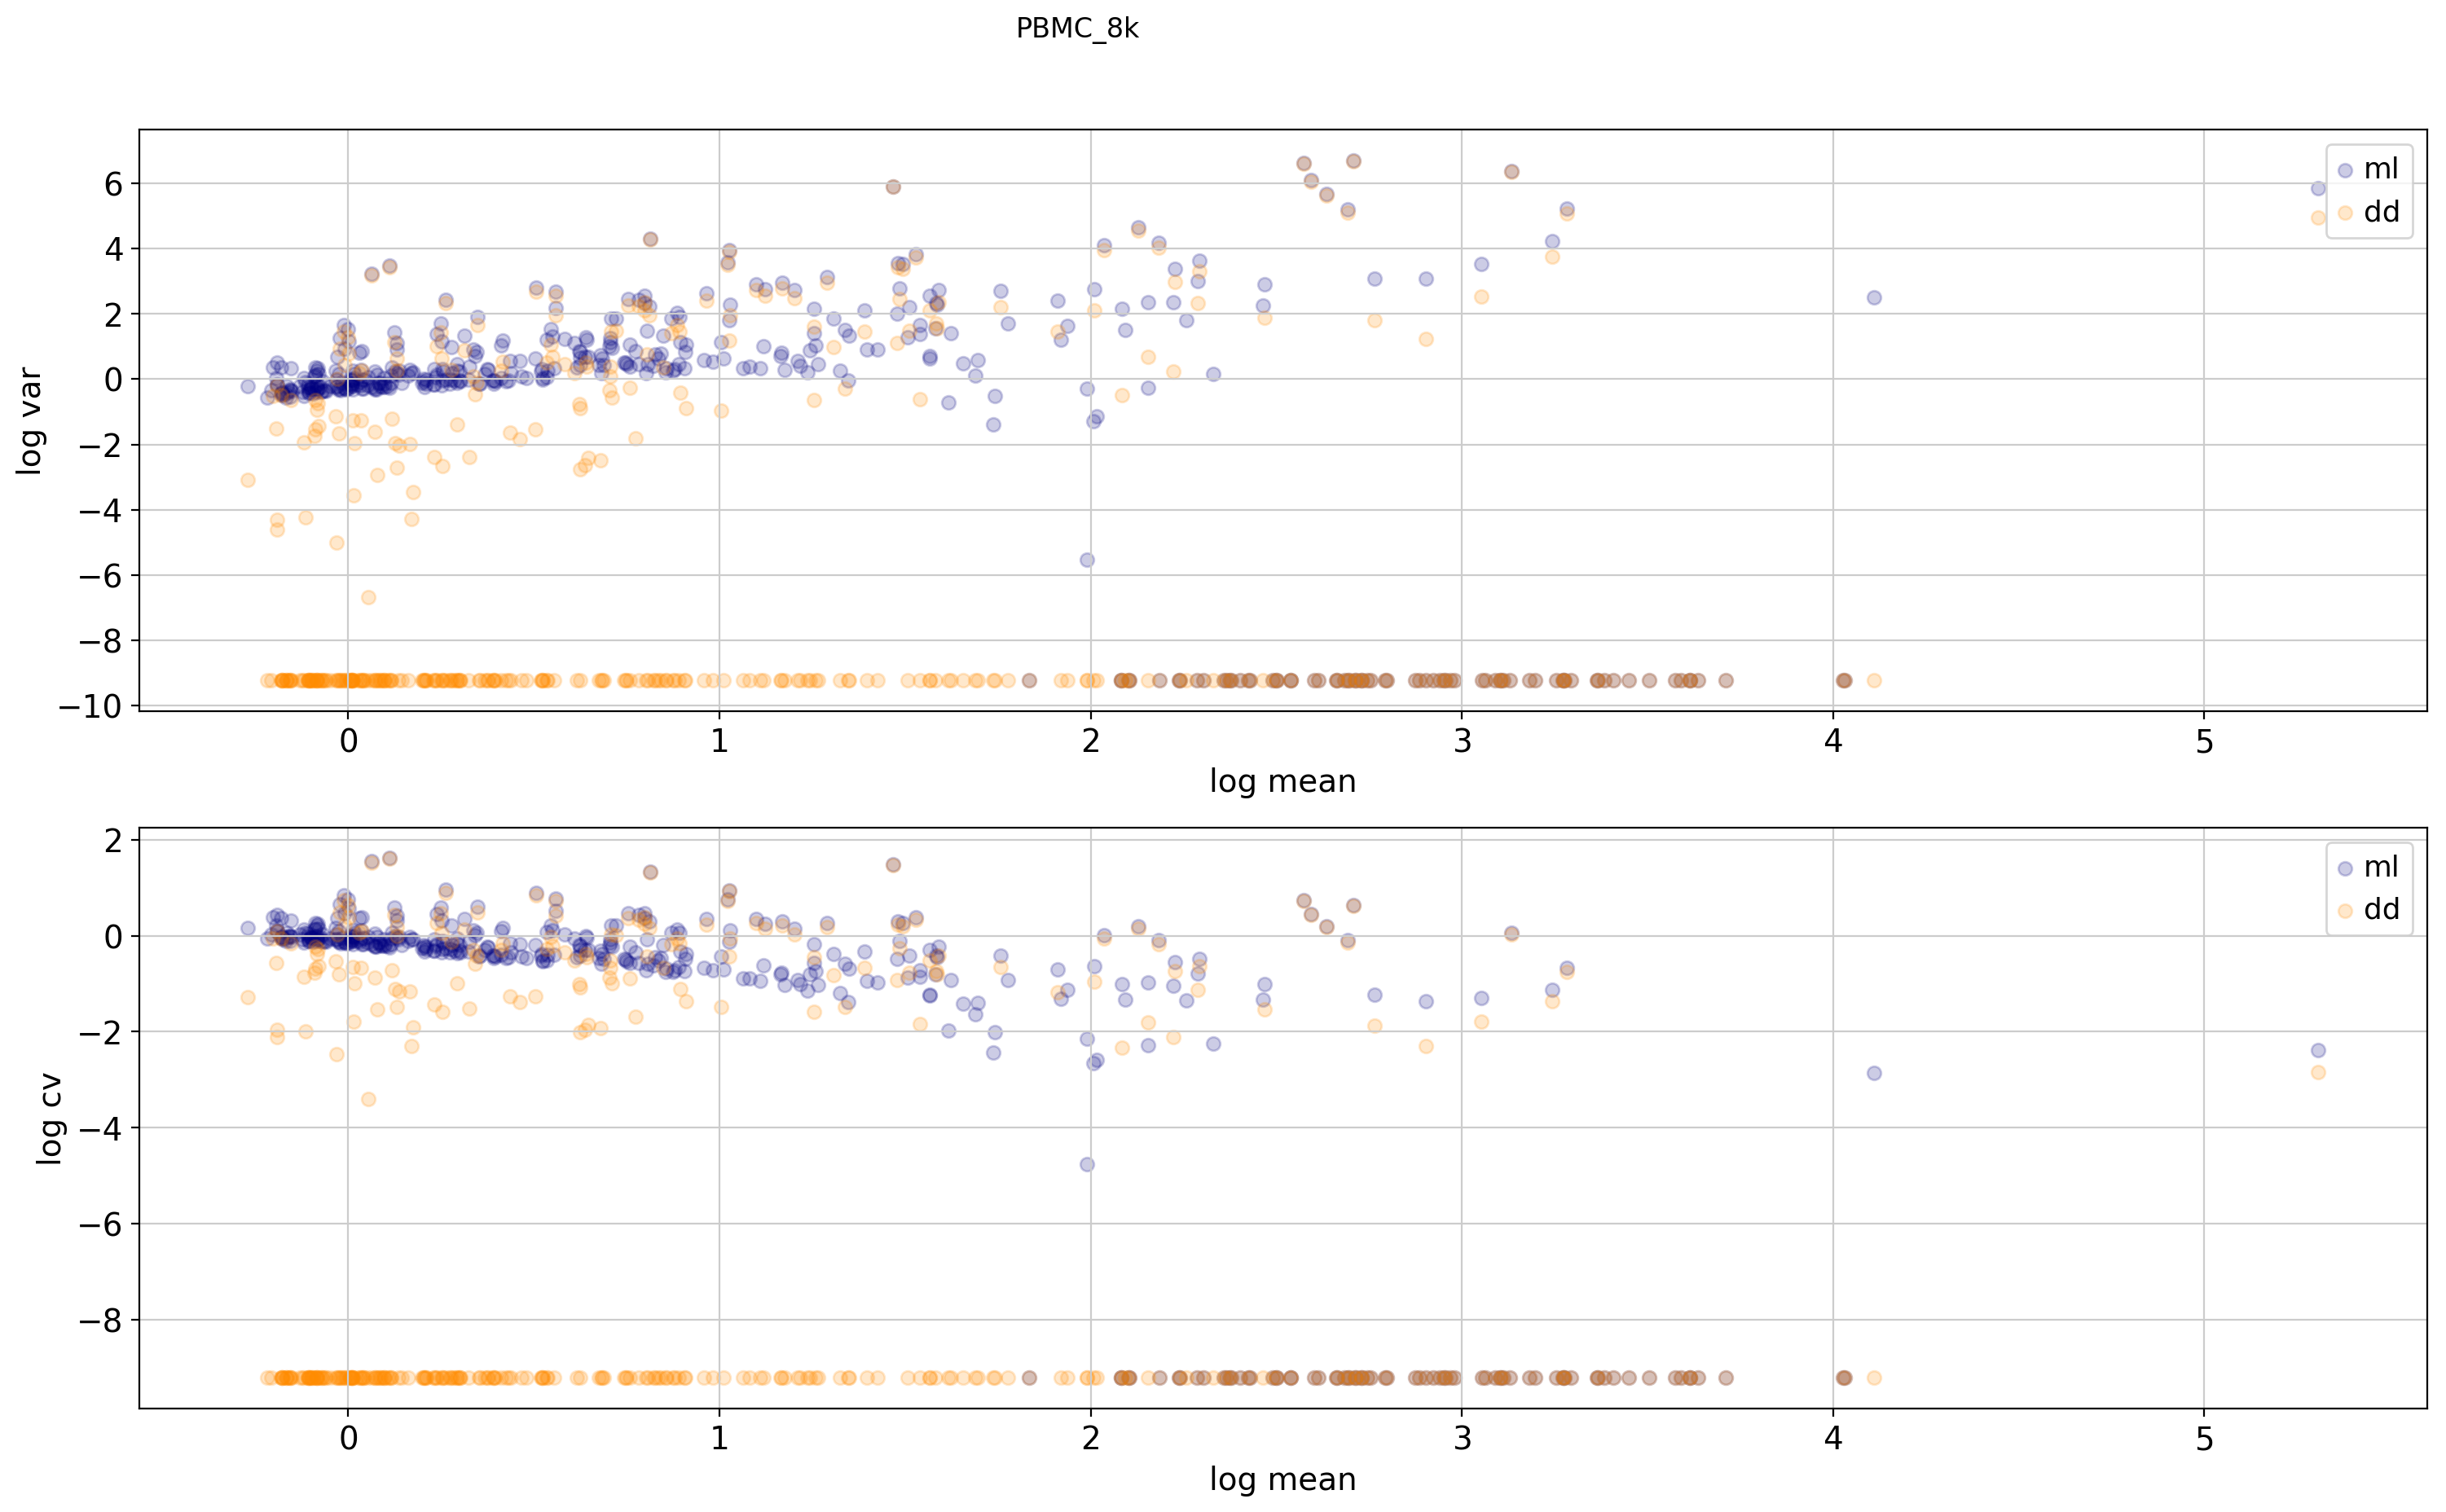

In [89]:
## the scatter plot for both dataset 
plt.figure(figsize=[18,10])
plt.suptitle('PBMC_8k')
plt.subplot(211)
plt.scatter(np.log(mean_ml_8k.clip(min=1e-4)),np.log(var_ml_8k.clip(min=1e-4)),color='navy',alpha=0.2,label='ml')
plt.scatter(np.log(mean_8k.clip(min=1e-4)),np.log(var_8k.clip(min=1e-4)),color='darkorange',alpha=0.2,label='dd')
plt.xlabel('log mean')
plt.ylabel('log var')
plt.legend()
plt.subplot(212)
plt.scatter(np.log(mean_ml_8k.clip(min=1e-4)),np.log(cv_ml_8k.clip(min=1e-4)),color='navy',alpha=0.2,label='ml')
plt.scatter(np.log(mean_8k.clip(min=1e-4)),np.log(cv_8k.clip(min=1e-4)),color='darkorange',alpha=0.2,label='dd')
plt.xlabel('log mean')
plt.ylabel('log cv')
plt.legend()
plt.show()

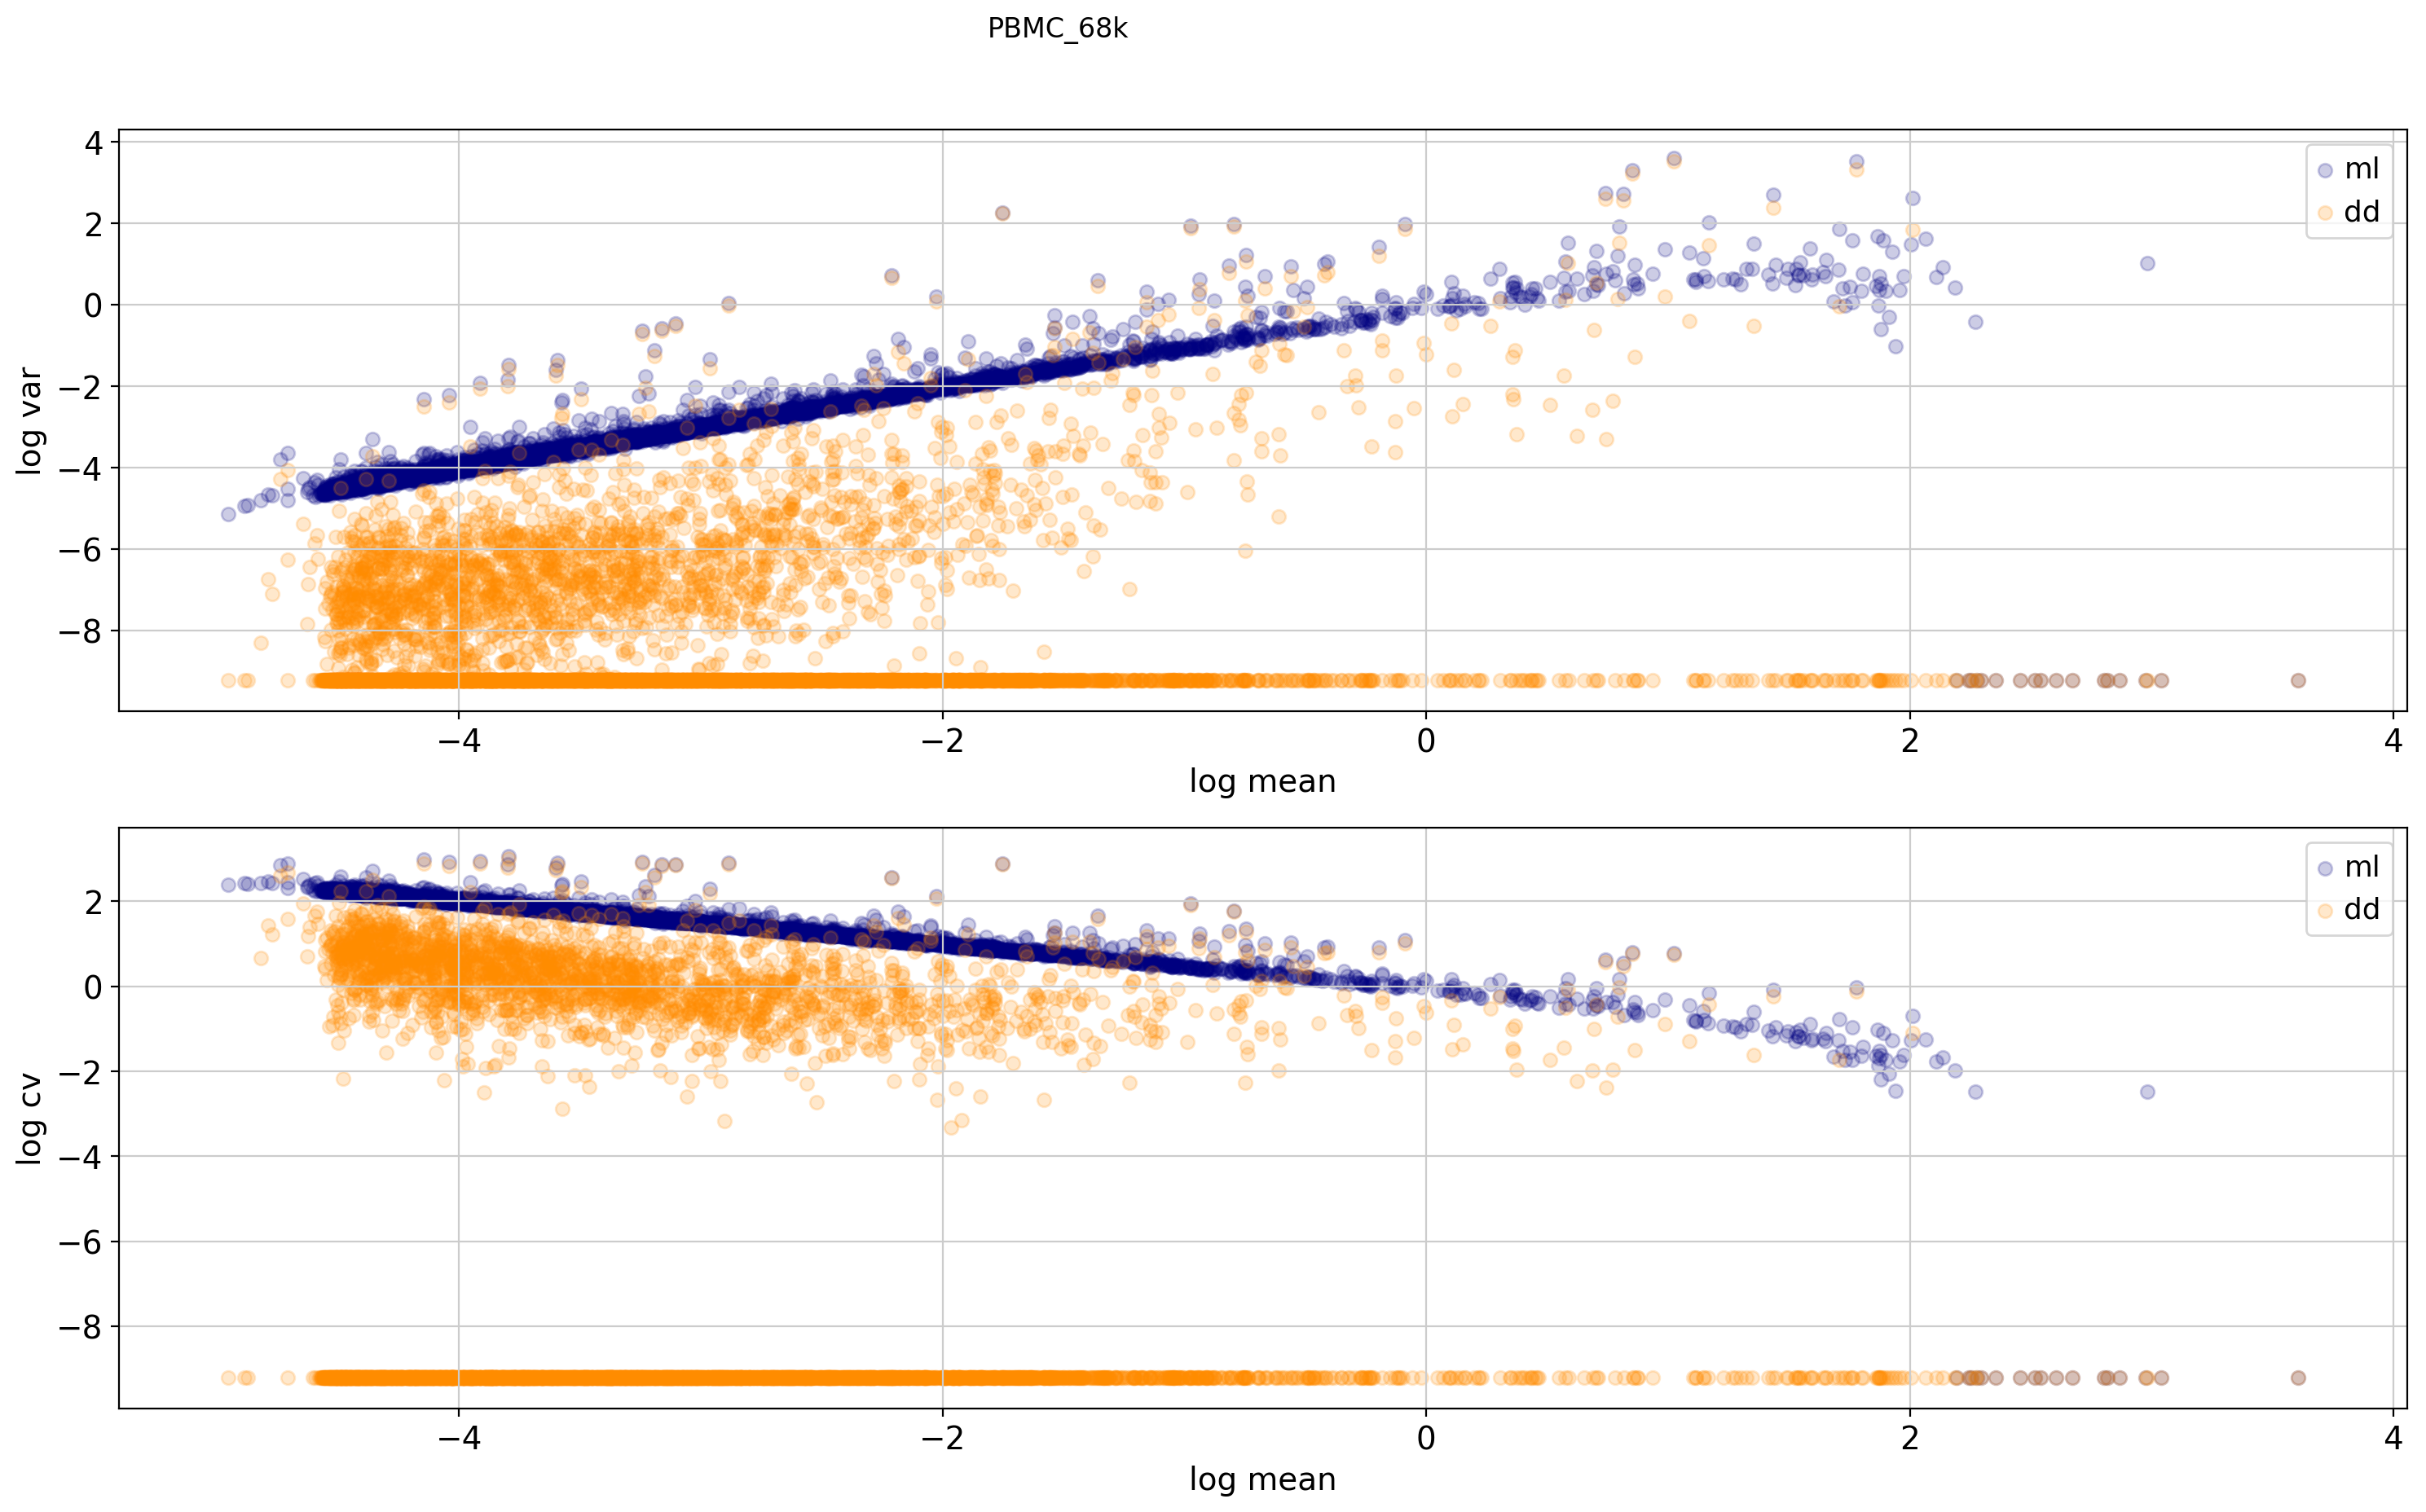

In [90]:
## the scatter plot for both dataset 
plt.figure(figsize=[18,10])
plt.suptitle('PBMC_68k')
plt.subplot(211)
plt.scatter(np.log(mean_ml_68k.clip(min=1e-4)),np.log(var_ml_68k.clip(min=1e-4)),color='navy',alpha=0.2,label='ml')
plt.scatter(np.log(mean_68k.clip(min=1e-4)),np.log(var_68k.clip(min=1e-4)),color='darkorange',alpha=0.2,label='dd')
plt.xlabel('log mean')
plt.ylabel('log var')
plt.legend()
plt.subplot(212)
plt.scatter(np.log(mean_ml_68k.clip(min=1e-4)),np.log(cv_ml_68k.clip(min=1e-4)),color='navy',alpha=0.2,label='ml')
plt.scatter(np.log(mean_68k.clip(min=1e-4)),np.log(cv_68k.clip(min=1e-4)),color='darkorange',alpha=0.2,label='dd')
plt.xlabel('log mean')
plt.ylabel('log cv')
plt.legend()
plt.show()

In [91]:
## consistency 
common_gene = set(gene_list_8k) & set(gene_list_68k)
idx_8k = np.zeros([len(common_gene)],dtype=int)
idx_68k = np.zeros([len(common_gene)],dtype=int)
for idx,gene in enumerate(common_gene):
    idx_8k[idx] = gene_list_8k.index(gene)    
    idx_68k[idx] = gene_list_68k.index(gene)

In [110]:
len(gene_list_8k)

429

ml 13
dd 80


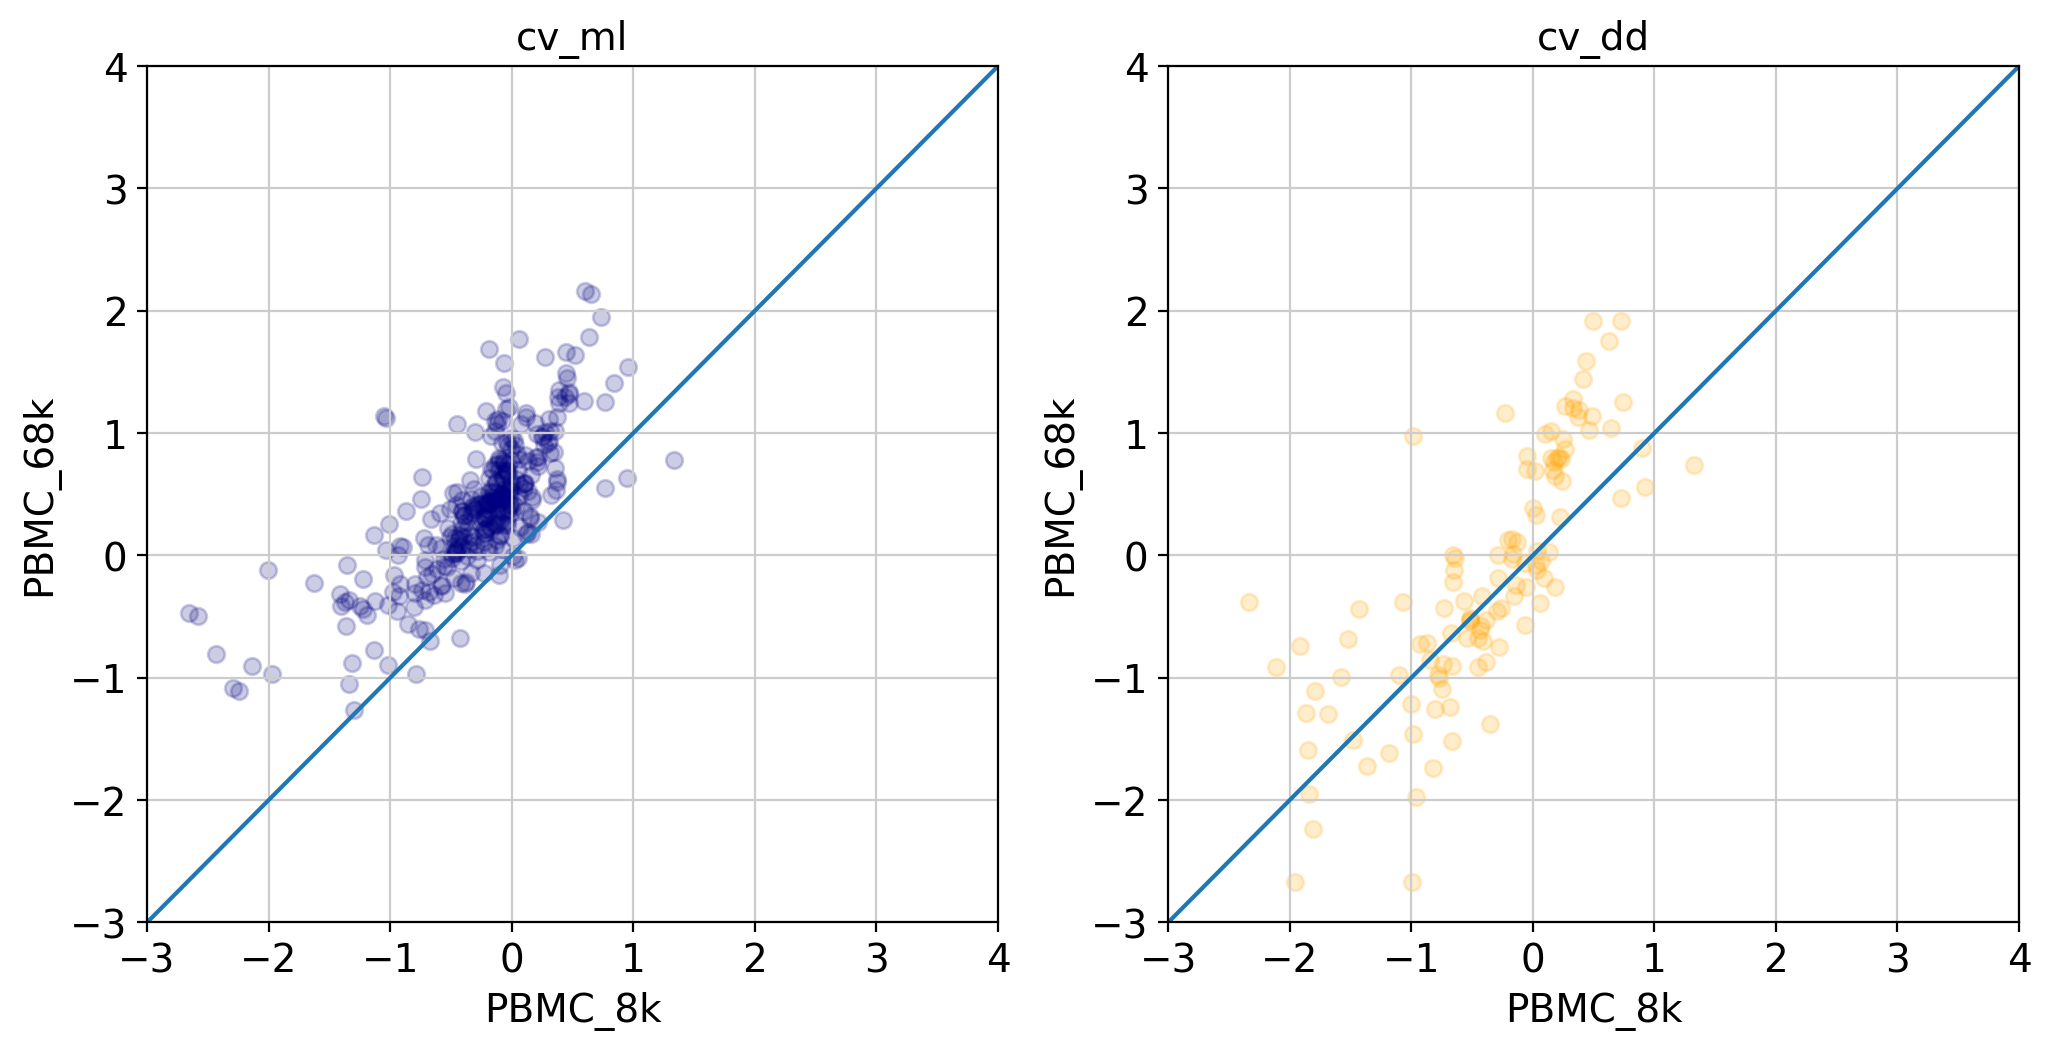

In [92]:
plt.figure(figsize=[12,12])
plt.subplot(221)
plt.scatter(np.log(cv_ml_8k[idx_8k].clip(min=1e-4)),np.log(cv_ml_68k[idx_68k].clip(min=1e-4)),color='navy',alpha=0.2)
plt.plot([-3,4],[-3,4])
plt.xlim([-3,4])
plt.ylim([-3,4])
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
print('ml',np.sum(cv_ml_8k[idx_8k]>cv_ml_68k[idx_68k]))
plt.title('cv_ml')
plt.subplot(222)
plt.scatter(np.log(cv_8k[idx_8k].clip(min=1e-4)),np.log(cv_68k[idx_68k].clip(min=1e-4)),color='orange',alpha=0.2)
plt.plot([-3,4],[-3,4])
plt.xlim([-3,4])
plt.ylim([-3,4])
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
print('dd',np.sum(cv_8k[idx_8k]>cv_68k[idx_68k]))
plt.title('cv_dd')
plt.show()

In [93]:
## ranking 
rank_cv_68k = rank(cv_68k[idx_68k])
rank_cv_8k = rank(cv_8k[idx_8k])
rank_cv_ml_68k = rank(cv_ml_68k[idx_68k])
rank_cv_ml_8k = rank(cv_ml_8k[idx_8k])
rank_fano_68k = rank(fano_68k[idx_68k])
rank_fano_8k = rank(fano_8k[idx_8k])
rank_fano_ml_68k = rank(fano_ml_68k[idx_68k])
rank_fano_ml_8k = rank(fano_ml_8k[idx_8k])

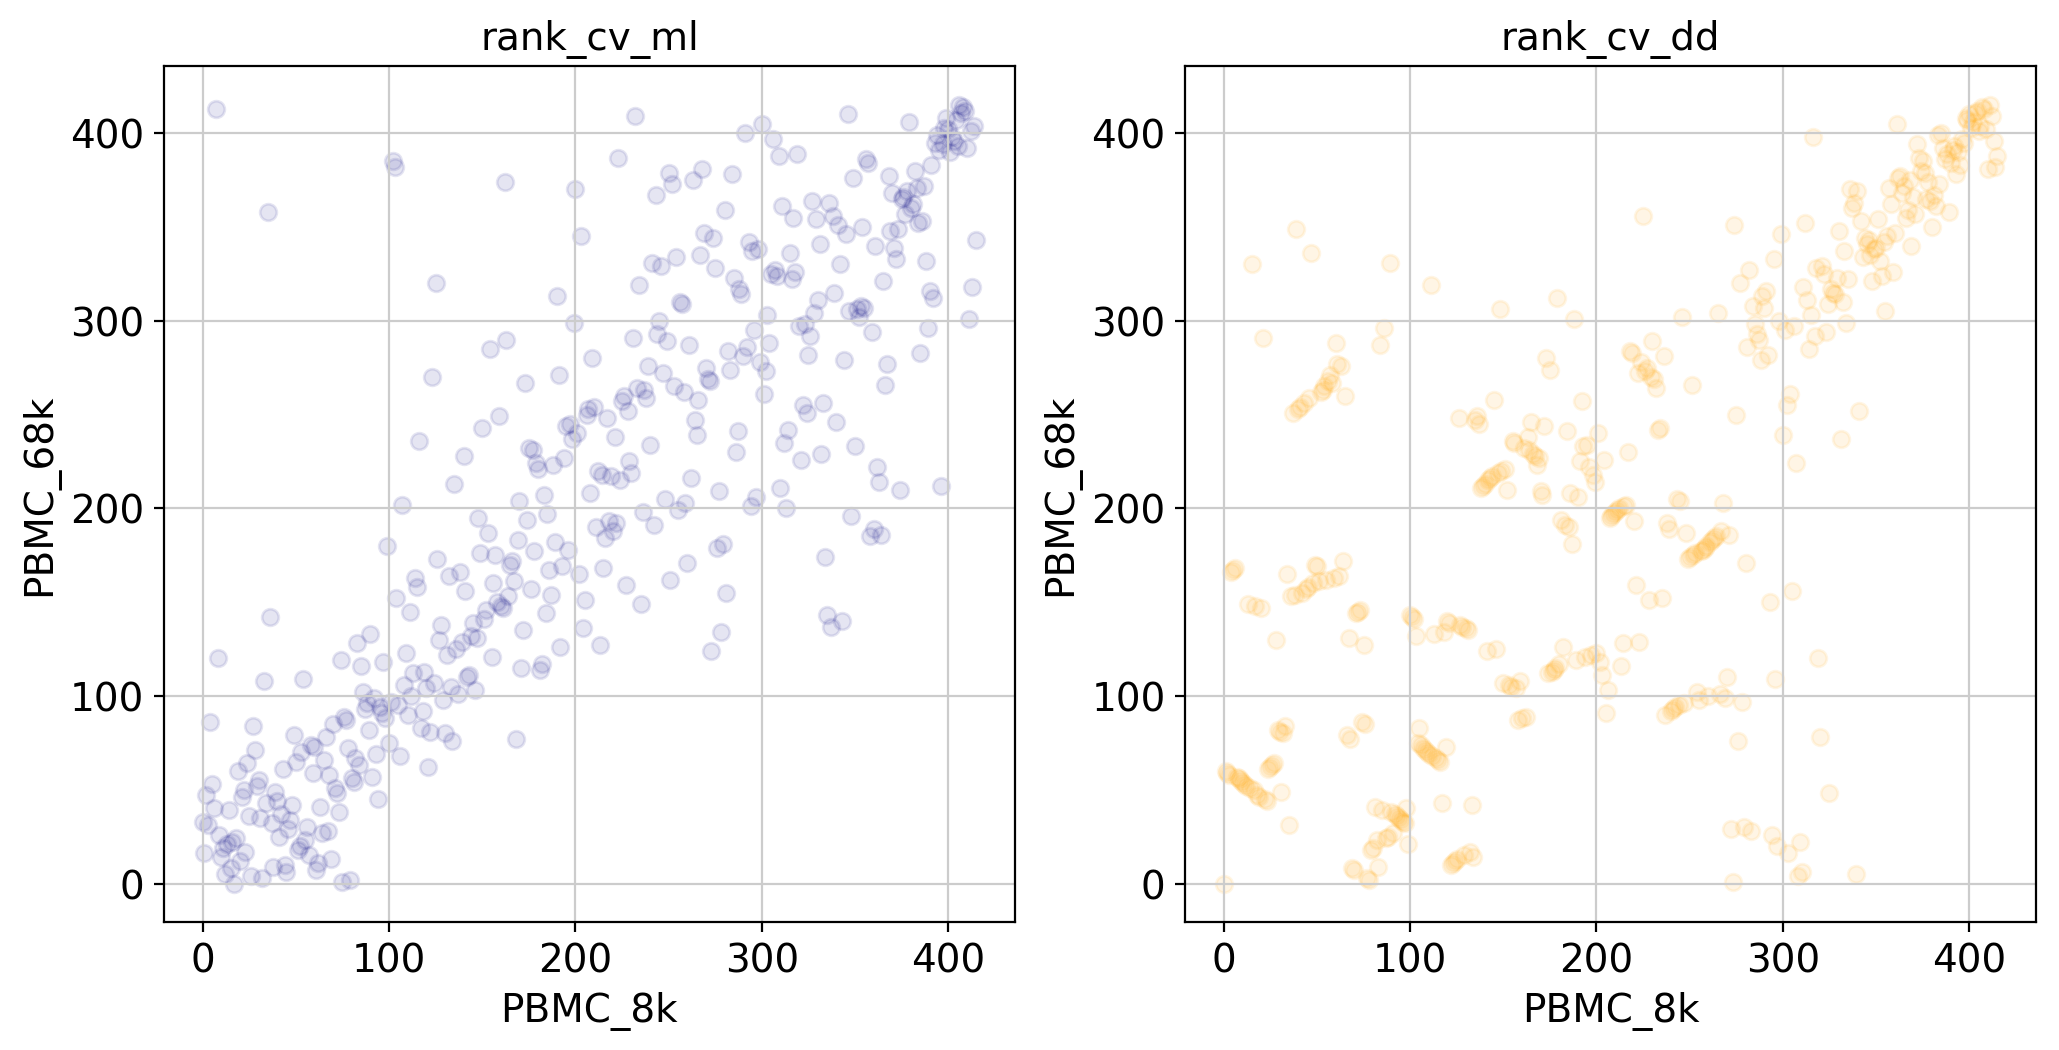

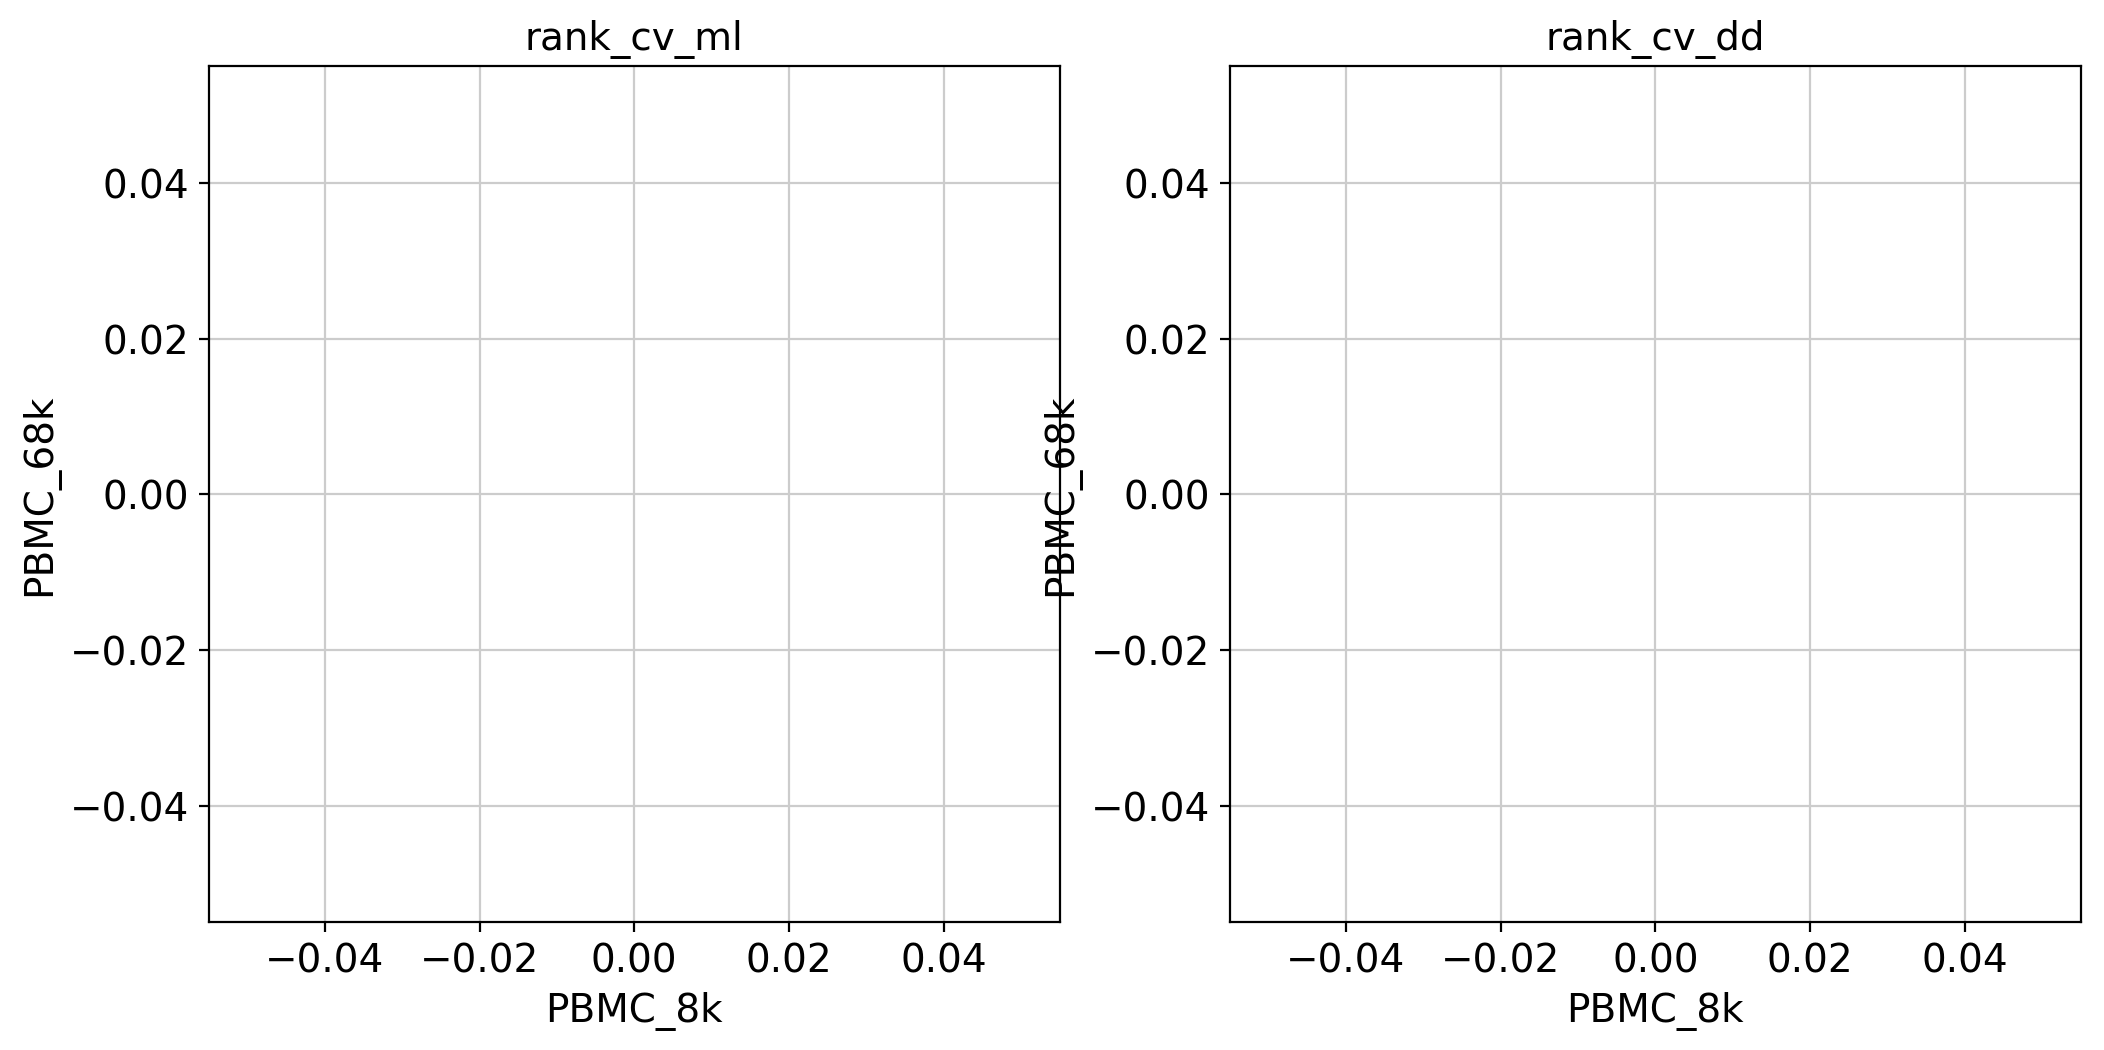

In [94]:
plt.figure(figsize=[12,12])
plt.subplot(221)
plt.scatter(rank_cv_ml_8k,rank_cv_ml_68k,color='navy',alpha=0.1)
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
plt.title('rank_cv_ml')
plt.subplot(222)
plt.scatter(rank_cv_8k,rank_cv_68k,color='orange',alpha=0.1)
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
plt.title('rank_cv_dd')
plt.show()

idx_cv = (rank_cv_8k>8000)&(rank_cv_68k>8000)
idx_cv_ml = (rank_cv_ml_8k>8000)&(rank_cv_ml_68k>8000)
plt.figure(figsize=[12,12])
plt.subplot(221)
plt.scatter(rank_cv_ml_8k[idx_cv_ml],rank_cv_ml_68k[idx_cv_ml],color='navy',alpha=0.4)
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
plt.title('rank_cv_ml')
plt.subplot(222)
plt.scatter(rank_cv_8k[idx_cv],rank_cv_68k[idx_cv],color='orange',alpha=0.4)
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
plt.title('rank_cv_dd')
plt.show()

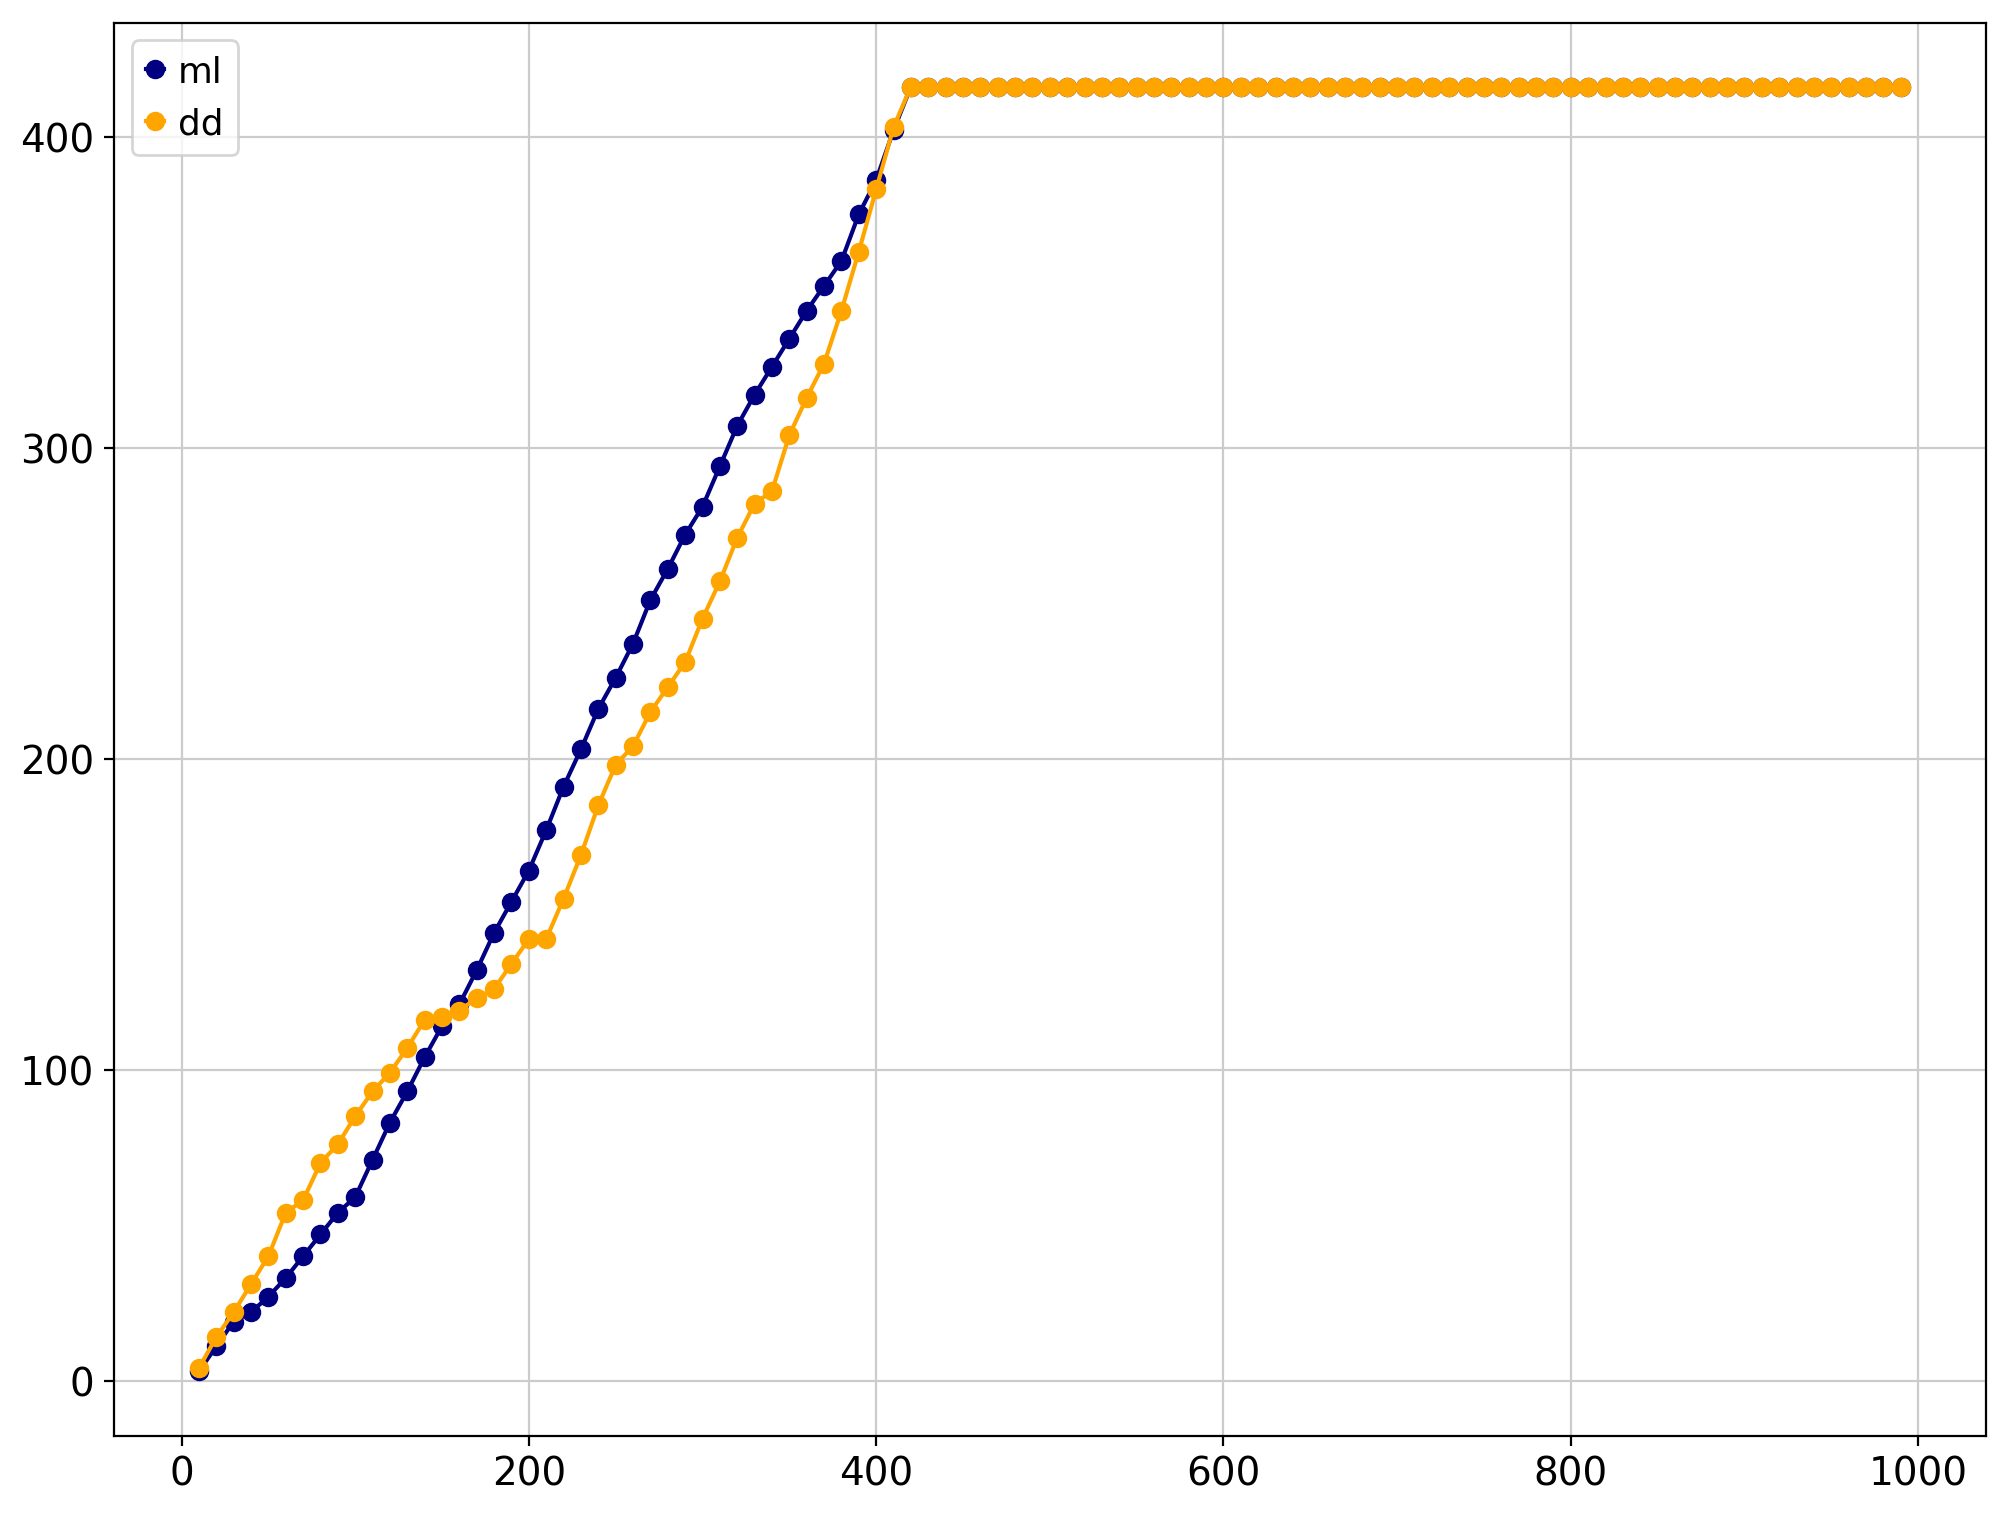

In [95]:
topk = np.arange(10,1000,10) 
overlap=np.zeros([topk.shape[0]])
overlap_ml = np.zeros([topk.shape[0]])
for i,ik in enumerate(topk):
    overlap[i]=((rank_cv_8k>rank_cv_8k.shape[0]-ik)&(rank_cv_68k>rank_cv_8k.shape[0]-ik)).sum()
    overlap_ml[i] = ((rank_cv_ml_8k>rank_cv_8k.shape[0]-ik)&(rank_cv_ml_68k>rank_cv_8k.shape[0]-ik)).sum()
    
plt.figure(figsize=[12,9])
plt.plot(topk,overlap_ml,marker='o',color='navy',label='ml')
plt.plot(topk,overlap,marker='o',color='orange',label='dd')
plt.legend()
plt.show()

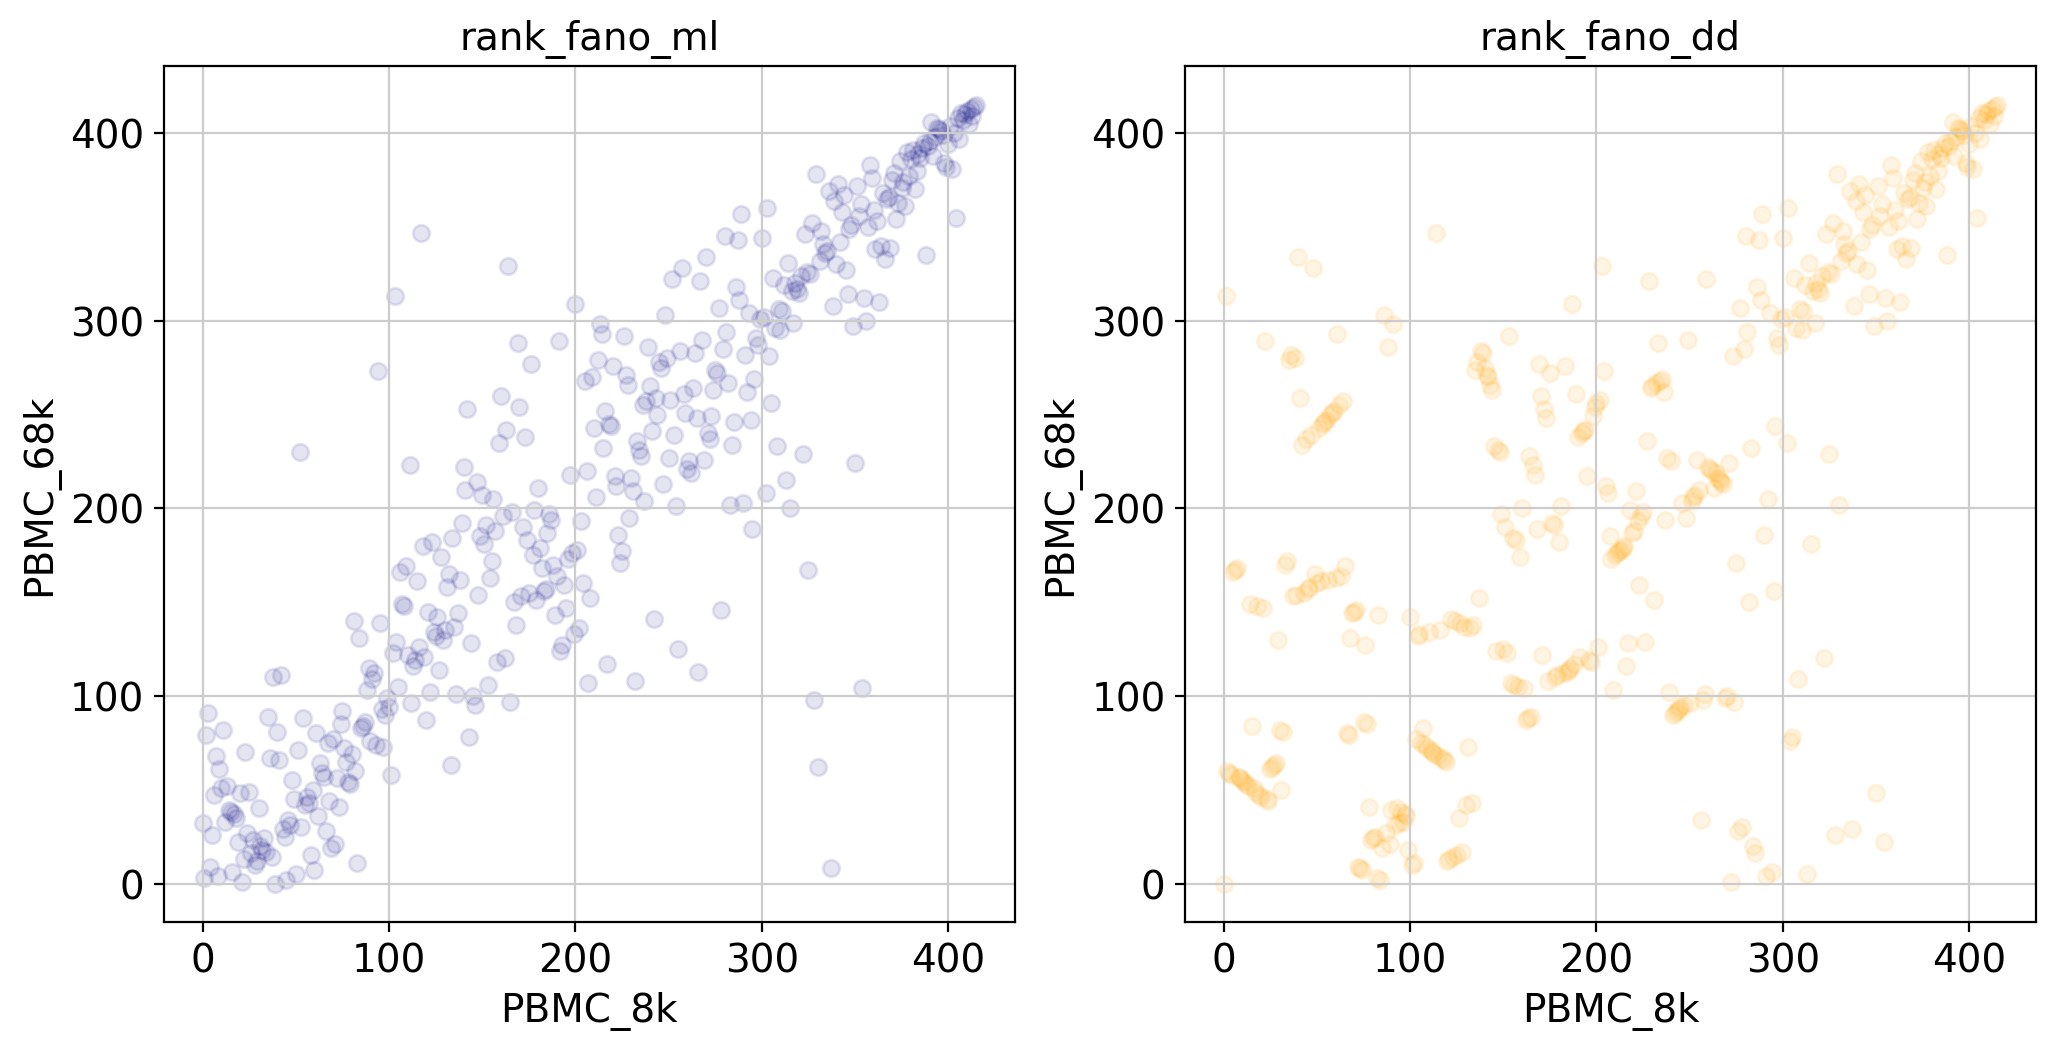

In [96]:
plt.figure(figsize=[12,12])
plt.subplot(221)
plt.scatter(rank_fano_ml_8k,rank_fano_ml_68k,color='navy',alpha=0.1)
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
plt.title('rank_fano_ml')
plt.subplot(222)
plt.scatter(rank_fano_8k,rank_fano_68k,color='orange',alpha=0.1)
plt.xlabel('PBMC_8k')
plt.ylabel('PBMC_68k')
plt.title('rank_fano_dd')
plt.show()

In [191]:
## MSE bound 
def bound_MSE(M,alpha,verbose=False,color='orange',label=None):
    M1,M2,M3,M4 = M[:,0],M[:,1],M[:,2],M[:,3]
    G = M1.shape[0]
    M2 = M2.clip(min=1e-9)
    var_x2 = M4 - M2**2    
    MSE = alpha * var_x2 + 4*M3/G + 2*M2/G**2/alpha
    #MSE = MSE / M2**2
    if verbose: 
        plt.title('alpha=%0.3f'%alpha)
        plt.scatter(np.log(M1.clip(min=1e-8)),np.log(MSE.clip(min=1e-24)),color=color,alpha=0.1,label=label)
        #plt.ylim(np.percentile(MSE,[0.1,99.9]))
    return MSE

In [168]:
np.percentile(M_8k[:,1],[0.1,10,50,99.9,99.99])

array([0.00000000e+00, 5.15548463e-08, 1.59819561e-06, 4.72633736e-01,
       1.70973397e+00])

In [193]:
M_8k[0,:]

array([1.67403013e-01, 7.93918356e-06, 8.02092791e-10, 1.73176299e-13])

In [ ]:
plt.figure()
plt.hist(np.log(MSE.clip(min=1e-40)))
plt.show()

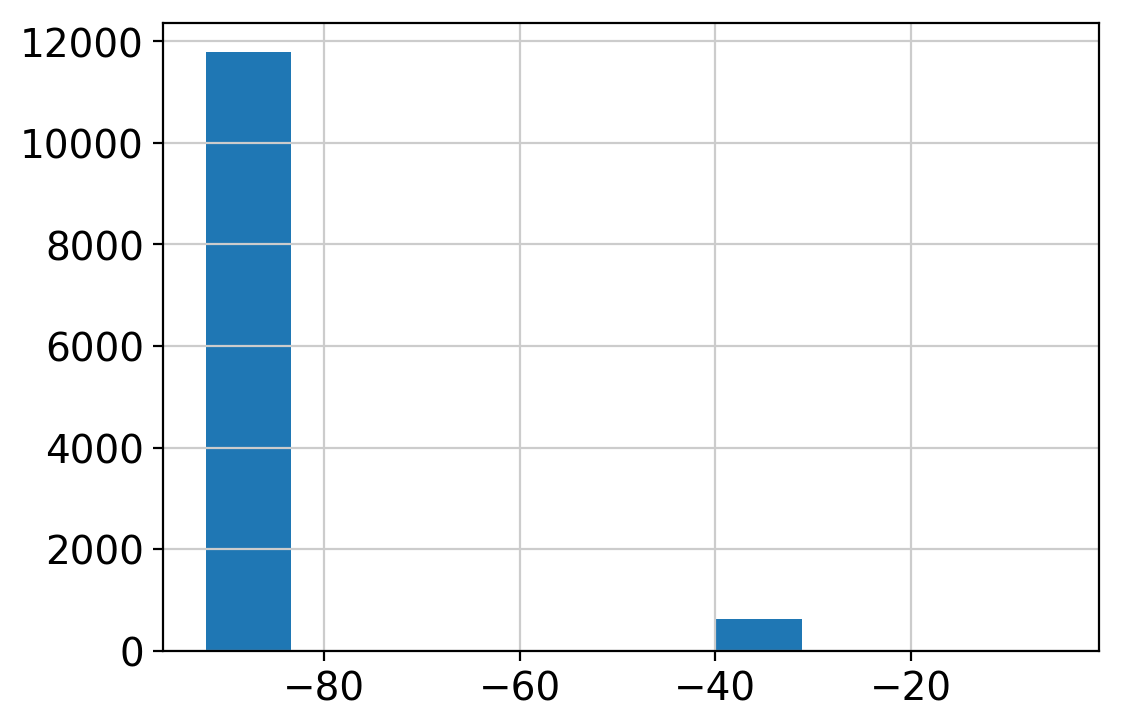

In [186]:
plt.figure()
plt.hist(np.log(MSE.clip(min=1e-40)))
plt.show()

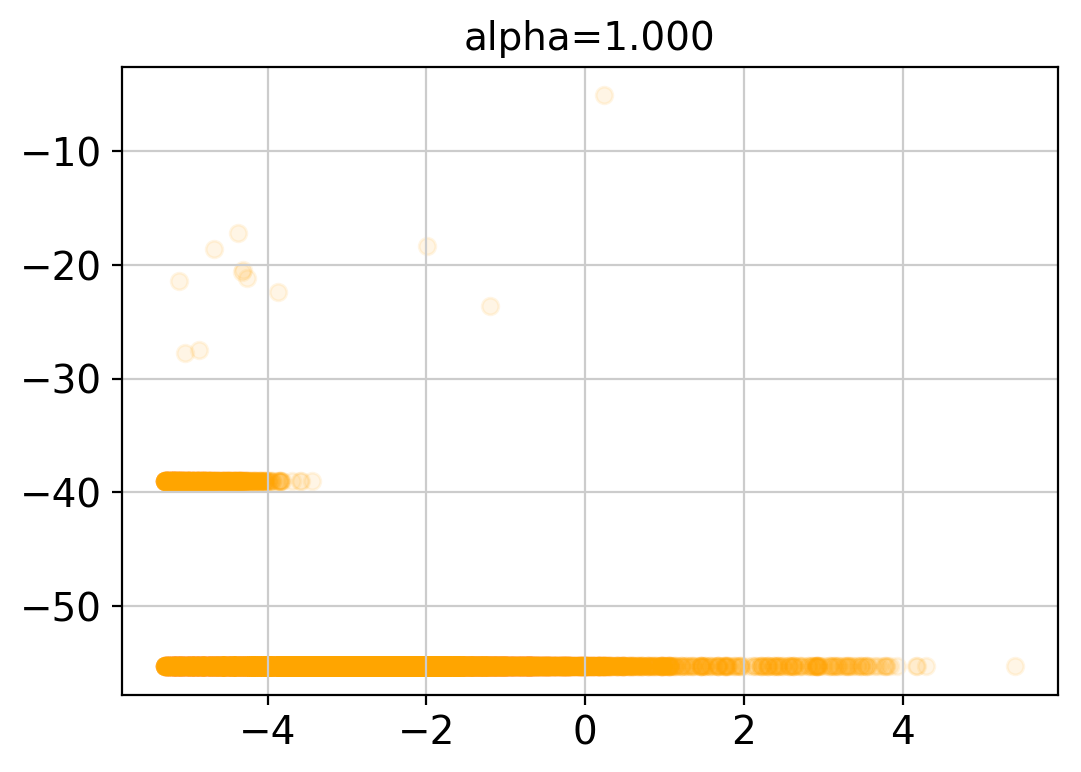

In [192]:
MSE = bound_MSE(M_8k,1,verbose=True,label='PBMC_8k')

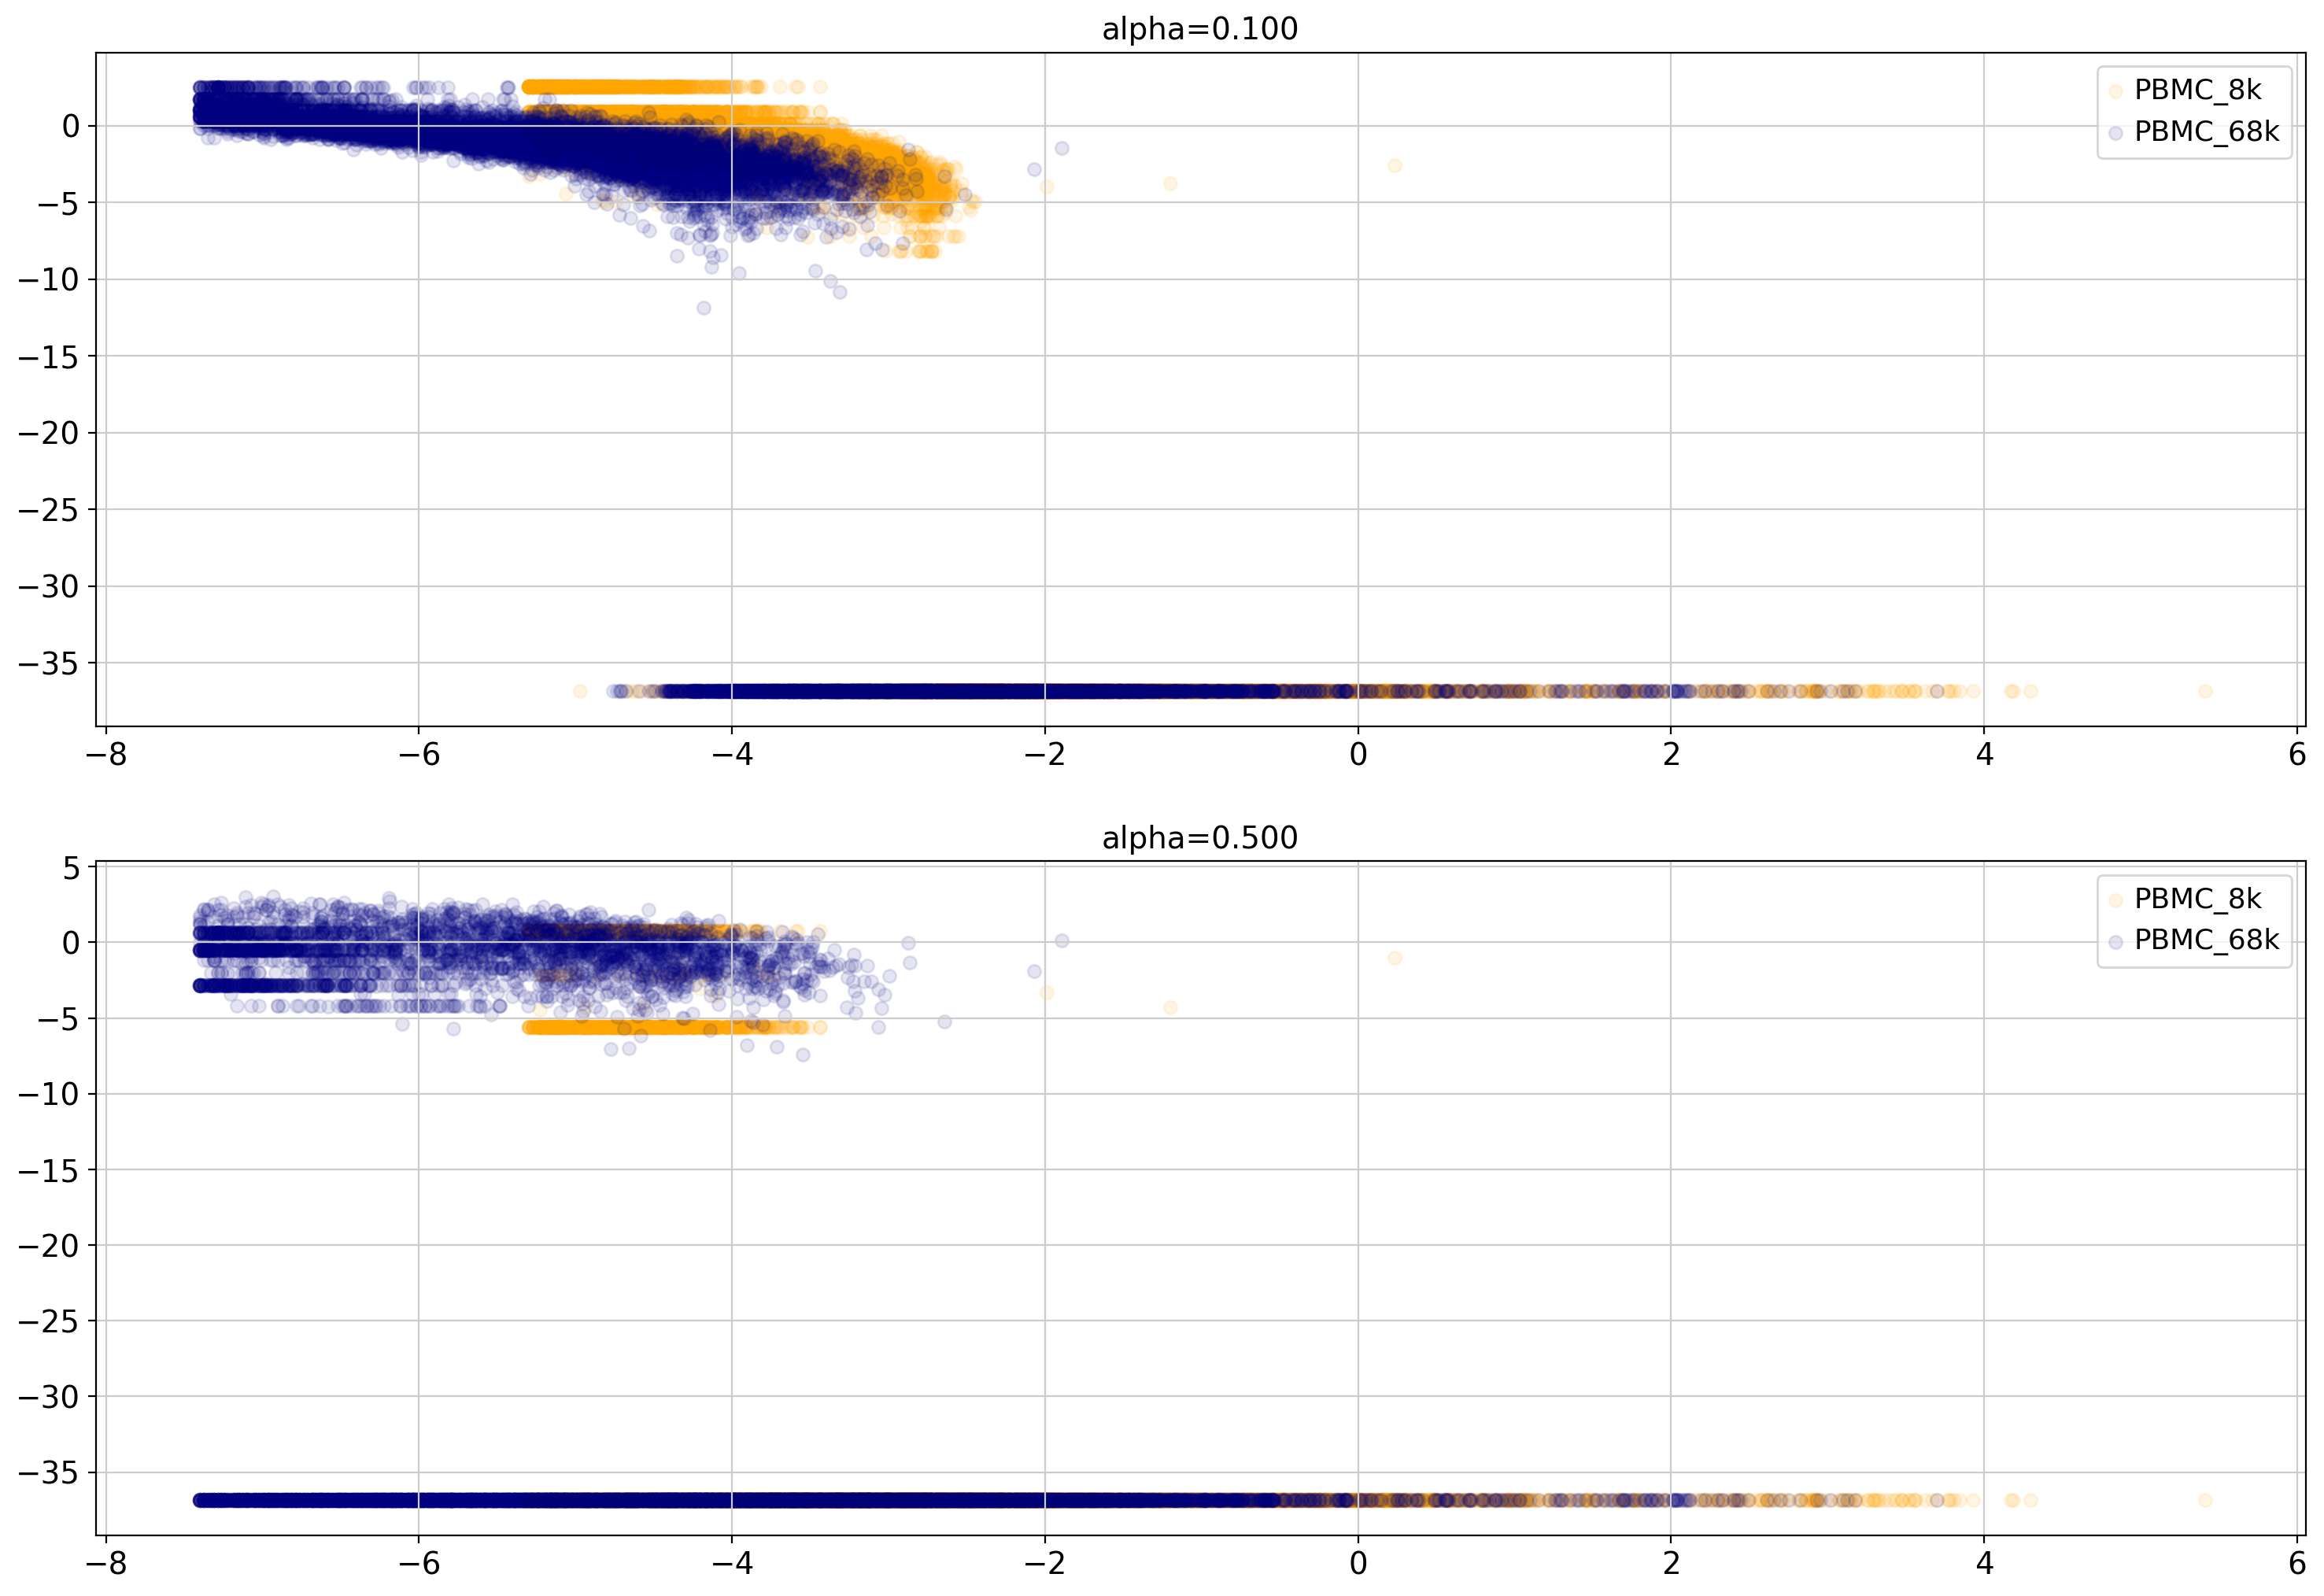

In [145]:
plt.figure(figsize=[18,12])
alpha=[0.1,0.5]
for i,a in enumerate(alpha):
    plt.subplot(str(len(alpha))+'1'+str(i+1))   
    _ = bound_MSE(M_8k,a,verbose=True,label='PBMC_8k')
    _ = bound_MSE(M_68k,a,verbose=True,label='PBMC_68k',color='navy')
    plt.legend()   
plt.show()

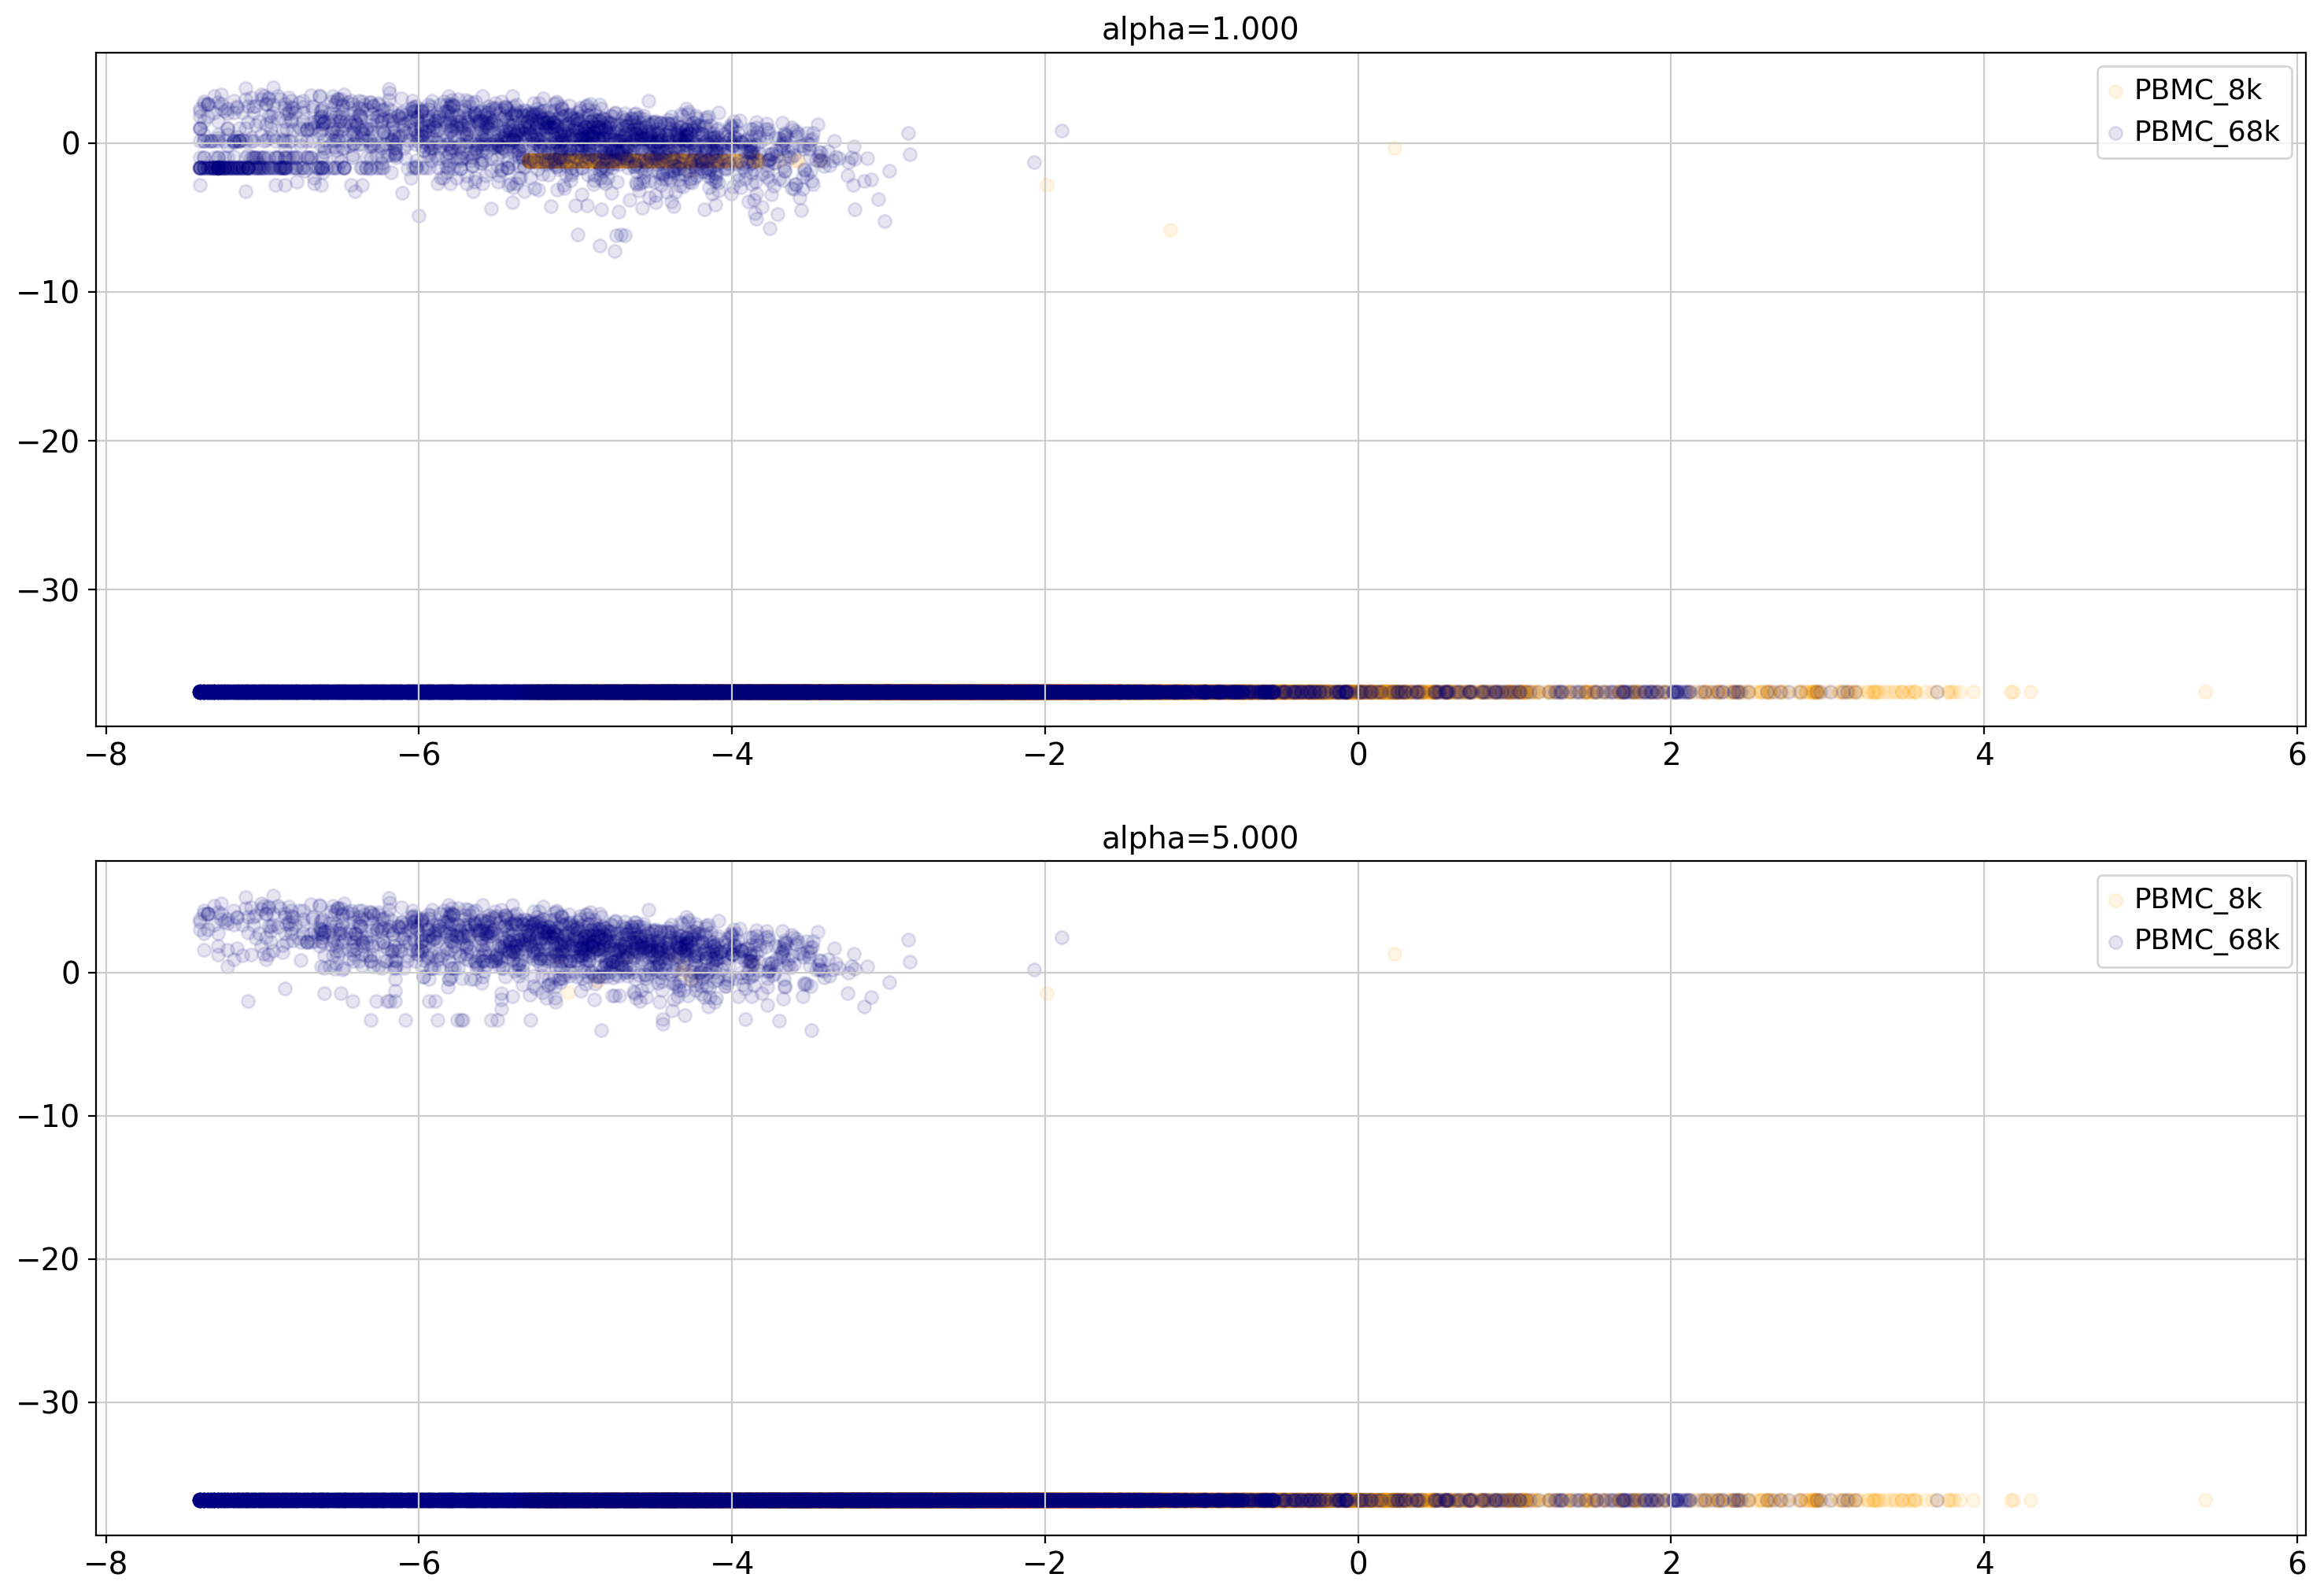

In [146]:
plt.figure(figsize=[18,12])
alpha=[1,5]
for i,a in enumerate(alpha):
    plt.subplot(str(len(alpha))+'1'+str(i+1))   
    _ = bound_MSE(M_8k,a,verbose=True,label='PBMC_8k')
    _ = bound_MSE(M_68k,a,verbose=True,label='PBMC_68k',color='navy')
    plt.legend()   
plt.show()

# consistency by the subsampling experiment

In [138]:
## 68k
temp = sc.pp.filter_genes(data_68k,min_counts=0.01*data_68k.shape[0],copy=True)
M_68k_sub1,M_ml_68k_sub1,gene_list_68k = moment_1d_mp(temp,n_job=8,n_sub=0.5,verbose=True)
M_68k_sub2,M_ml_68k_sub2,gene_list_68k = moment_1d_mp(temp,n_job=8,n_sub=0.5,verbose=True)
## basic statistics 
mean_68k_sub1,var_68k_sub1,cv_68k_sub1,fano_68k_sub1 = basic_cal(M_68k_sub1)
mean_68k_sub2,var_68k_sub2,cv_68k_sub2,fano_68k_sub2 = basic_cal(M_68k_sub2)

n_gene=6723, n_cell=68579, n_job=8
#time start: 0.0s
#time input: 16.9224s
#time mp: 152.2387s
#time total: 152.2466s
n_gene=6723, n_cell=68579, n_job=8
#time start: 0.0s
#time input: 17.7972s
#time mp: 154.2257s
#time total: 154.2371s


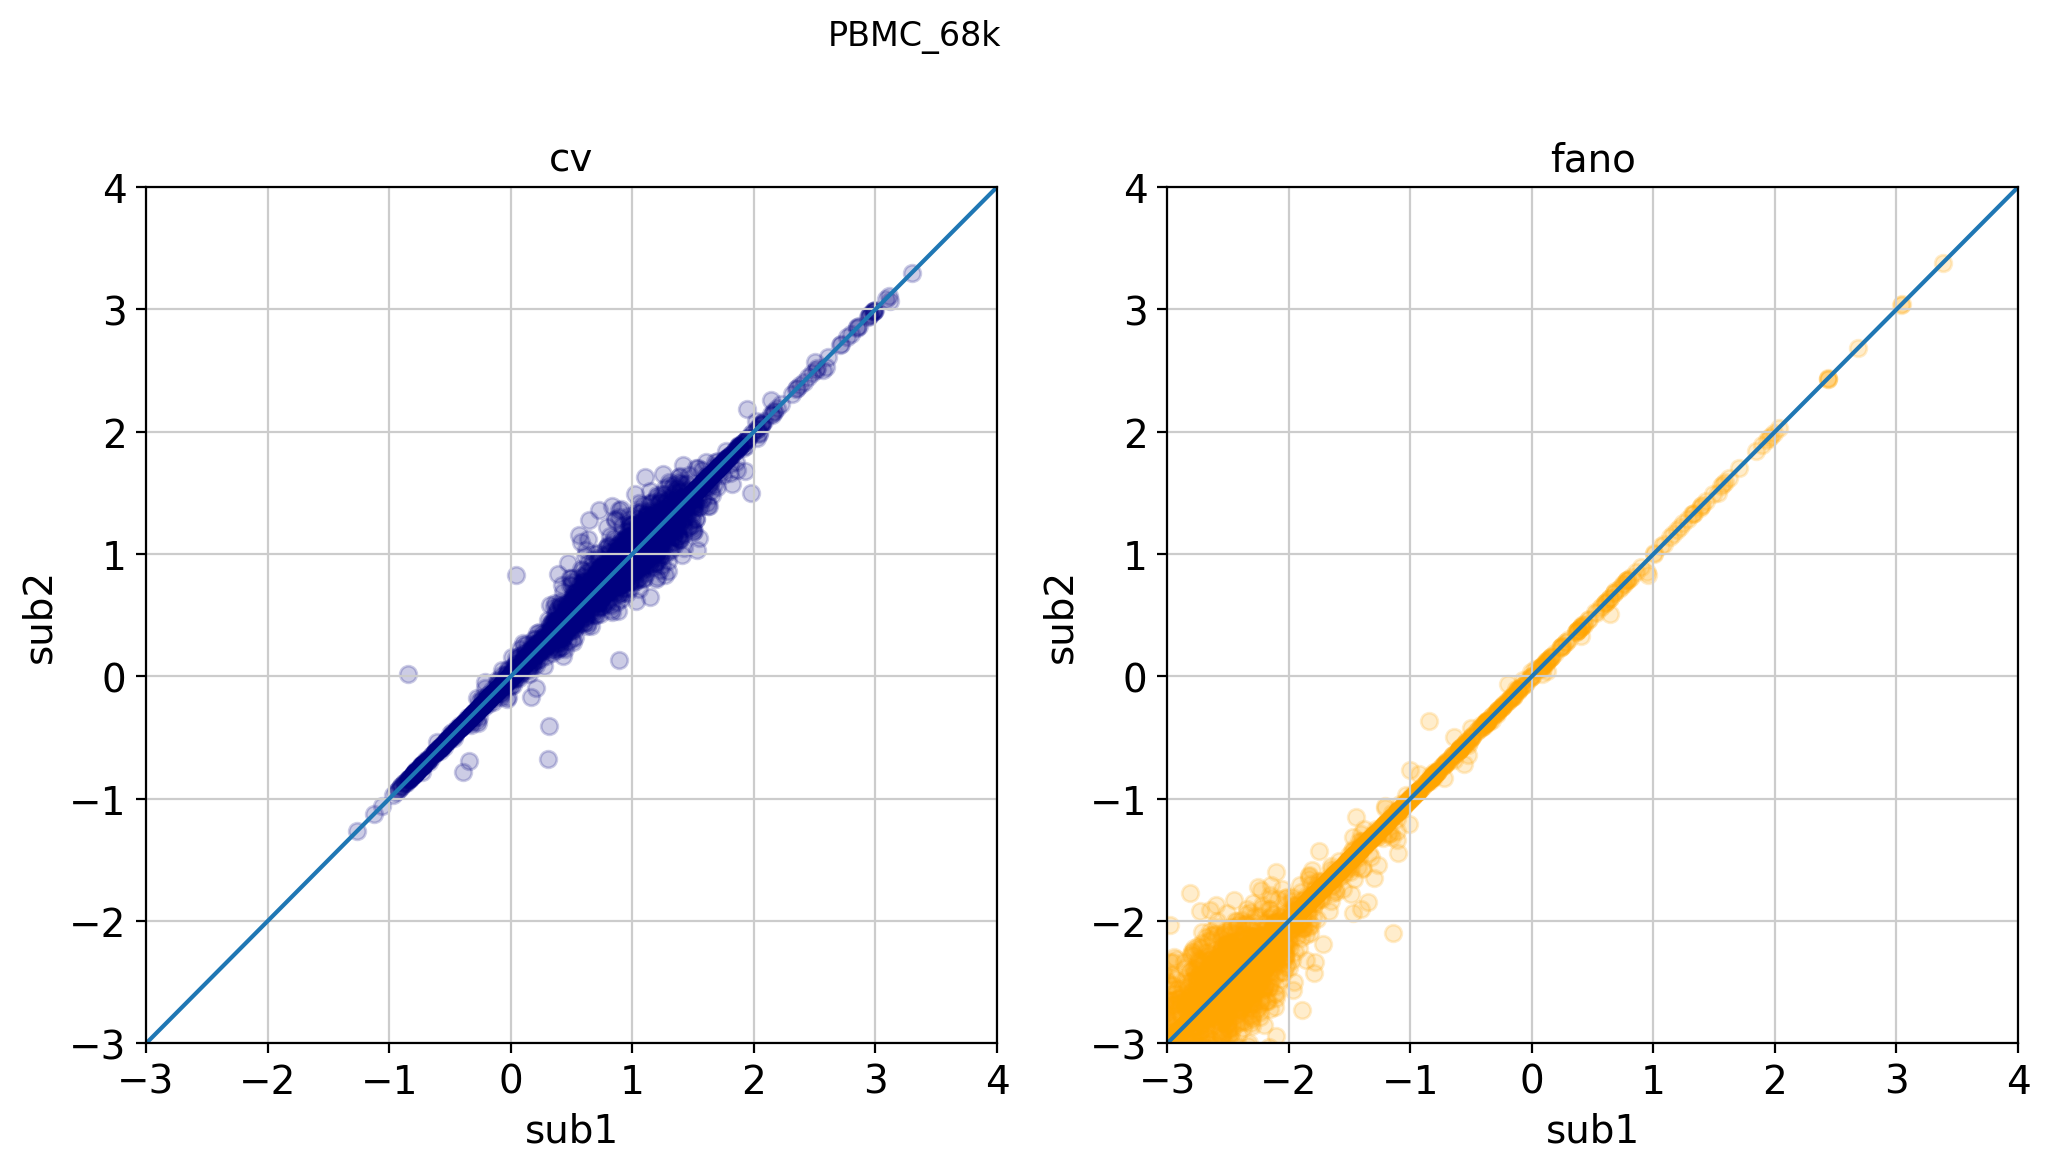

In [140]:
plt.figure(figsize=[12,12])
plt.subplot(221)
plt.scatter(np.log(cv_68k_sub1.clip(min=1e-4)),np.log(cv_68k_sub2.clip(min=1e-4)),color='navy',alpha=0.2)
plt.plot([-3,4],[-3,4])
plt.xlim([-3,4])
plt.ylim([-3,4])
plt.xlabel('sub1')
plt.ylabel('sub2')
plt.title('cv')
plt.subplot(222)
plt.scatter(np.log(fano_68k_sub1.clip(min=1e-4)),np.log(fano_68k_sub2.clip(min=1e-4)),color='orange',alpha=0.2)
plt.plot([-3,4],[-3,4])
plt.xlim([-3,4])
plt.ylim([-3,4])
plt.xlabel('sub1')
plt.ylabel('sub2')
plt.title('fano')
plt.suptitle('PBMC_68k')
plt.show()

In [143]:
## 8k
temp = sc.pp.filter_genes(data_8k,min_counts=0.01*data_8k.shape[0],copy=True)
M_68k_sub1,M_ml_68k_sub1,gene_list_68k = moment_1d_mp(temp,n_job=8,n_sub=0.5,verbose=True)
M_68k_sub2,M_ml_68k_sub2,gene_list_68k = moment_1d_mp(temp,n_job=8,n_sub=0.5,verbose=True)
## basic statistics 
mean_68k_sub1,var_68k_sub1,cv_68k_sub1,fano_68k_sub1 = basic_cal(M_68k_sub1)
mean_68k_sub2,var_68k_sub2,cv_68k_sub2,fano_68k_sub2 = basic_cal(M_68k_sub2)

n_gene=11062, n_cell=8381, n_job=8
#time start: 0.0s
#time input: 28.8176s
#time mp: 69.3355s
#time total: 69.3480s
n_gene=11062, n_cell=8381, n_job=8
#time start: 0.0s
#time input: 29.3110s
#time mp: 67.6490s
#time total: 67.6654s


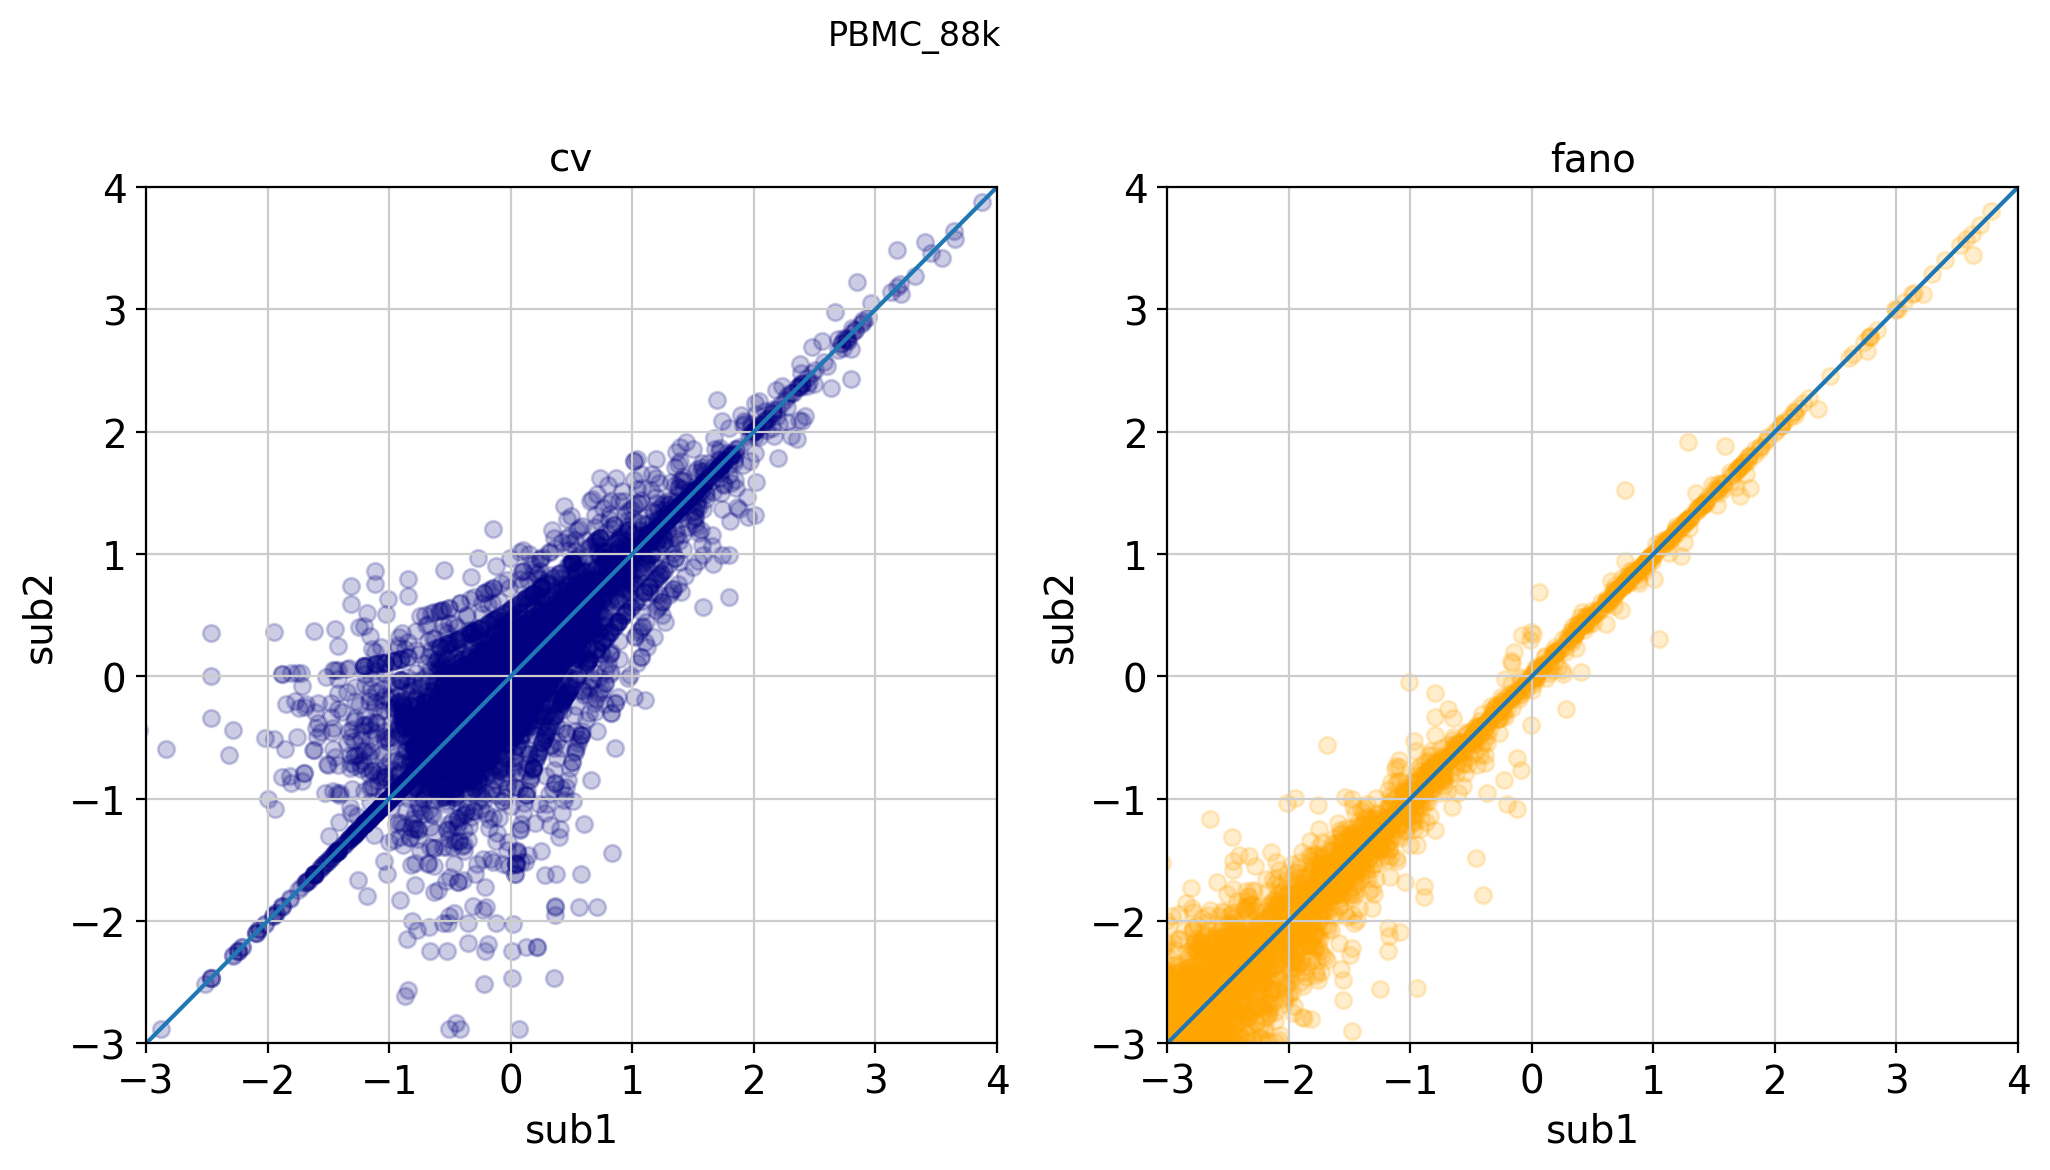

In [144]:
plt.figure(figsize=[12,12])
plt.subplot(221)
plt.scatter(np.log(cv_68k_sub1.clip(min=1e-4)),np.log(cv_68k_sub2.clip(min=1e-4)),color='navy',alpha=0.2)
plt.plot([-3,4],[-3,4])
plt.xlim([-3,4])
plt.ylim([-3,4])
plt.xlabel('sub1')
plt.ylabel('sub2')
plt.title('cv')
plt.subplot(222)
plt.scatter(np.log(fano_68k_sub1.clip(min=1e-4)),np.log(fano_68k_sub2.clip(min=1e-4)),color='orange',alpha=0.2)
plt.plot([-3,4],[-3,4])
plt.xlim([-3,4])
plt.ylim([-3,4])
plt.xlabel('sub1')
plt.ylabel('sub2')
plt.title('fano')
plt.suptitle('PBMC_88k')
plt.show()

# testing the consistency of moment estimation

## FTL: 
# PBMC_8k
mean=27.6006, var=1476.7180, cv=1.3923, cv_ml=1.4052, B=231321
# PBMC_68k
mean=6.7182, var=74.1280, cv=1.2816, cv_ml=1.3384, B=460728


## S100A9: 
# PBMC_8k
mean=16.6596, var=1242.5405, cv=2.1159, cv_ml=2.1300, B=139624
# PBMC_68k
mean=0.2990, var=2.2470, cv=5.0131, cv_ml=5.3363, B=20506


## S100A8: 
# PBMC_8k
mean=13.6827, var=924.4986, cv=2.2222, cv_ml=2.2386, B=114675
# PBMC_68k
mean=0.2078, var=1.7271, cv=6.3246, cv_ml=6.6942, B=14249


## S100A4: 
# PBMC_8k
mean=10.8557, var=169.5144, cv=1.1993, cv_ml=1.2372, B=90981
# PBMC_68k
mean=2.4954, var=8.9274, cv=1.1974, cv_ml=1.3544, B=171132


## LGALS2: 
# PBMC_8k
mean=1.2555, var=6.7130, cv=2.0638, cv_ml=2.2485, B=10522
# PBMC_68k
mean=0.0405, var=0.1068, cv=8.0723, cv_ml=9.4793, B=2777


## FCN1: 
# PBMC_8k
mean=2.1747, var=17.4791, cv=1.9225, cv_ml=2.0386, B=18226
# PBMC_68k
mean=0.1441, var=0.6379, cv=5.5424, cv_ml=6.1365, B=9883


## CD14: 
# PBMC_8k
mean=0.6565, var=2.1236, cv=2.2198, cv_ml=2.5398, B=5502
# P

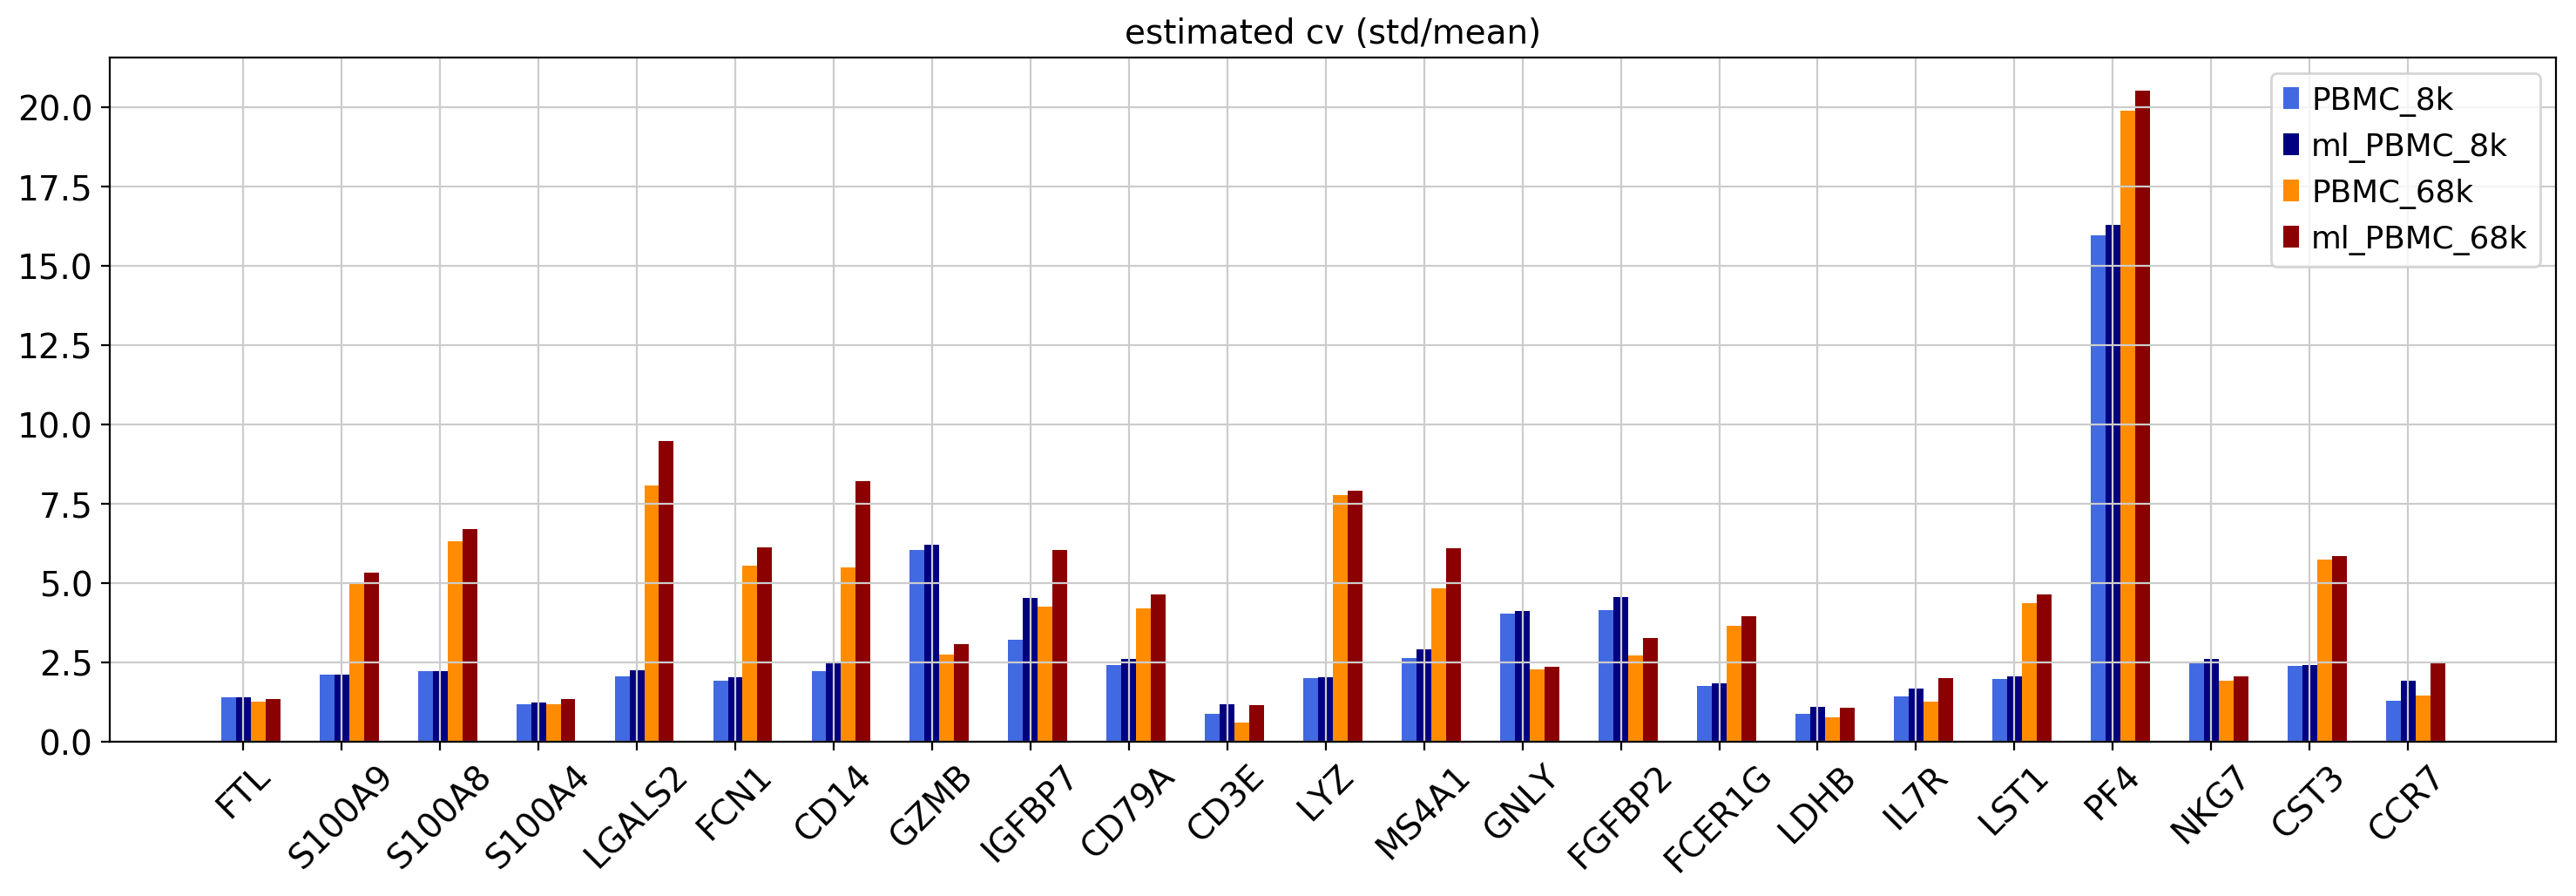

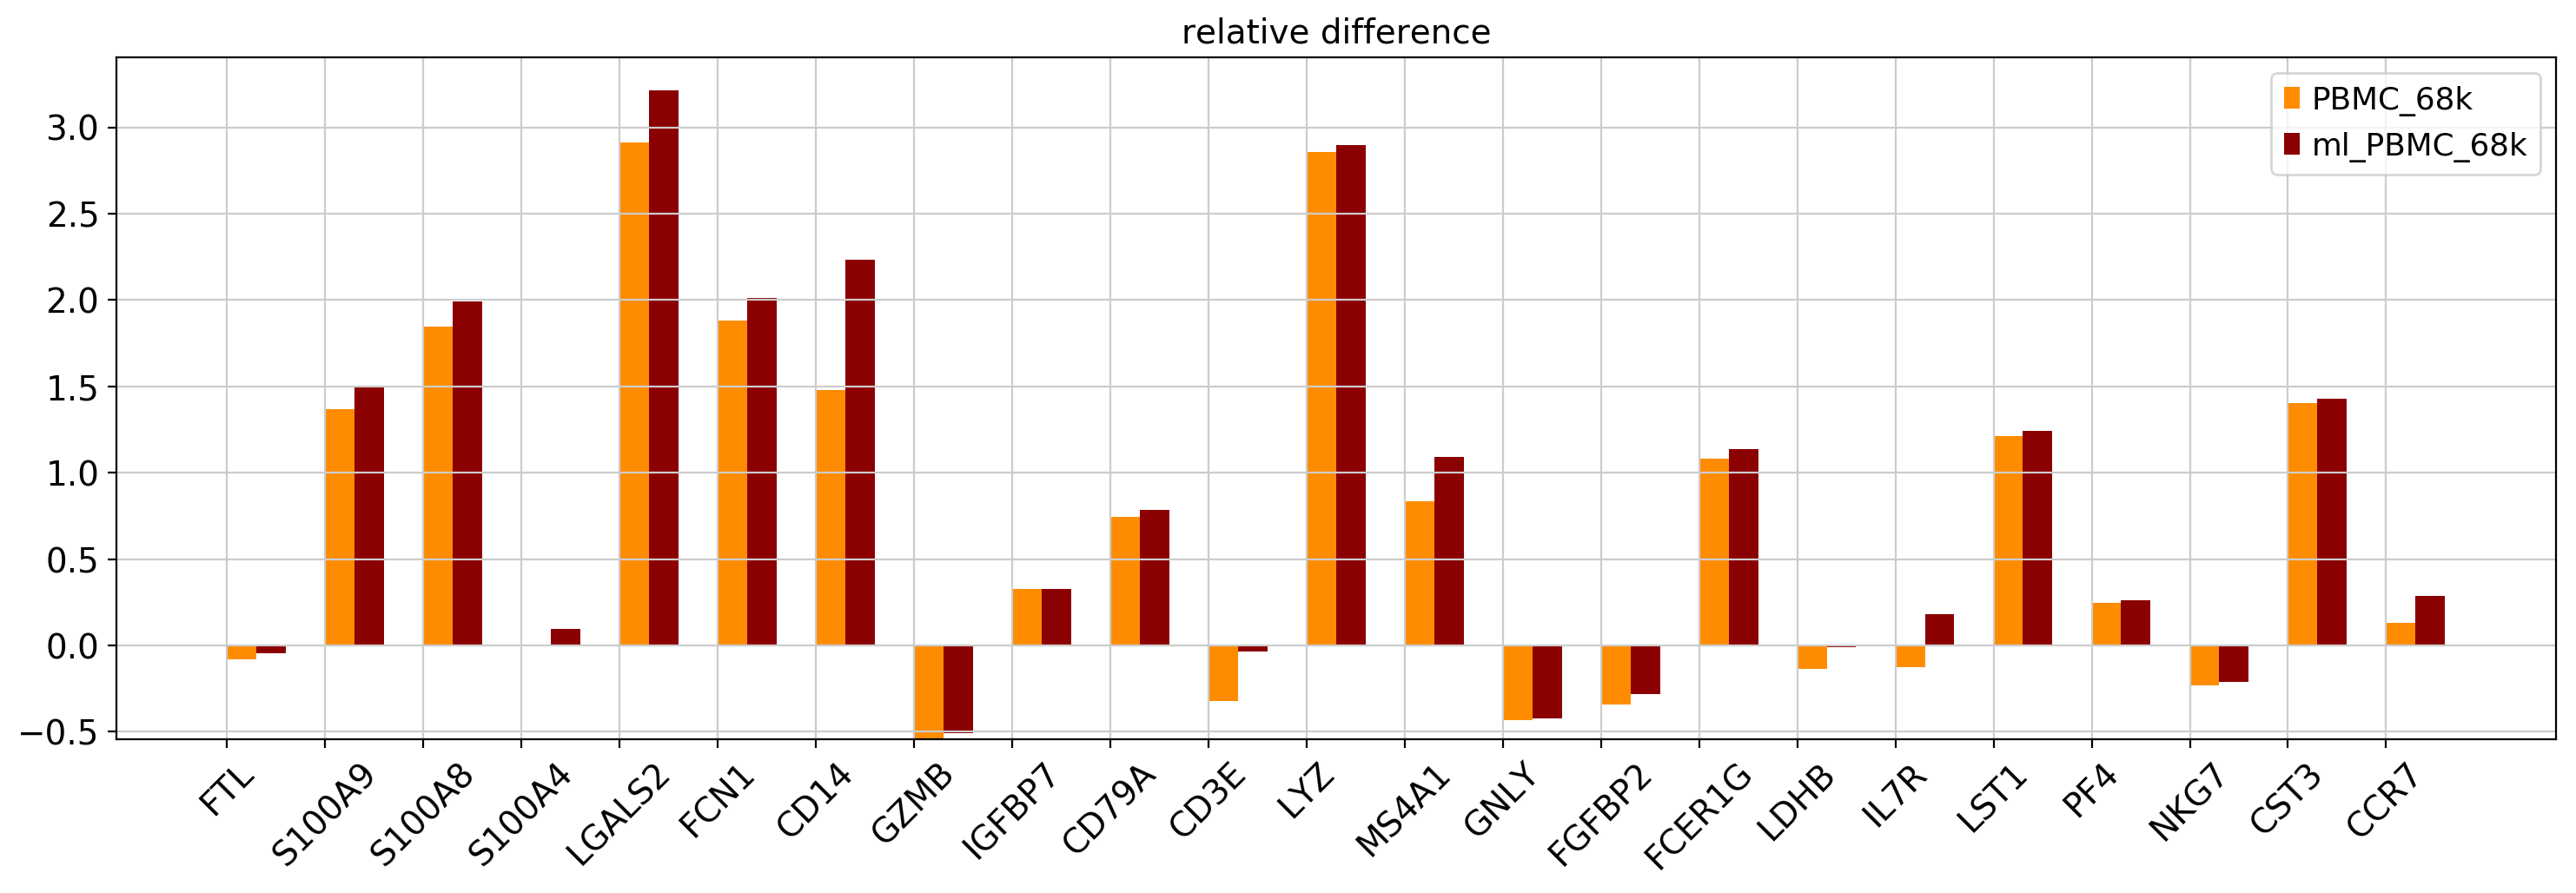

## summary
# average cv_68k:4.4123
# average cv_68k/cv_ml_68k:0.8456
# average cv_68k/cv_8k:1.7002
# average cv_ml_68k/cv_ml_8k:1.8336
# average relative difference: 0.4465
# average relative ml difference: 0.4825


In [32]:
## marker gene, plain 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=gene_list,size_factor=None,sub_samp=False,verbose=True)

## FTL: 
# PBMC_8k
mean=26.5540, var=1067.6132, cv=1.2305, cv_ml=1.2225, B=222548
# PBMC_68k
mean=6.3447, var=52.8685, cv=1.1460, cv_ml=1.1286, B=435110


## S100A9: 
# PBMC_8k
mean=17.3405, var=1385.5947, cv=2.1466, cv_ml=2.1208, B=145330
# PBMC_68k
mean=0.4765, var=10.0338, cv=6.6483, cv_ml=6.4605, B=32674


## S100A8: 
# PBMC_8k
mean=15.1669, var=1276.6185, cv=2.3558, cv_ml=2.3262, B=127114
# PBMC_68k
mean=0.4039, var=9.6893, cv=7.7076, cv_ml=7.5752, B=27696


## S100A4: 
# PBMC_8k
mean=9.9833, var=114.3047, cv=1.0709, cv_ml=1.0788, B=83669
# PBMC_68k
mean=2.2329, var=8.6256, cv=1.3153, cv_ml=1.3326, B=153128


## LGALS2: 
# PBMC_8k
mean=1.0058, var=4.2712, cv=2.0547, cv_ml=2.1385, B=8429
# PBMC_68k
mean=0.0344, var=0.0907, cv=8.7581, cv_ml=9.1832, B=2358


## FCN1: 
# PBMC_8k
mean=1.8771, var=12.0999, cv=1.8531, cv_ml=1.8959, B=15732
# PBMC_68k
mean=0.1085, var=0.3268, cv=5.2686, cv_ml=5.6002, B=7440


## CD14: 
# PBMC_8k
mean=0.5563, var=1.7314, cv=2.3655, cv_ml=2.4646, B=4662
# P

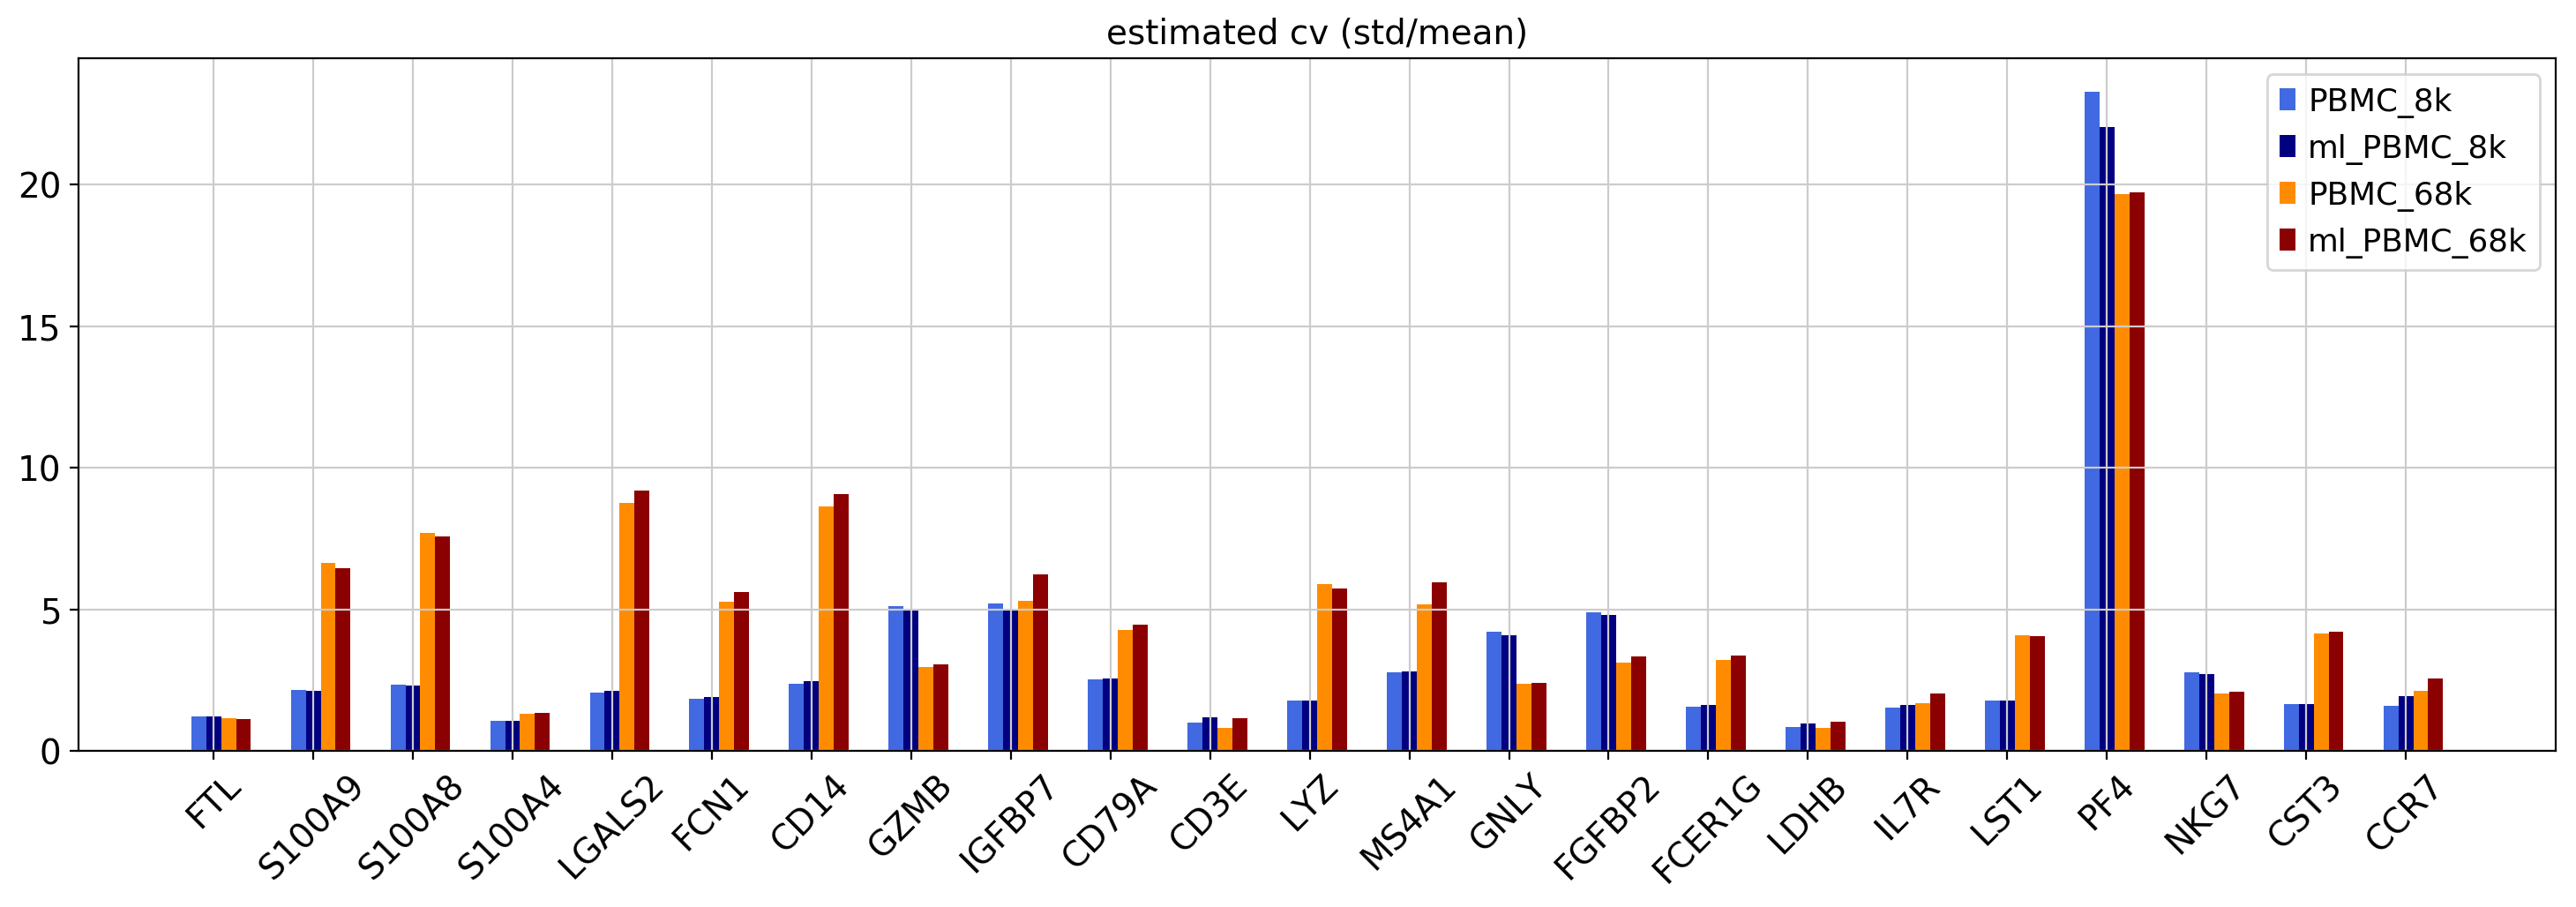

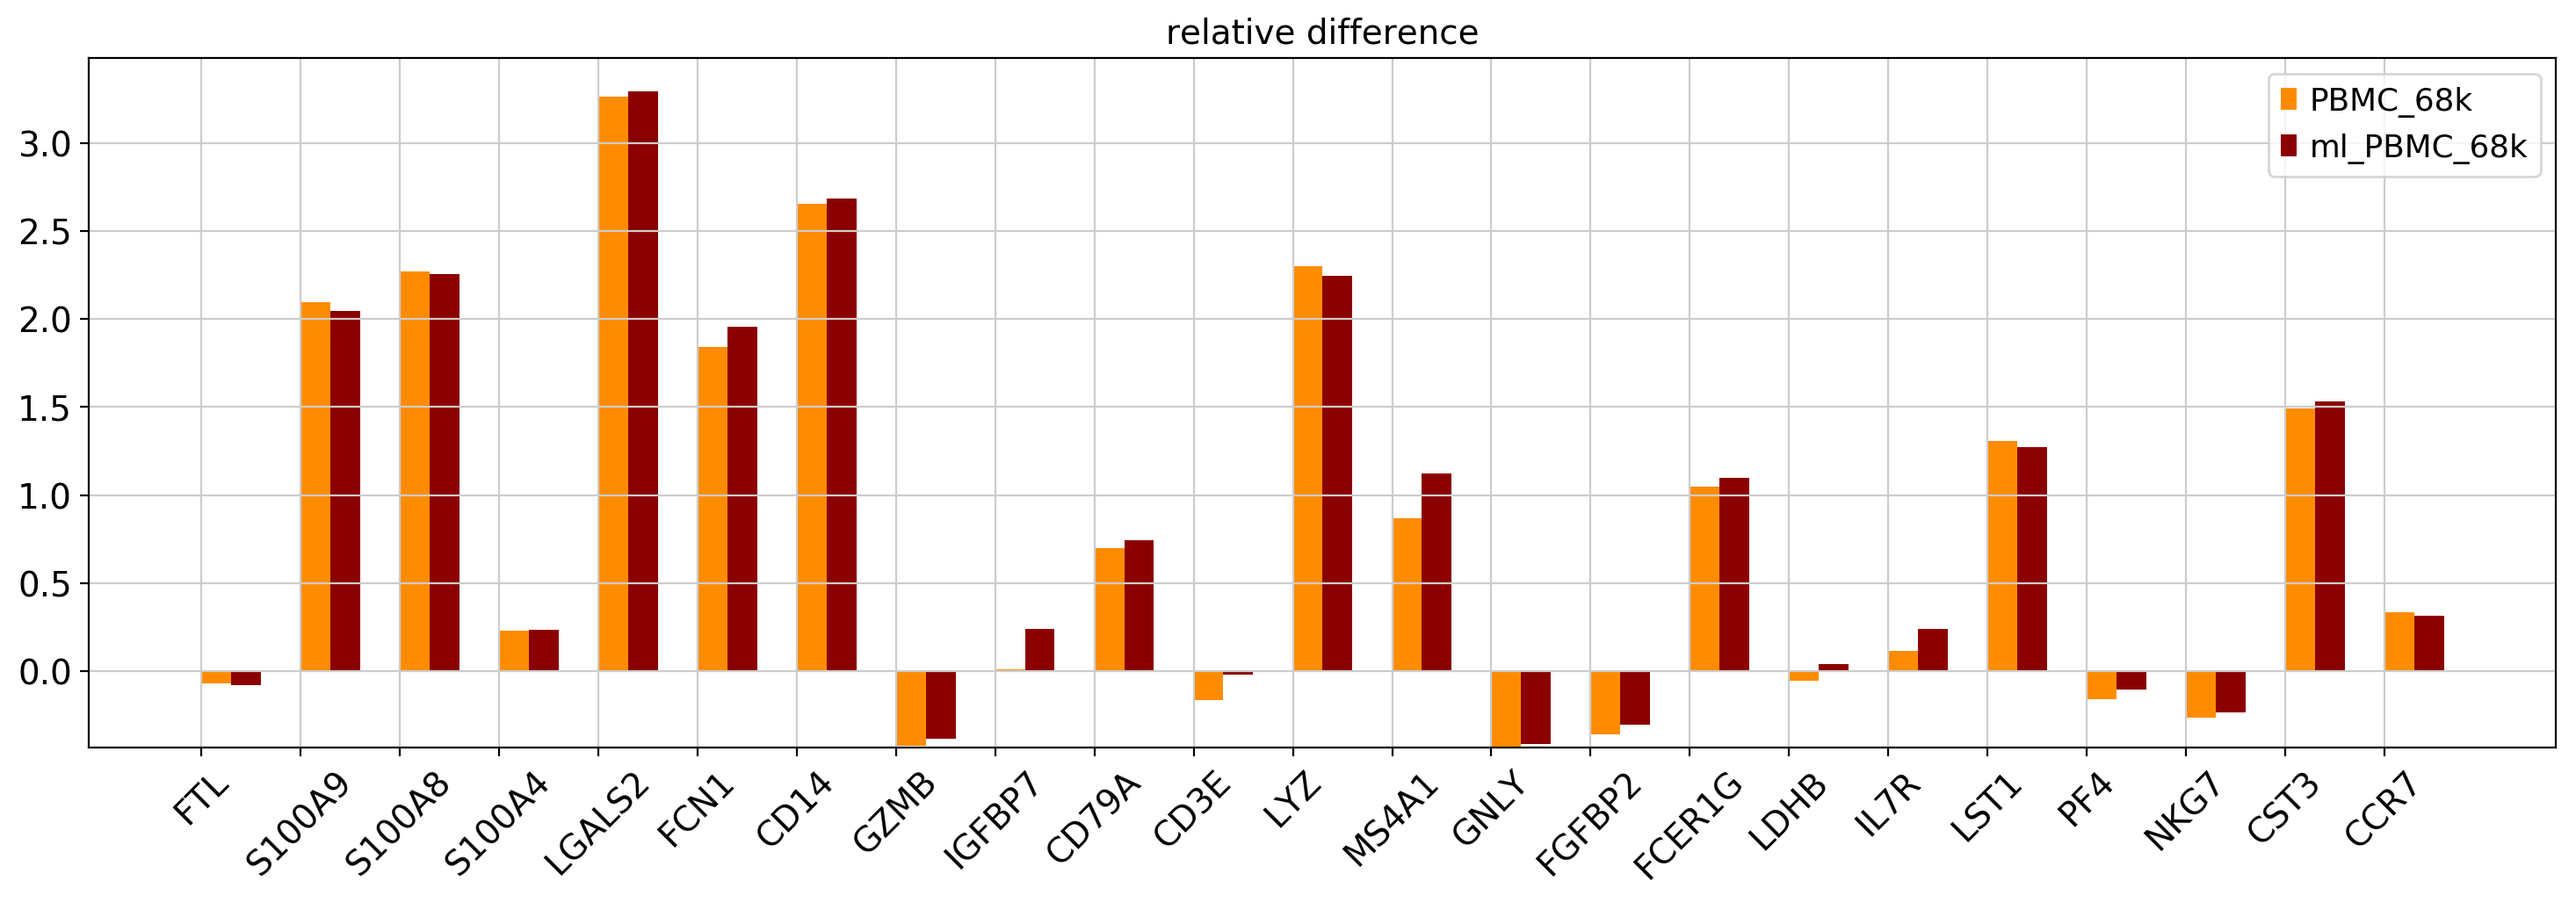

## summary
# average cv_68k:4.6615
# average cv_68k/cv_ml_68k:0.9386
# average cv_68k/cv_8k:1.8096
# average cv_ml_68k/cv_ml_8k:1.8604
# average relative difference: 0.4882
# average relative ml difference: 0.4969


In [33]:
## marker gene, size 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=gene_list,size_factor=sf,sub_samp=False,verbose=True)

## FTL: 
# PBMC_8k
mean=27.6006, var=1476.7180, cv=1.3923, cv_ml=1.4052, B=231321
# PBMC_68k
mean=3.3731, var=18.8031, cv=1.2856, cv_ml=1.3961, B=231320


## S100A9: 
# PBMC_8k
mean=2.4467, var=26.7807, cv=2.1151, cv_ml=2.2096, B=20506
# PBMC_68k
mean=0.2990, var=2.2470, cv=5.0131, cv_ml=5.3363, B=20506


## S100A8: 
# PBMC_8k
mean=1.7003, var=14.0469, cv=2.2043, cv_ml=2.3339, B=14250
# PBMC_68k
mean=0.2078, var=1.7271, cv=6.3246, cv_ml=6.6942, B=14249


## S100A4: 
# PBMC_8k
mean=10.8557, var=169.5144, cv=1.1993, cv_ml=1.2372, B=90981
# PBMC_68k
mean=1.3267, var=2.5210, cv=1.1968, cv_ml=1.4785, B=90982


## LGALS2: 
# PBMC_8k
mean=0.3313, var=0.4405, cv=2.0031, cv_ml=2.6515, B=2777
# PBMC_68k
mean=0.0405, var=0.1068, cv=8.0723, cv_ml=9.4793, B=2777


## FCN1: 
# PBMC_8k
mean=1.1792, var=5.2853, cv=1.9496, cv_ml=2.1561, B=9882
# PBMC_68k
mean=0.1441, var=0.6379, cv=5.5424, cv_ml=6.1365, B=9883


## CD14: 
# PBMC_8k
mean=0.2209, var=0.2433, cv=2.2334, cv_ml=3.0848, B=1850
# PBMC_68k
mea

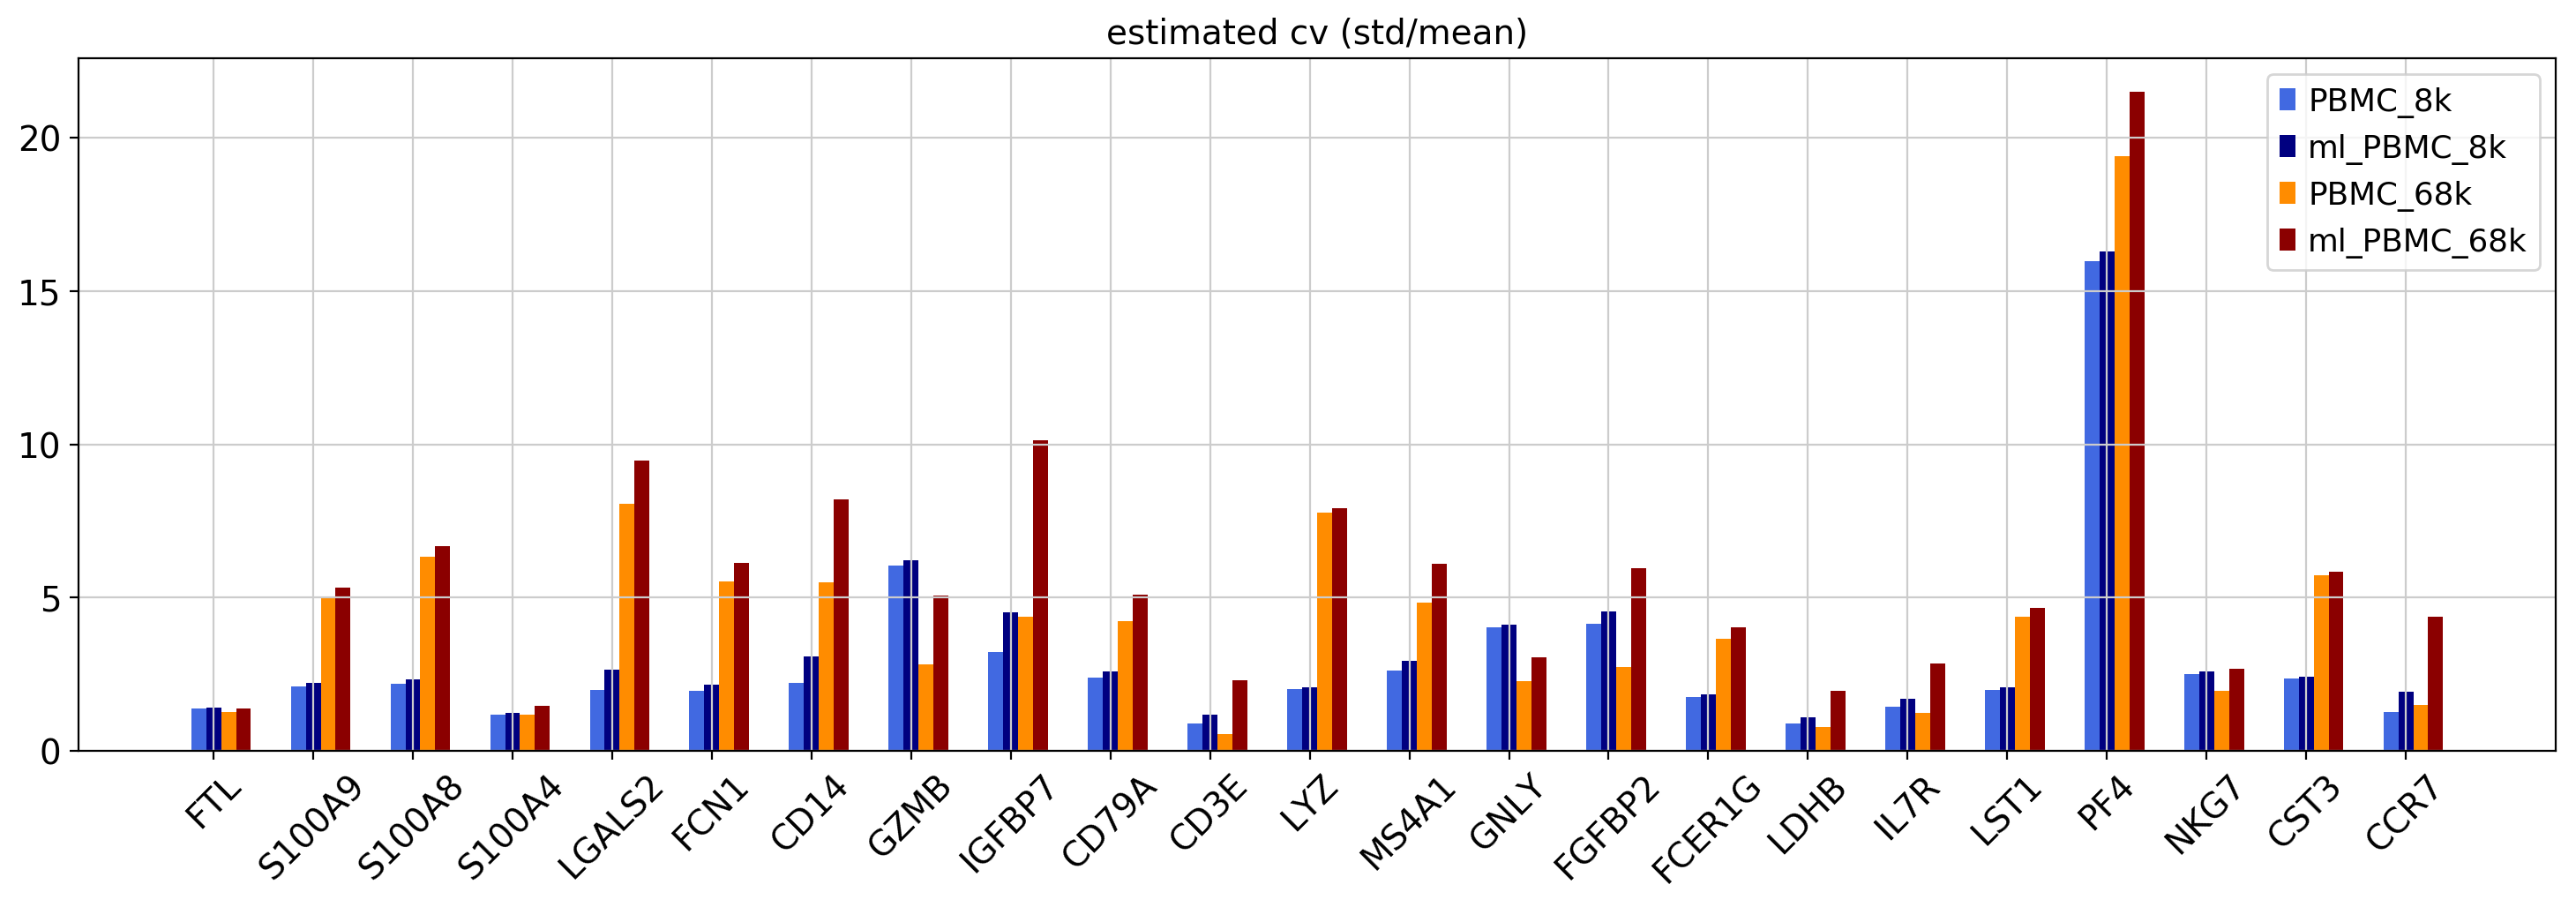

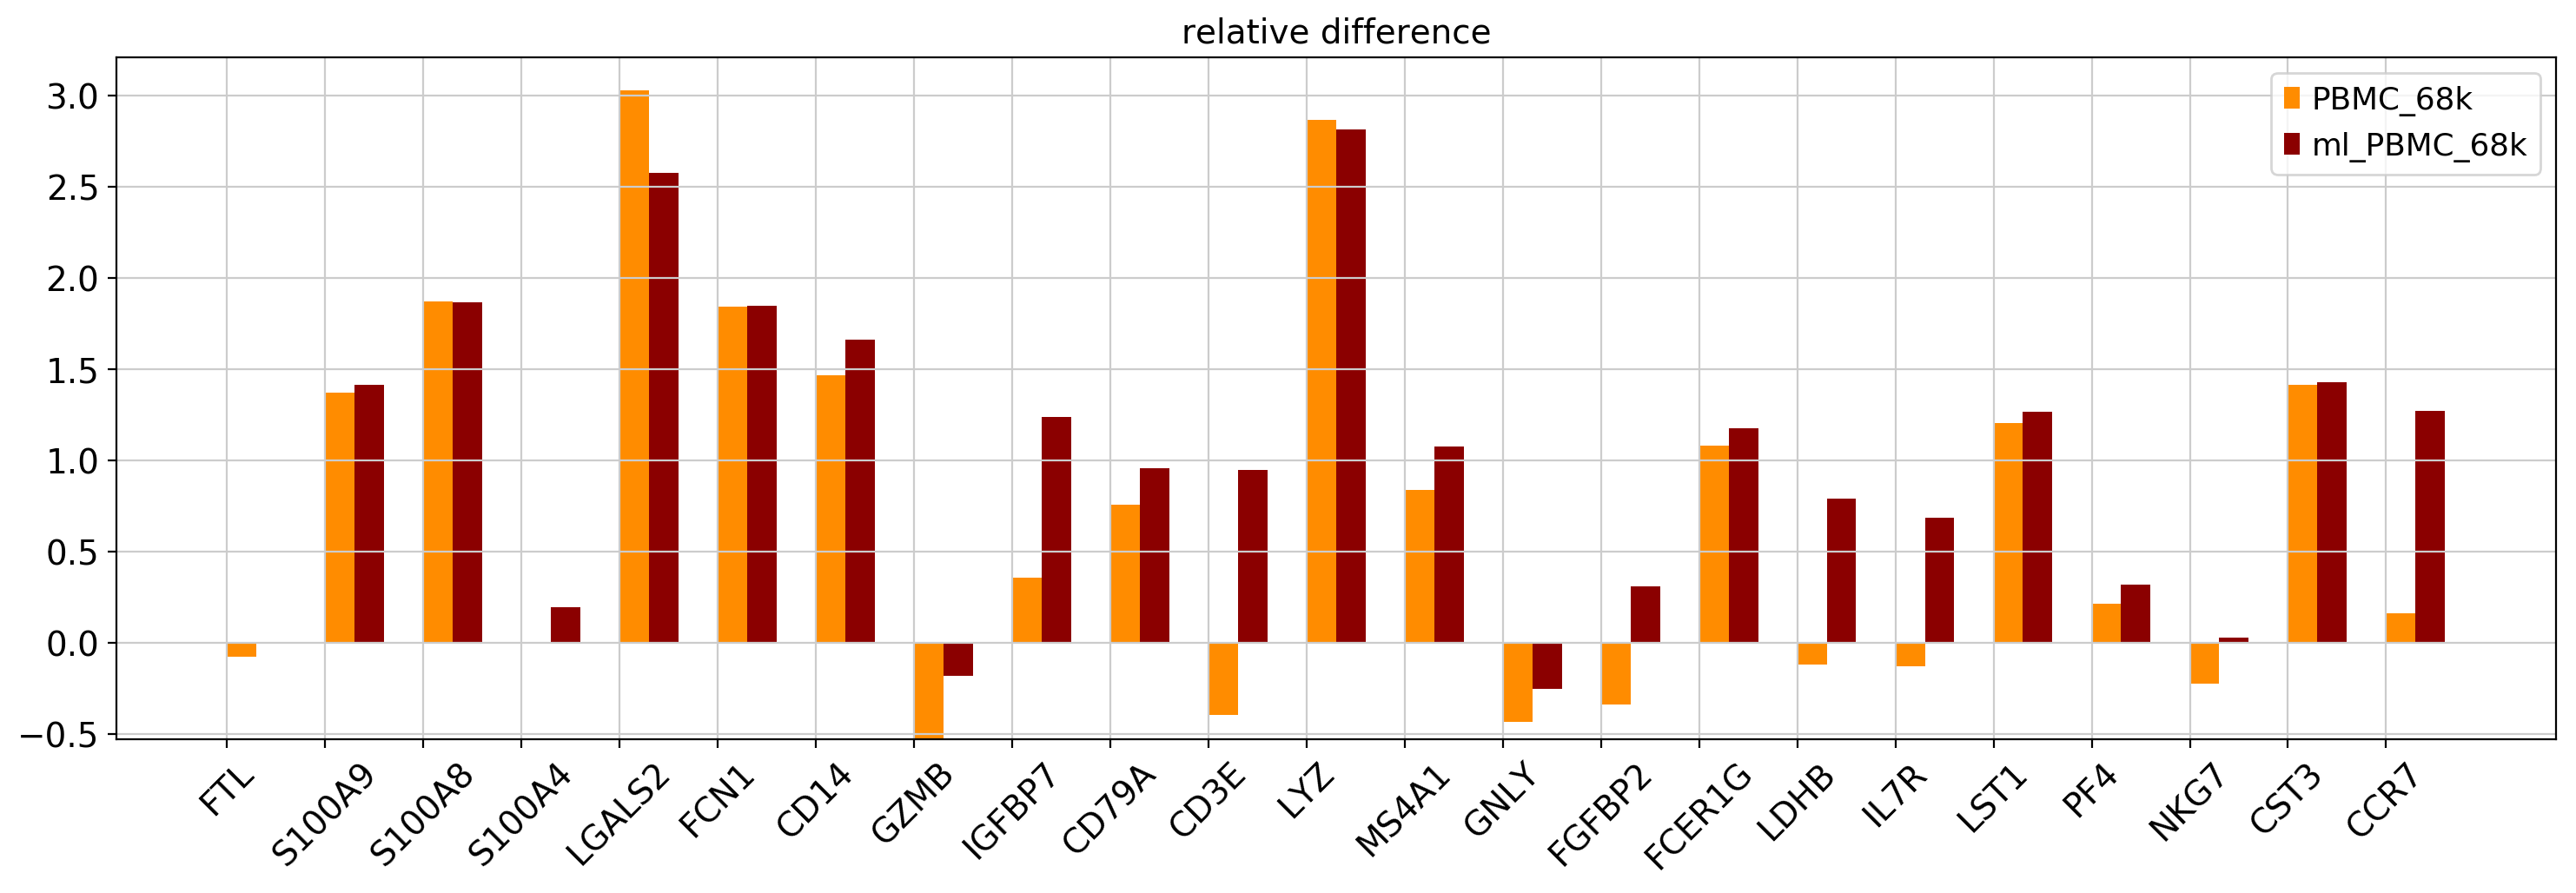

## summary
# average cv_68k:4.4009
# average cv_68k/cv_ml_68k:0.7265
# average cv_68k/cv_8k:1.7051
# average cv_ml_68k/cv_ml_8k:2.0182
# average relative difference: 0.4506
# average relative ml difference: 0.5284


In [34]:
## marker gene, subsample 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=gene_list,size_factor=None,sub_samp=True,verbose=True)

## FTL: 
# PBMC_8k
mean=26.5540, var=1067.6132, cv=1.2305, cv_ml=1.2225, B=222548
# PBMC_68k
mean=2.9962, var=13.8550, cv=1.2423, cv_ml=1.2073, B=205474


## S100A9: 
# PBMC_8k
mean=2.4151, var=28.7049, cv=2.2184, cv_ml=2.2067, B=20240
# PBMC_68k
mean=0.4765, var=10.0338, cv=6.6483, cv_ml=6.4605, B=32674


## S100A8: 
# PBMC_8k
mean=1.7627, var=18.8161, cv=2.4609, cv_ml=2.4405, B=14773
# PBMC_68k
mean=0.4039, var=9.6893, cv=7.7076, cv_ml=7.5752, B=27696


## S100A4: 
# PBMC_8k
mean=9.9833, var=114.3047, cv=1.0709, cv_ml=1.0788, B=83669
# PBMC_68k
mean=1.0952, var=2.4656, cv=1.4338, cv_ml=1.4869, B=75105


## LGALS2: 
# PBMC_8k
mean=0.2143, var=0.2600, cv=2.3795, cv_ml=2.6876, B=1795
# PBMC_68k
mean=0.0344, var=0.0907, cv=8.7581, cv_ml=9.1832, B=2358


## FCN1: 
# PBMC_8k
mean=0.9647, var=3.3861, cv=1.9075, cv_ml=2.0158, B=8085
# PBMC_68k
mean=0.1085, var=0.3268, cv=5.2686, cv_ml=5.6002, B=7440


## CD14: 
# PBMC_8k
mean=0.1558, var=0.1900, cv=2.7973, cv_ml=3.1531, B=1306
# PBMC_68k
mea

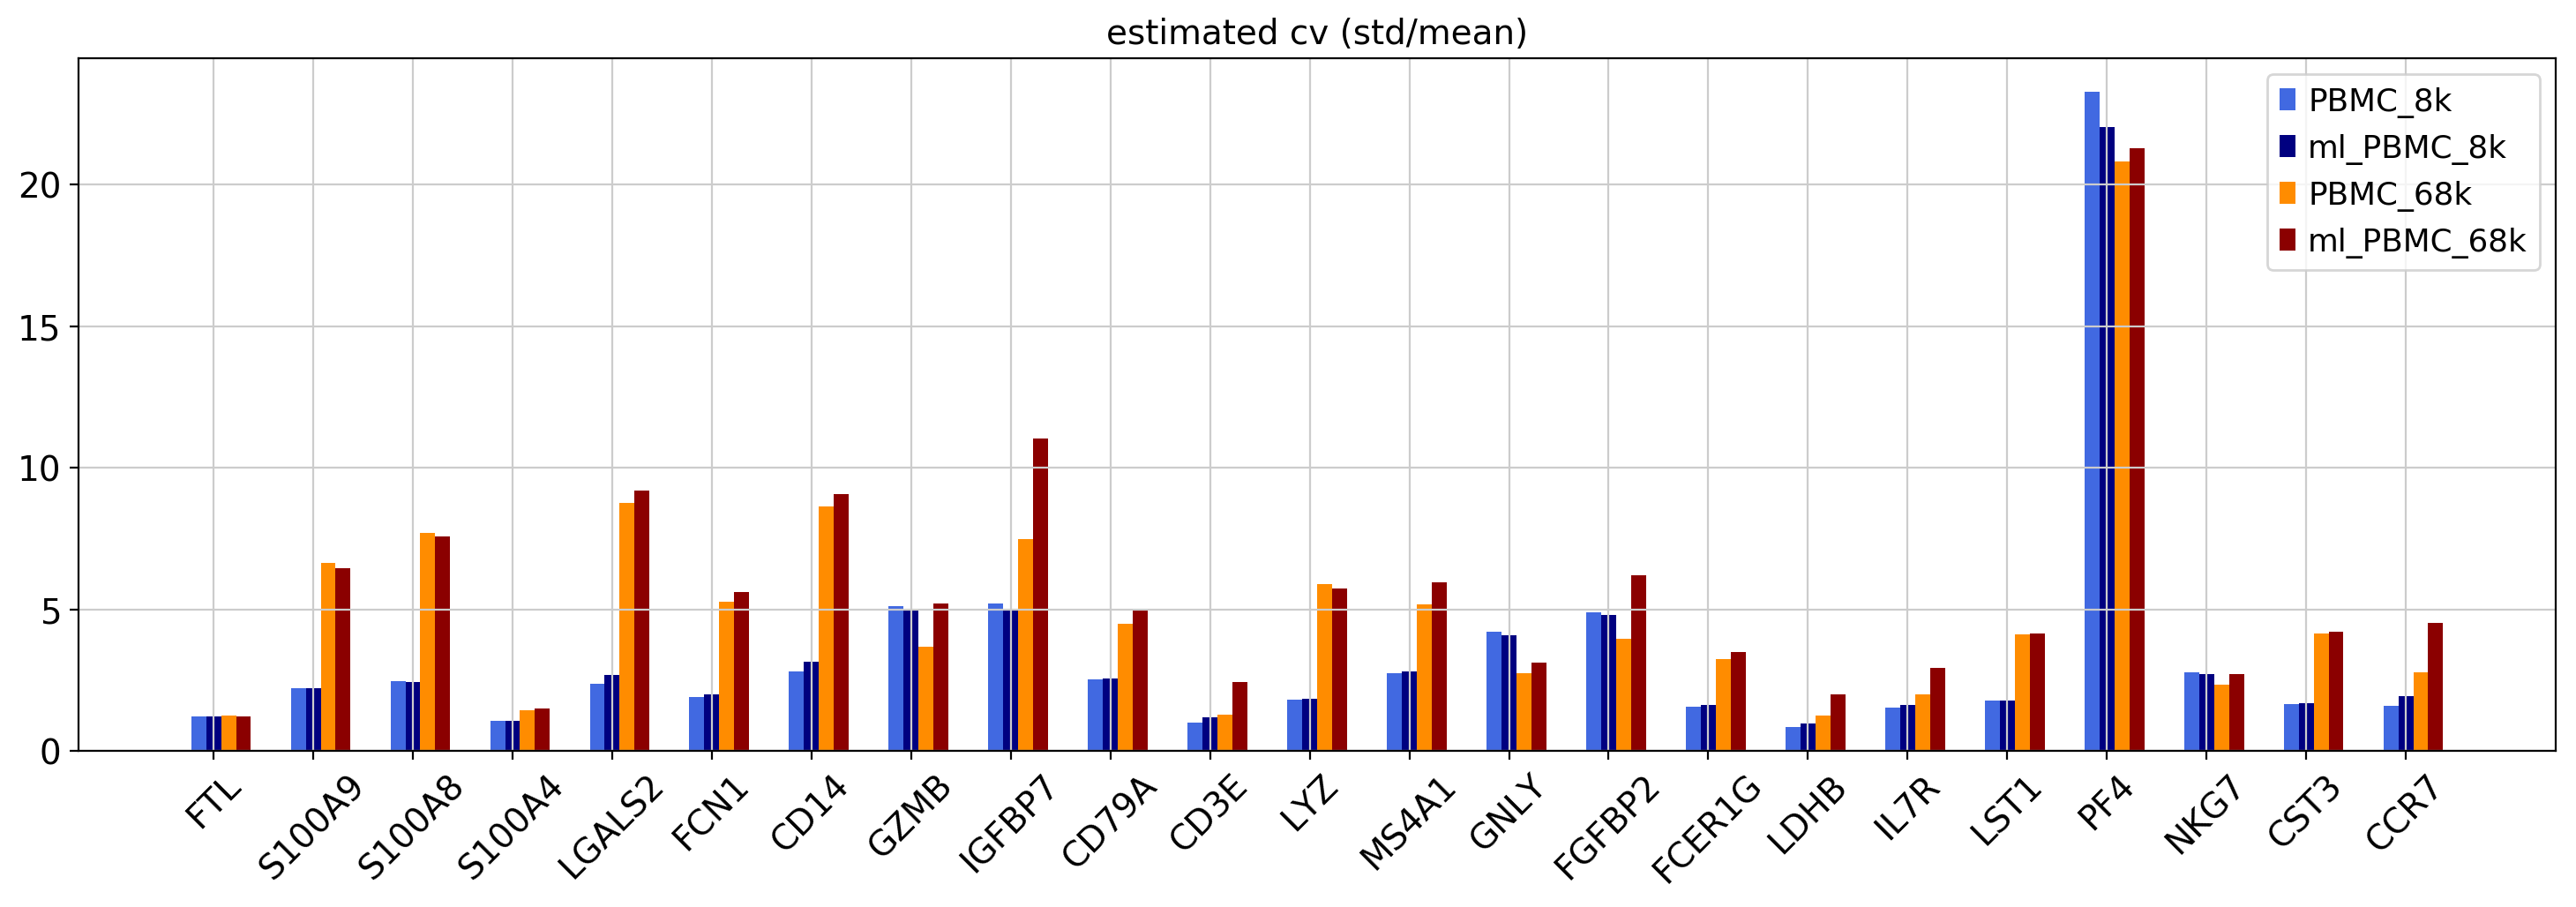

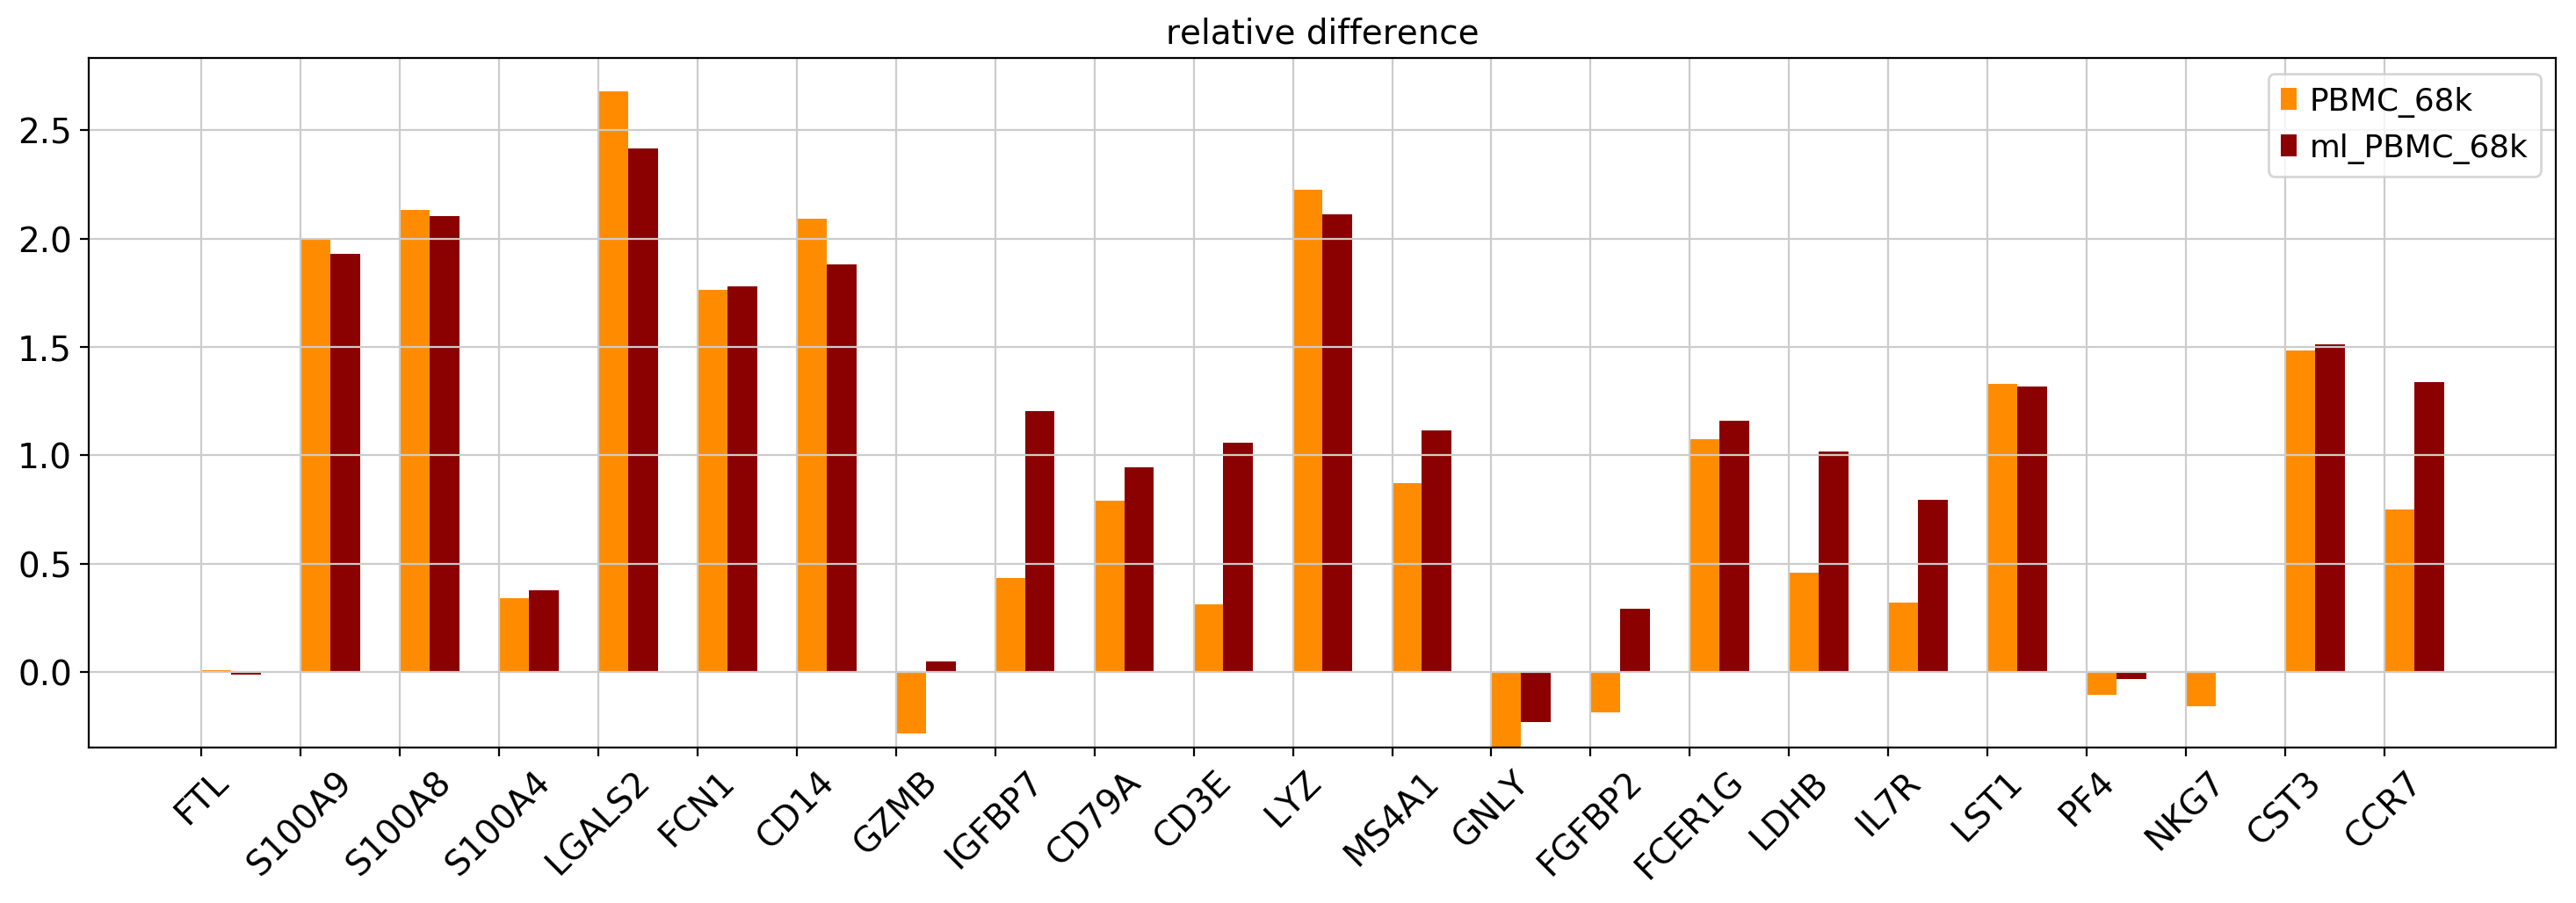

## summary
# average cv_68k:5.0072
# average cv_68k/cv_ml_68k:0.8605
# average cv_68k/cv_8k:1.8685
# average cv_ml_68k/cv_ml_8k:2.0488
# average relative difference: 0.4814
# average relative ml difference: 0.5365


In [35]:
## marker gene, both 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=gene_list,size_factor=sf,sub_samp=True,verbose=True)

## CAP1: 
# PBMC_8k
mean=1.2714, var=1.4169, cv=0.9362, cv_ml=1.2896, B=10656
# PBMC_68k
mean=0.3647, var=0.1061, cv=0.8932, cv_ml=1.8813, B=25014


## PCMT1: 
# PBMC_8k
mean=0.3656, var=0.0713, cv=0.7306, cv_ml=1.8080, B=3064
# PBMC_68k
mean=0.1327, var=0.0237, cv=1.1596, cv_ml=2.9804, B=9097


## SCAMP2: 
# PBMC_8k
mean=0.2535, var=0.0135, cv=0.4584, cv_ml=2.0382, B=2124
# PBMC_68k
mean=0.1143, var=0.0207, cv=1.2594, cv_ml=3.2151, B=7837


## GBP2: 
# PBMC_8k
mean=0.3192, var=0.1692, cv=1.2888, cv_ml=2.1896, B=2675
# PBMC_68k
mean=0.1193, var=0.0422, cv=1.7217, cv_ml=3.3687, B=8179


## POLD4: 
# PBMC_8k
mean=0.1873, var=0.0136, cv=0.6223, cv_ml=2.3928, B=1570
# PBMC_68k
mean=0.3305, var=0.1108, cv=1.0074, cv_ml=2.0102, B=22662


## CD48: 
# PBMC_8k
mean=1.8225, var=1.3053, cv=0.6269, cv_ml=0.9704, B=15274
# PBMC_68k
mean=0.6945, var=0.2489, cv=0.7183, cv_ml=1.3986, B=47625


## XRCC5: 
# PBMC_8k
mean=0.6270, var=0.1586, cv=0.6351, cv_ml=1.4136, B=5254
# PBMC_68k
mean=0.1473, var=0.0

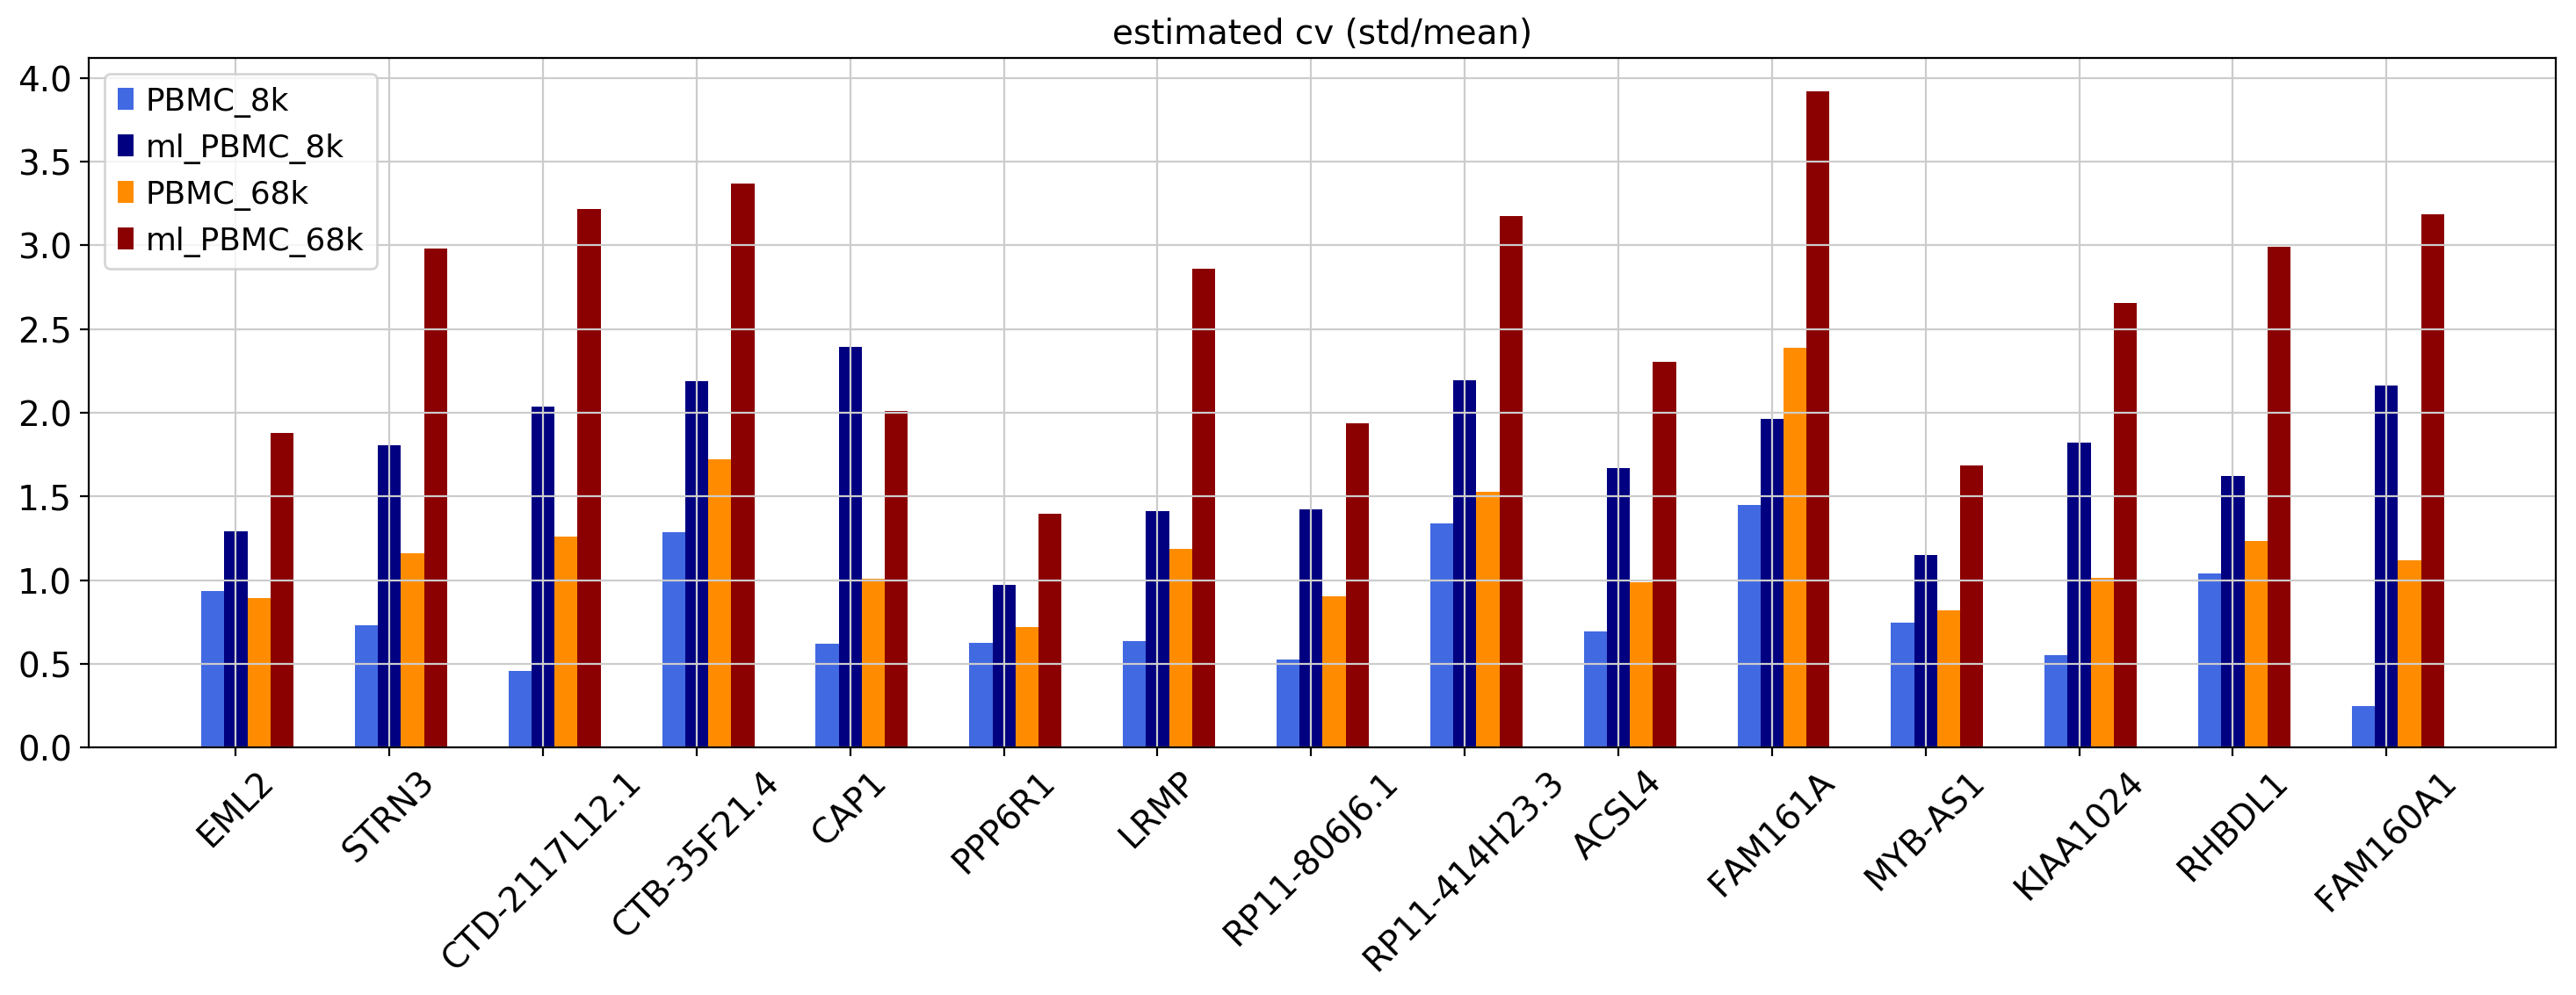

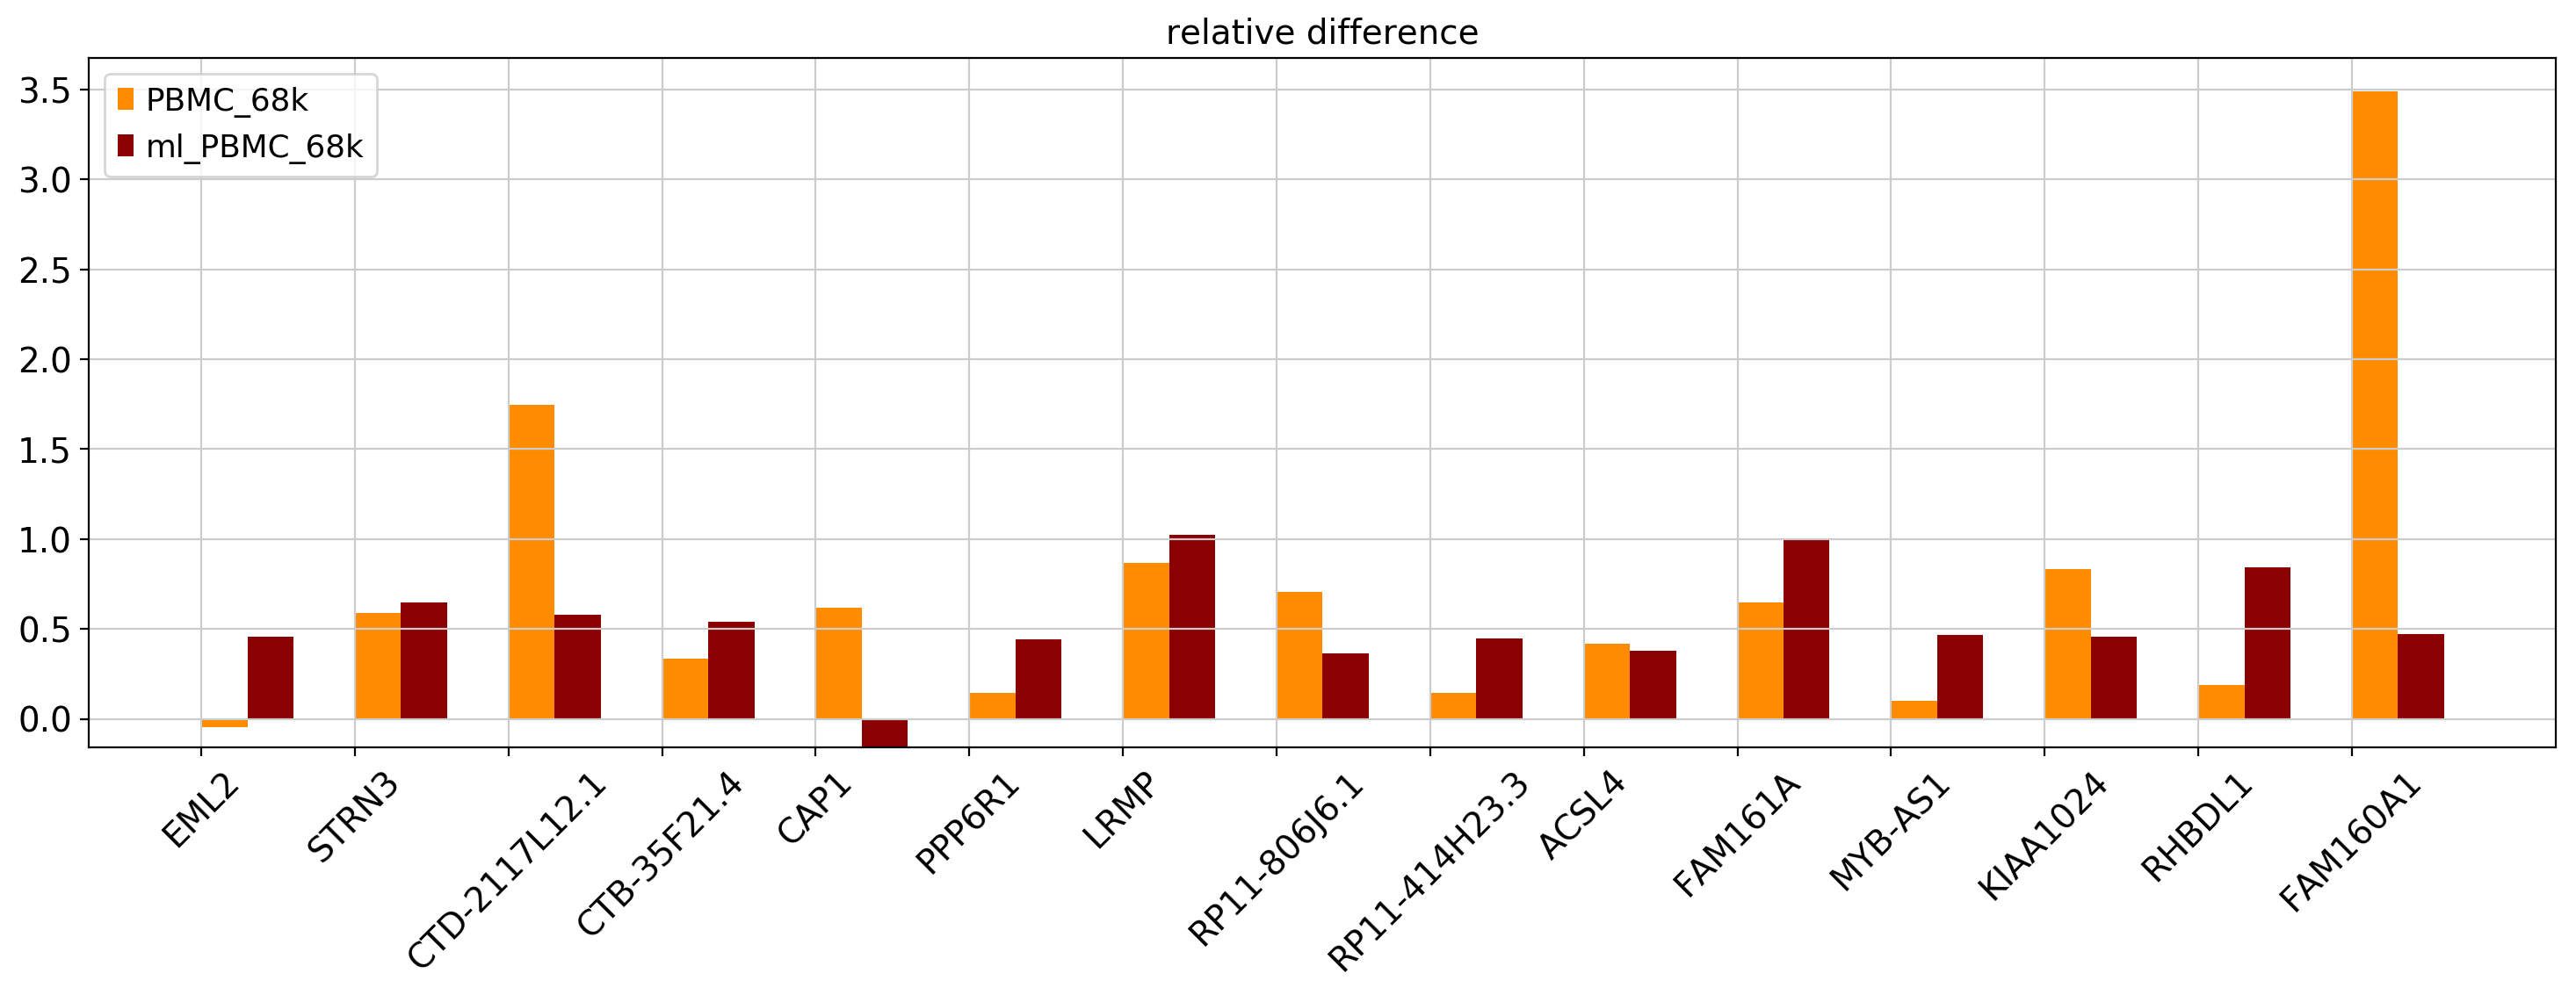

## summary
# average cv_68k:1.1958
# average cv_68k/cv_ml_68k:0.4542
# average cv_68k/cv_8k:1.7184
# average cv_ml_68k/cv_ml_8k:1.5306
# average relative difference: 0.3623
# average relative ml difference: 0.2759


In [36]:
## random gene, plain 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=None,size_factor=None,sub_samp=False,verbose=True)

## CAP1: 
# PBMC_8k
mean=0.9106, var=0.4696, cv=0.7526, cv_ml=1.0684, B=7632
# PBMC_68k
mean=0.2105, var=0.0854, cv=1.3883, cv_ml=1.9269, B=14438


## PCMT1: 
# PBMC_8k
mean=0.2126, var=0.0428, cv=0.9735, cv_ml=1.8187, B=1782
# PBMC_68k
mean=0.0686, var=0.0237, cv=2.2419, cv_ml=3.1540, B=4706


## SCAMP2: 
# PBMC_8k
mean=0.1423, var=0.0213, cv=1.0243, cv_ml=2.1390, B=1193
# PBMC_68k
mean=0.0613, var=0.0235, cv=2.5035, cv_ml=3.4241, B=4203


## GBP2: 
# PBMC_8k
mean=0.2083, var=0.1079, cv=1.5767, cv_ml=2.1628, B=1745
# PBMC_68k
mean=0.0659, var=0.0312, cv=2.6816, cv_ml=3.4936, B=4518


## POLD4: 
# PBMC_8k
mean=0.1142, var=0.0337, cv=1.6085, cv_ml=2.5947, B=956
# PBMC_68k
mean=0.1979, var=0.1133, cv=1.7009, cv_ml=2.1021, B=13569


## CD48: 
# PBMC_8k
mean=1.4063, var=0.5233, cv=0.5144, cv_ml=0.8446, B=11786
# PBMC_68k
mean=0.4500, var=0.2243, cv=1.0523, cv_ml=1.4109, B=30862


## XRCC5: 
# PBMC_8k
mean=0.4119, var=0.1055, cv=0.7886, cv_ml=1.3840, B=3452
# PBMC_68k
mean=0.0780, var=0.030

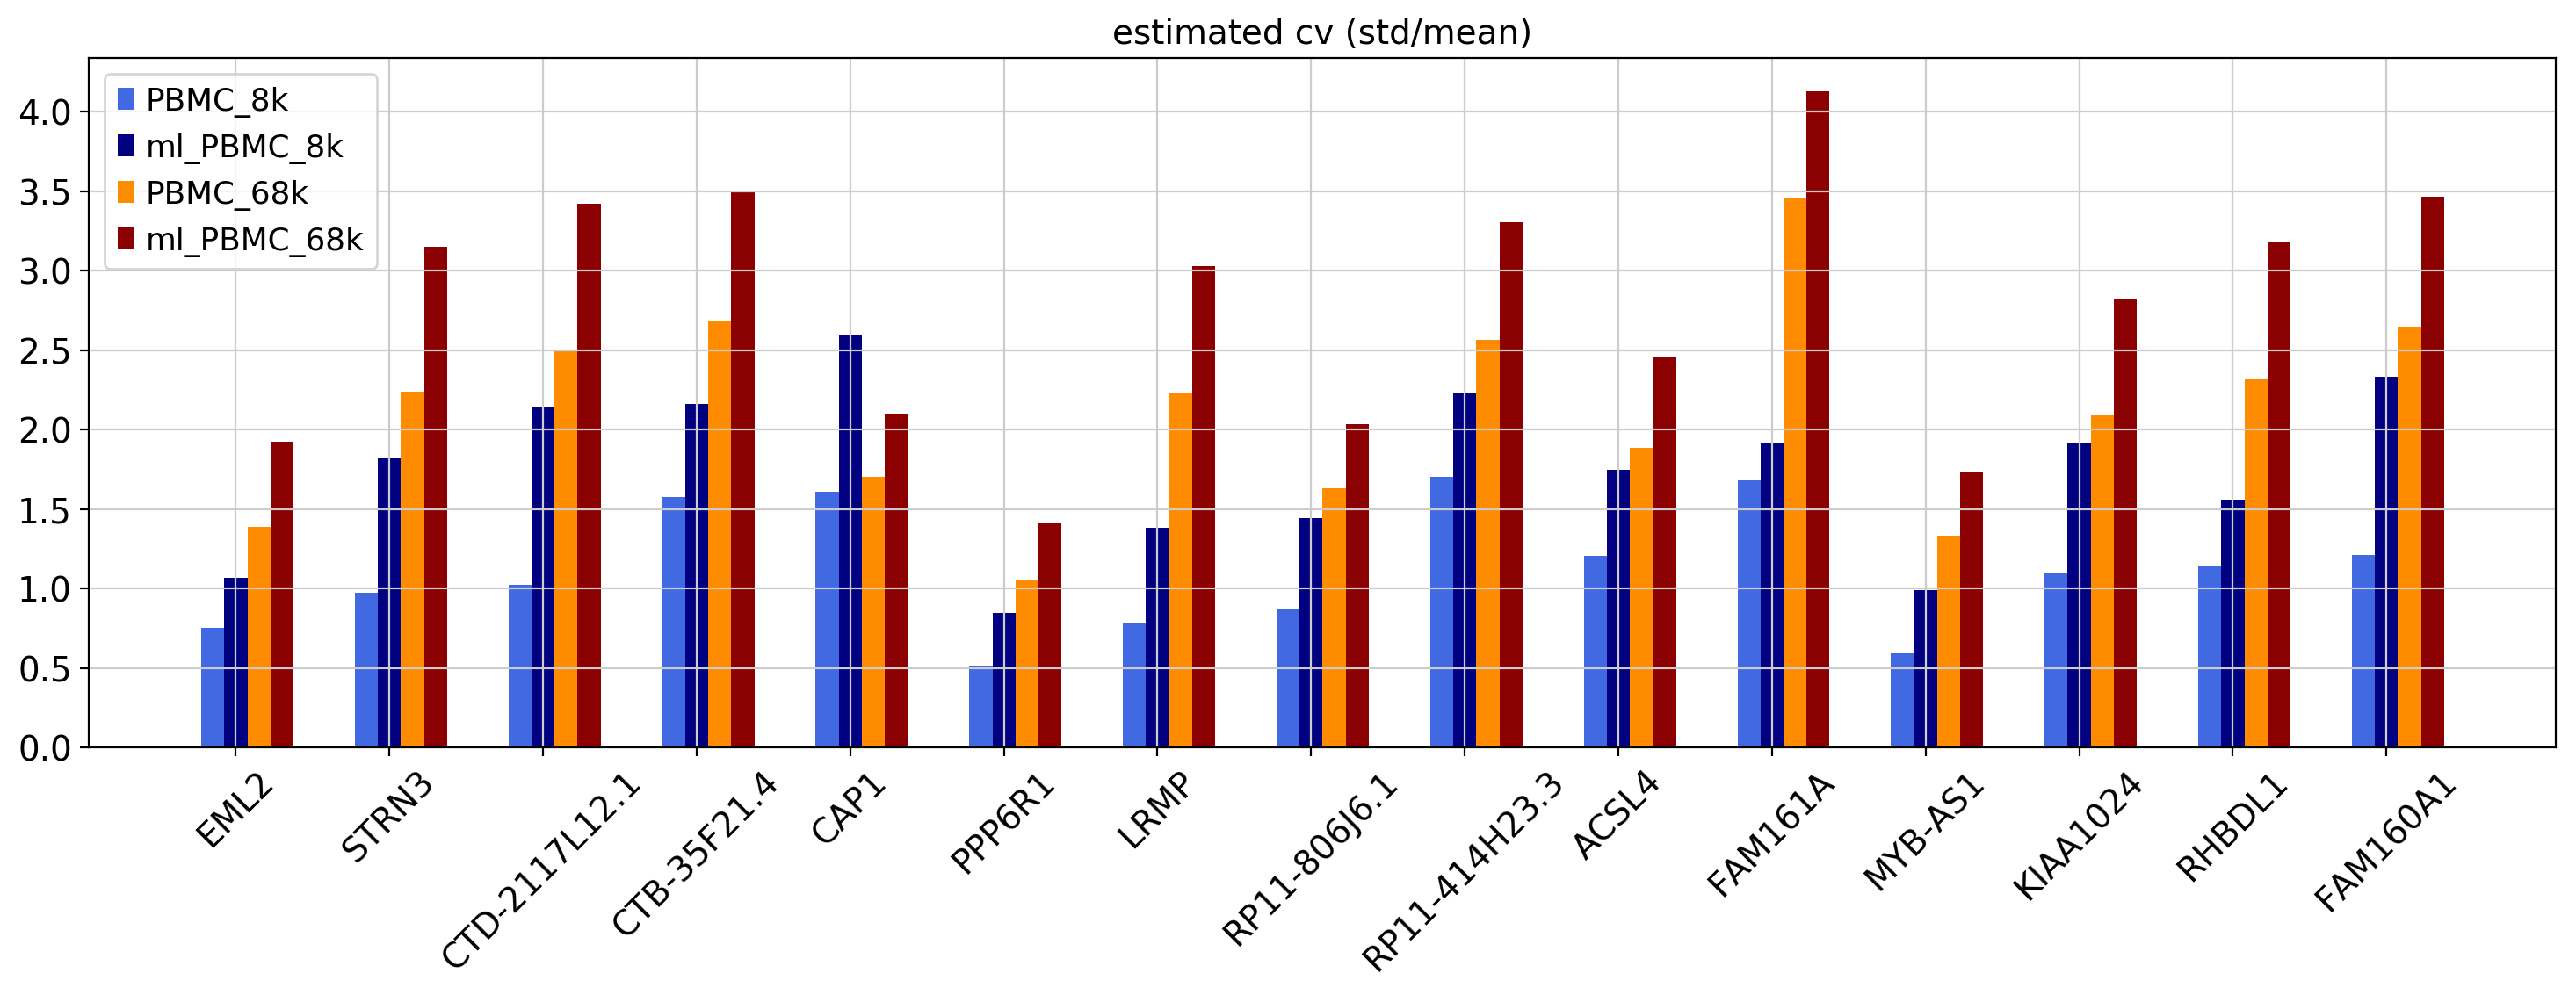

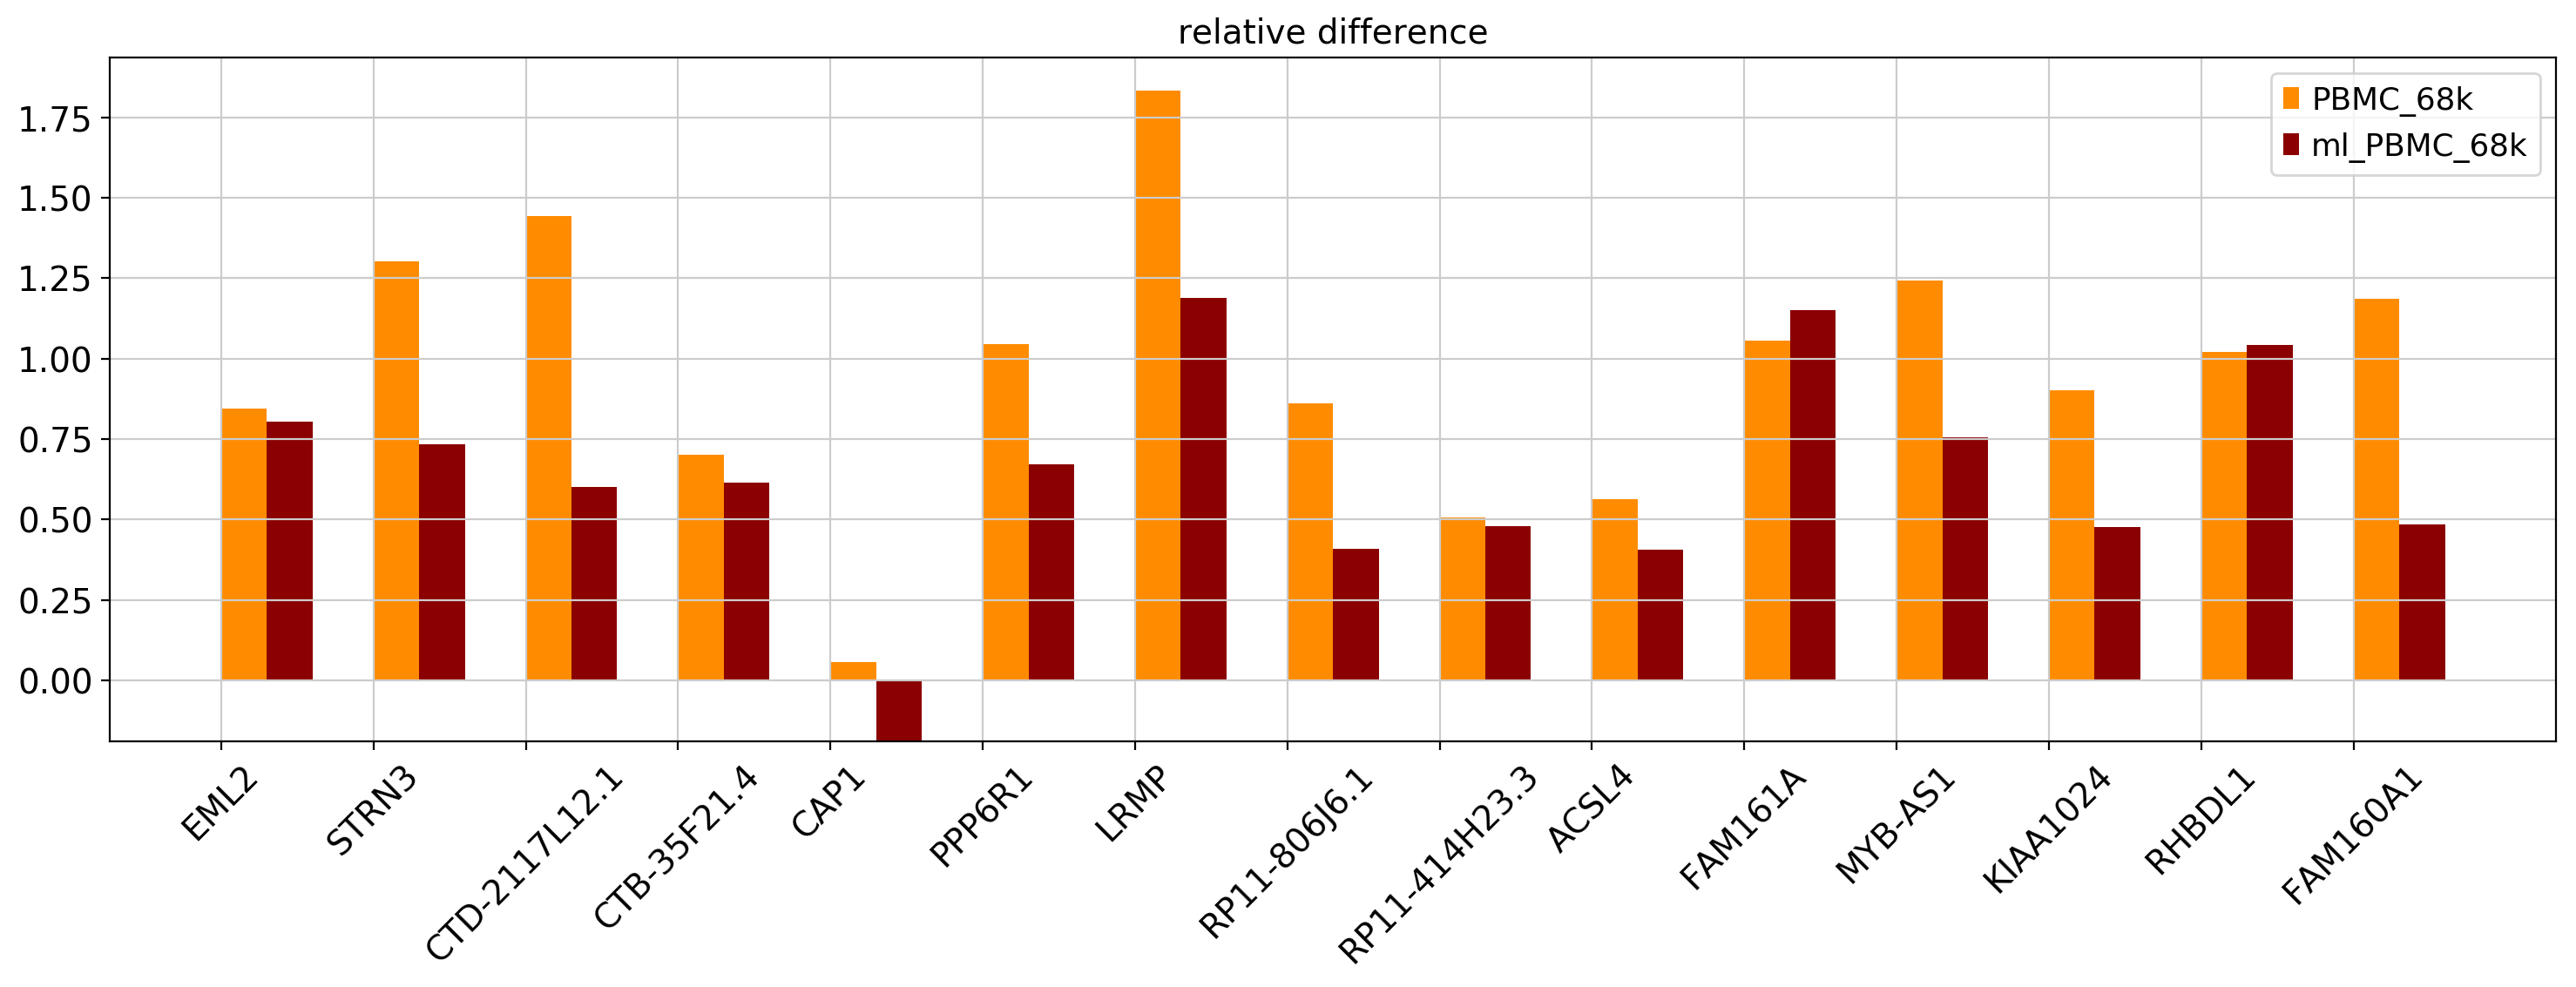

## summary
# average cv_68k:2.1156
# average cv_68k/cv_ml_68k:0.7602
# average cv_68k/cv_8k:1.9713
# average cv_ml_68k/cv_ml_8k:1.6419
# average relative difference: 0.4857
# average relative ml difference: 0.3336


In [37]:
## random gene, sf
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=None,size_factor=sf,sub_samp=False,verbose=True)

## CAP1: 
# PBMC_8k
mean=1.2714, var=1.4169, cv=0.9362, cv_ml=1.2896, B=10656
# PBMC_68k
mean=0.1554, var=0.0194, cv=0.8970, cv_ml=2.6908, B=10656


## PCMT1: 
# PBMC_8k
mean=0.3656, var=0.0713, cv=0.7306, cv_ml=1.8080, B=3064
# PBMC_68k
mean=0.0447, var=0.0031, cv=1.2535, cv_ml=4.8942, B=3063


## SCAMP2: 
# PBMC_8k
mean=0.2535, var=0.0135, cv=0.4584, cv_ml=2.0382, B=2124
# PBMC_68k
mean=0.0310, var=0.0021, cv=1.4796, cv_ml=5.8704, B=2125


## GBP2: 
# PBMC_8k
mean=0.3192, var=0.1692, cv=1.2888, cv_ml=2.1896, B=2675
# PBMC_68k
mean=0.0390, var=0.0040, cv=1.6136, cv_ml=5.3142, B=2675


## POLD4: 
# PBMC_8k
mean=0.1873, var=0.0136, cv=0.6223, cv_ml=2.3928, B=1570
# PBMC_68k
mean=0.0229, var=0.0007, cv=1.1320, cv_ml=6.7054, B=1570


## CD48: 
# PBMC_8k
mean=1.8225, var=1.3053, cv=0.6269, cv_ml=0.9704, B=15274
# PBMC_68k
mean=0.2227, var=0.0264, cv=0.7295, cv_ml=2.2410, B=15273


## XRCC5: 
# PBMC_8k
mean=0.6270, var=0.1586, cv=0.6351, cv_ml=1.4136, B=5254
# PBMC_68k
mean=0.0766, var=0.00

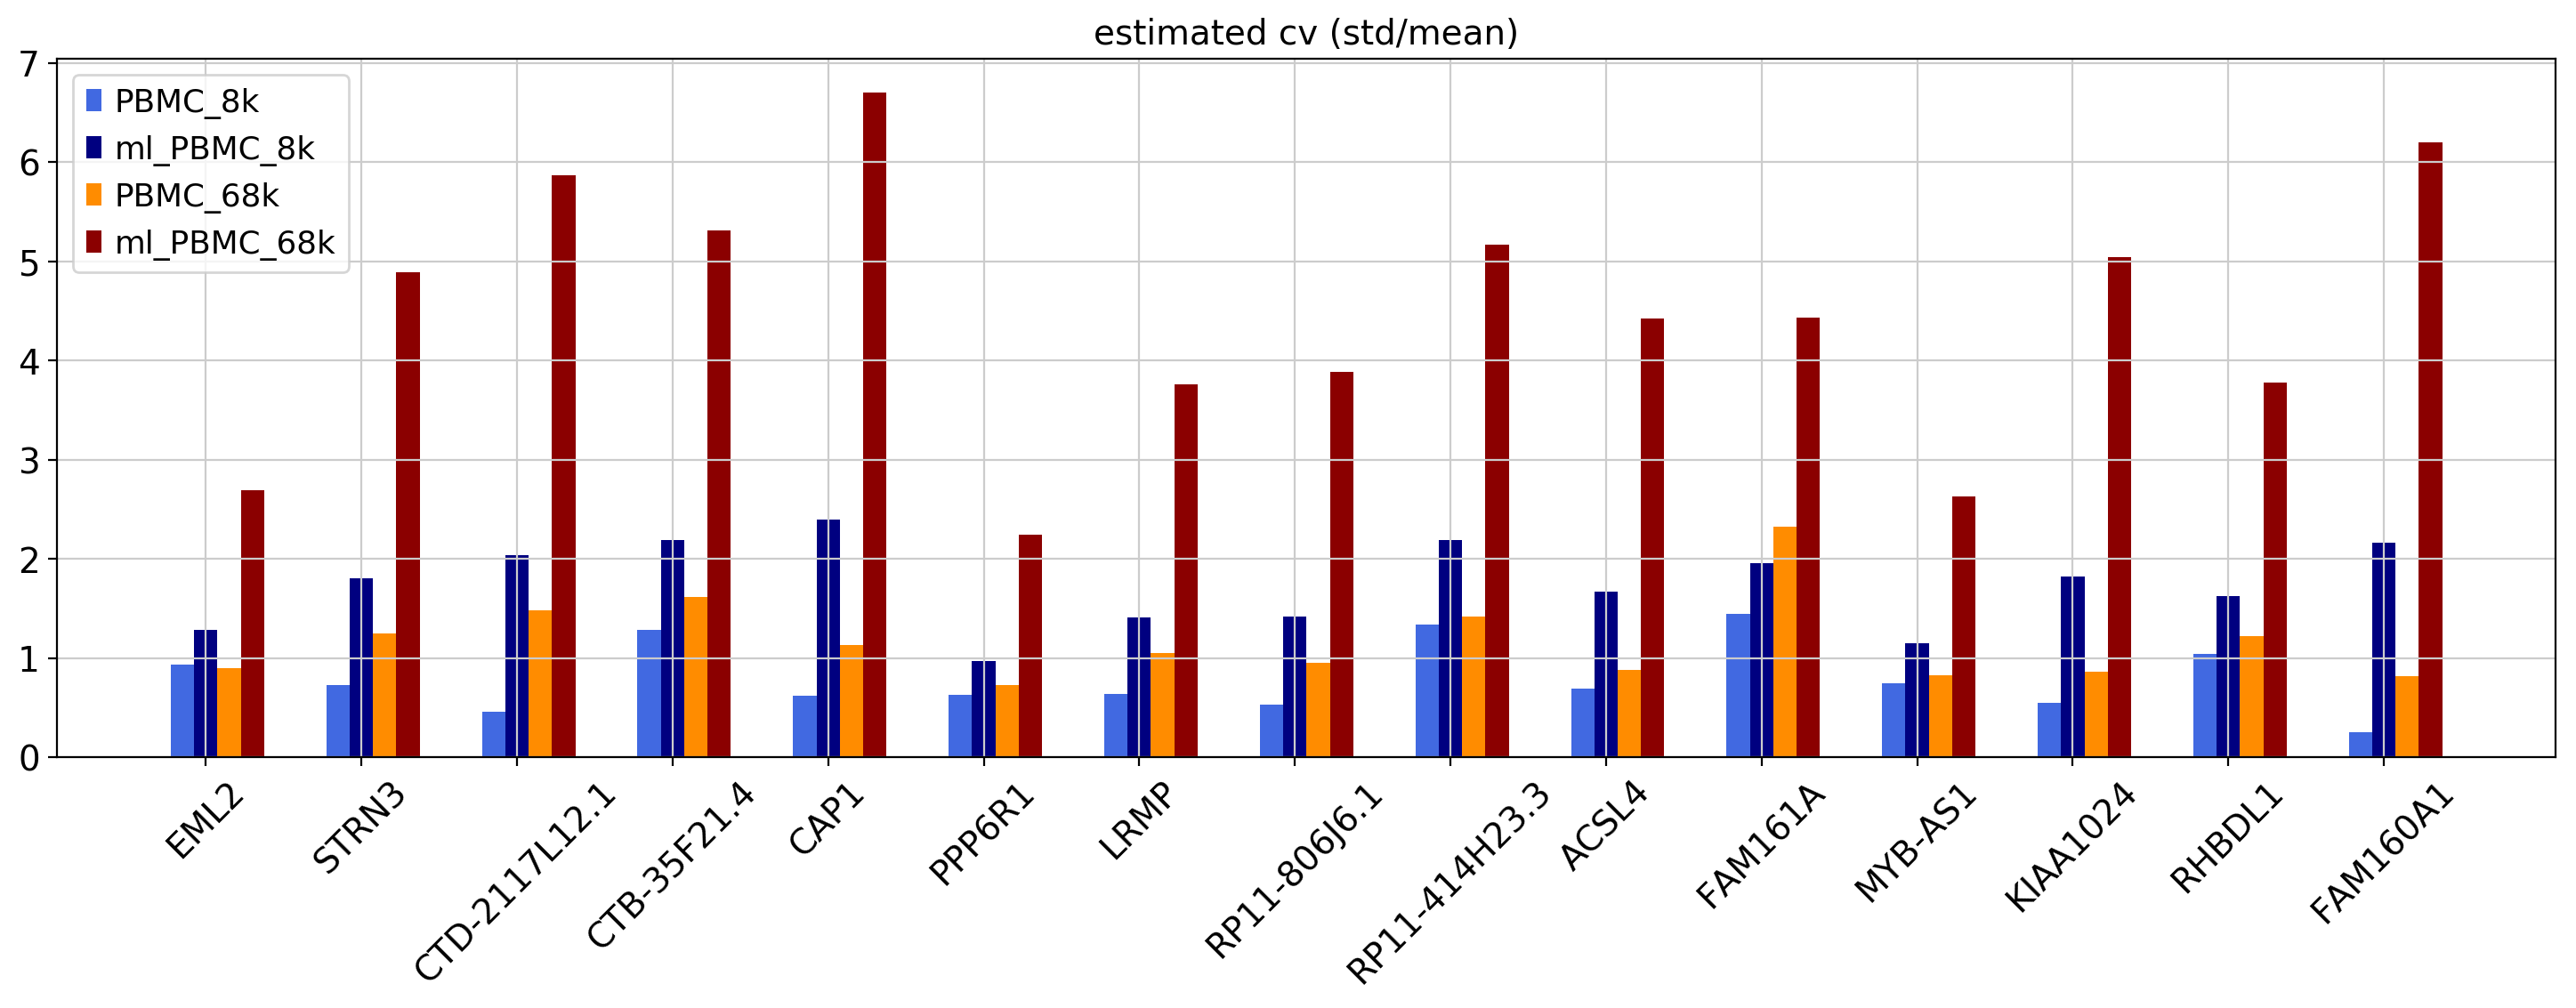

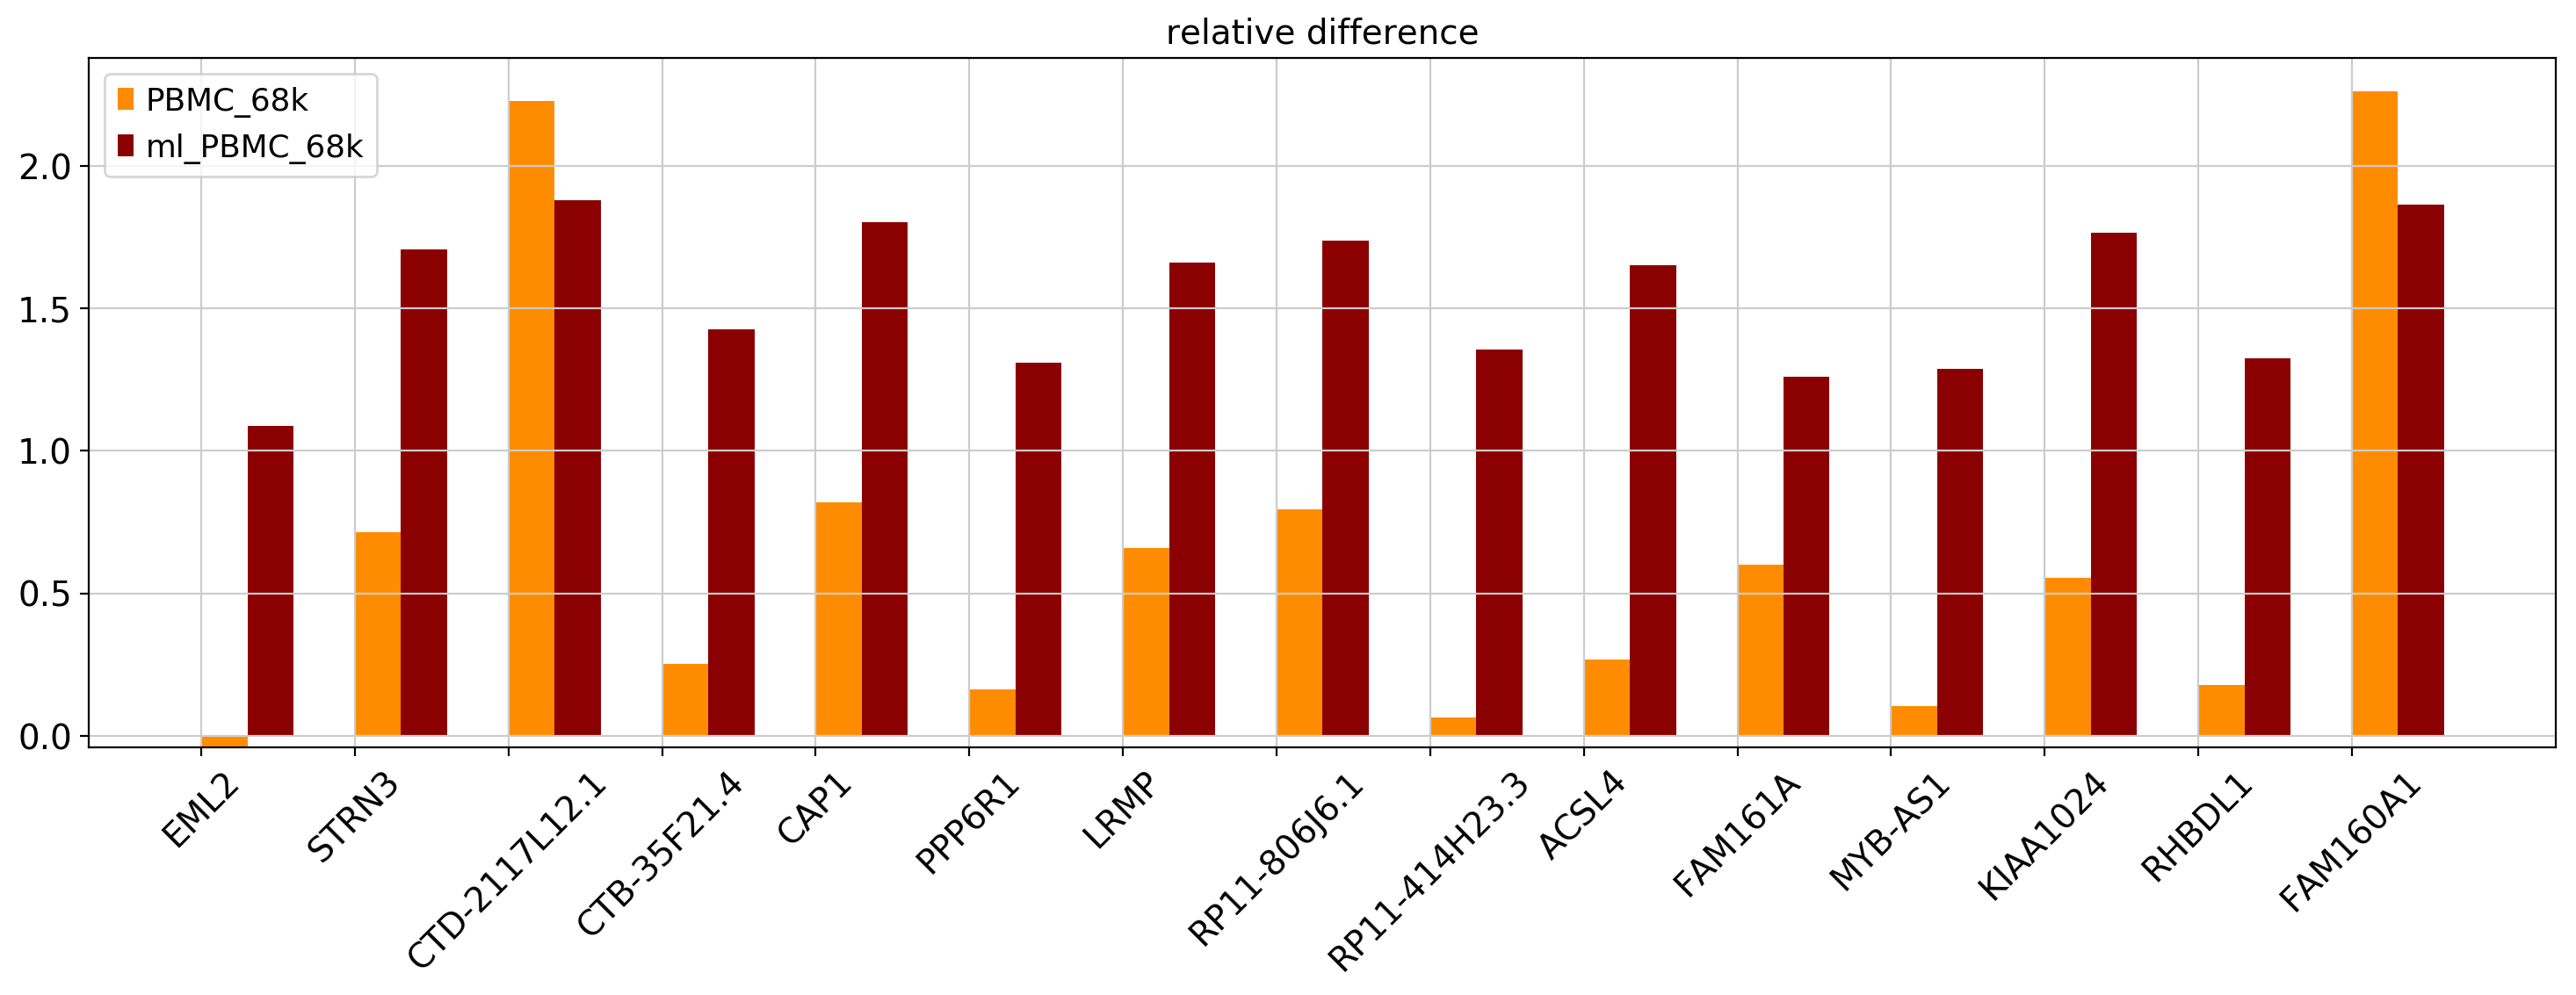

## summary
# average cv_68k:1.1641
# average cv_68k/cv_ml_68k:0.2735
# average cv_68k/cv_8k:1.6418
# average cv_ml_68k/cv_ml_8k:2.5419
# average relative difference: 0.3237
# average relative ml difference: 0.7709


In [38]:
## random gene, subsamp 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=None,size_factor=None,sub_samp=True,verbose=True)

## CAP1: 
# PBMC_8k
mean=0.9106, var=0.4696, cv=0.7526, cv_ml=1.0684, B=7632
# PBMC_68k
mean=0.0787, var=0.0179, cv=1.7017, cv_ml=2.8130, B=5396


## PCMT1: 
# PBMC_8k
mean=0.2126, var=0.0428, cv=0.9735, cv_ml=1.8187, B=1782
# PBMC_68k
mean=0.0213, var=0.0057, cv=3.5464, cv_ml=5.2857, B=1460


## SCAMP2: 
# PBMC_8k
mean=0.1423, var=0.0213, cv=1.0243, cv_ml=2.1390, B=1193
# PBMC_68k
mean=0.0154, var=0.0027, cv=3.3763, cv_ml=6.2447, B=1057


## GBP2: 
# PBMC_8k
mean=0.2083, var=0.1079, cv=1.5767, cv_ml=2.1628, B=1745
# PBMC_68k
mean=0.0191, var=0.0051, cv=3.7314, cv_ml=5.7078, B=1310


## POLD4: 
# PBMC_8k
mean=0.1142, var=0.0337, cv=1.6085, cv_ml=2.5947, B=956
# PBMC_68k
mean=0.0106, var=0.0013, cv=3.3847, cv_ml=7.1306, B=727


## CD48: 
# PBMC_8k
mean=1.4063, var=0.5233, cv=0.5144, cv_ml=0.8446, B=11786
# PBMC_68k
mean=0.1173, var=0.0279, cv=1.4239, cv_ml=2.3269, B=8046


## XRCC5: 
# PBMC_8k
mean=0.4119, var=0.1055, cv=0.7886, cv_ml=1.3840, B=3452
# PBMC_68k
mean=0.0381, var=0.0112, c

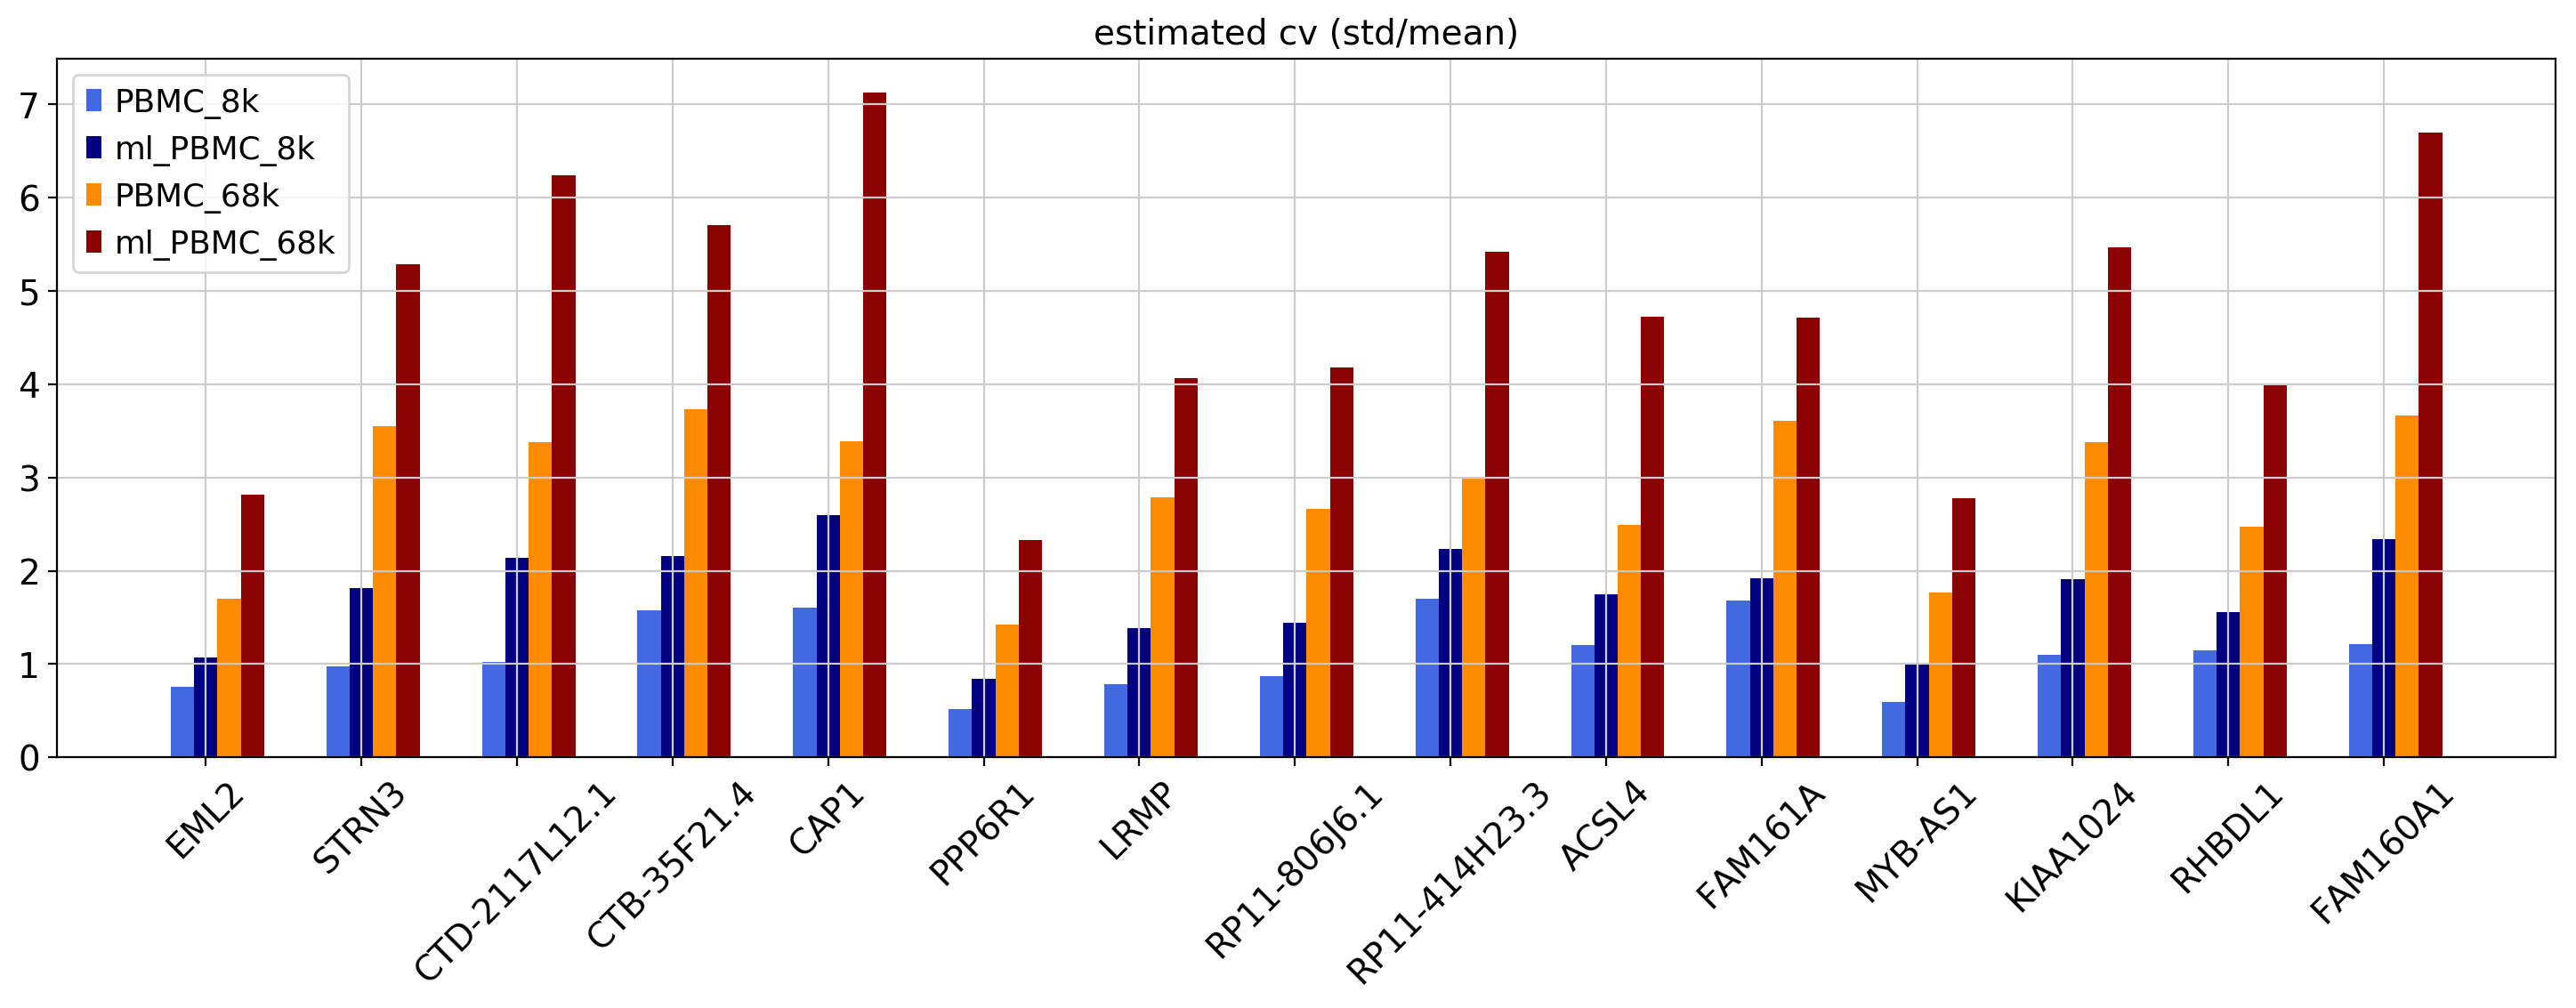

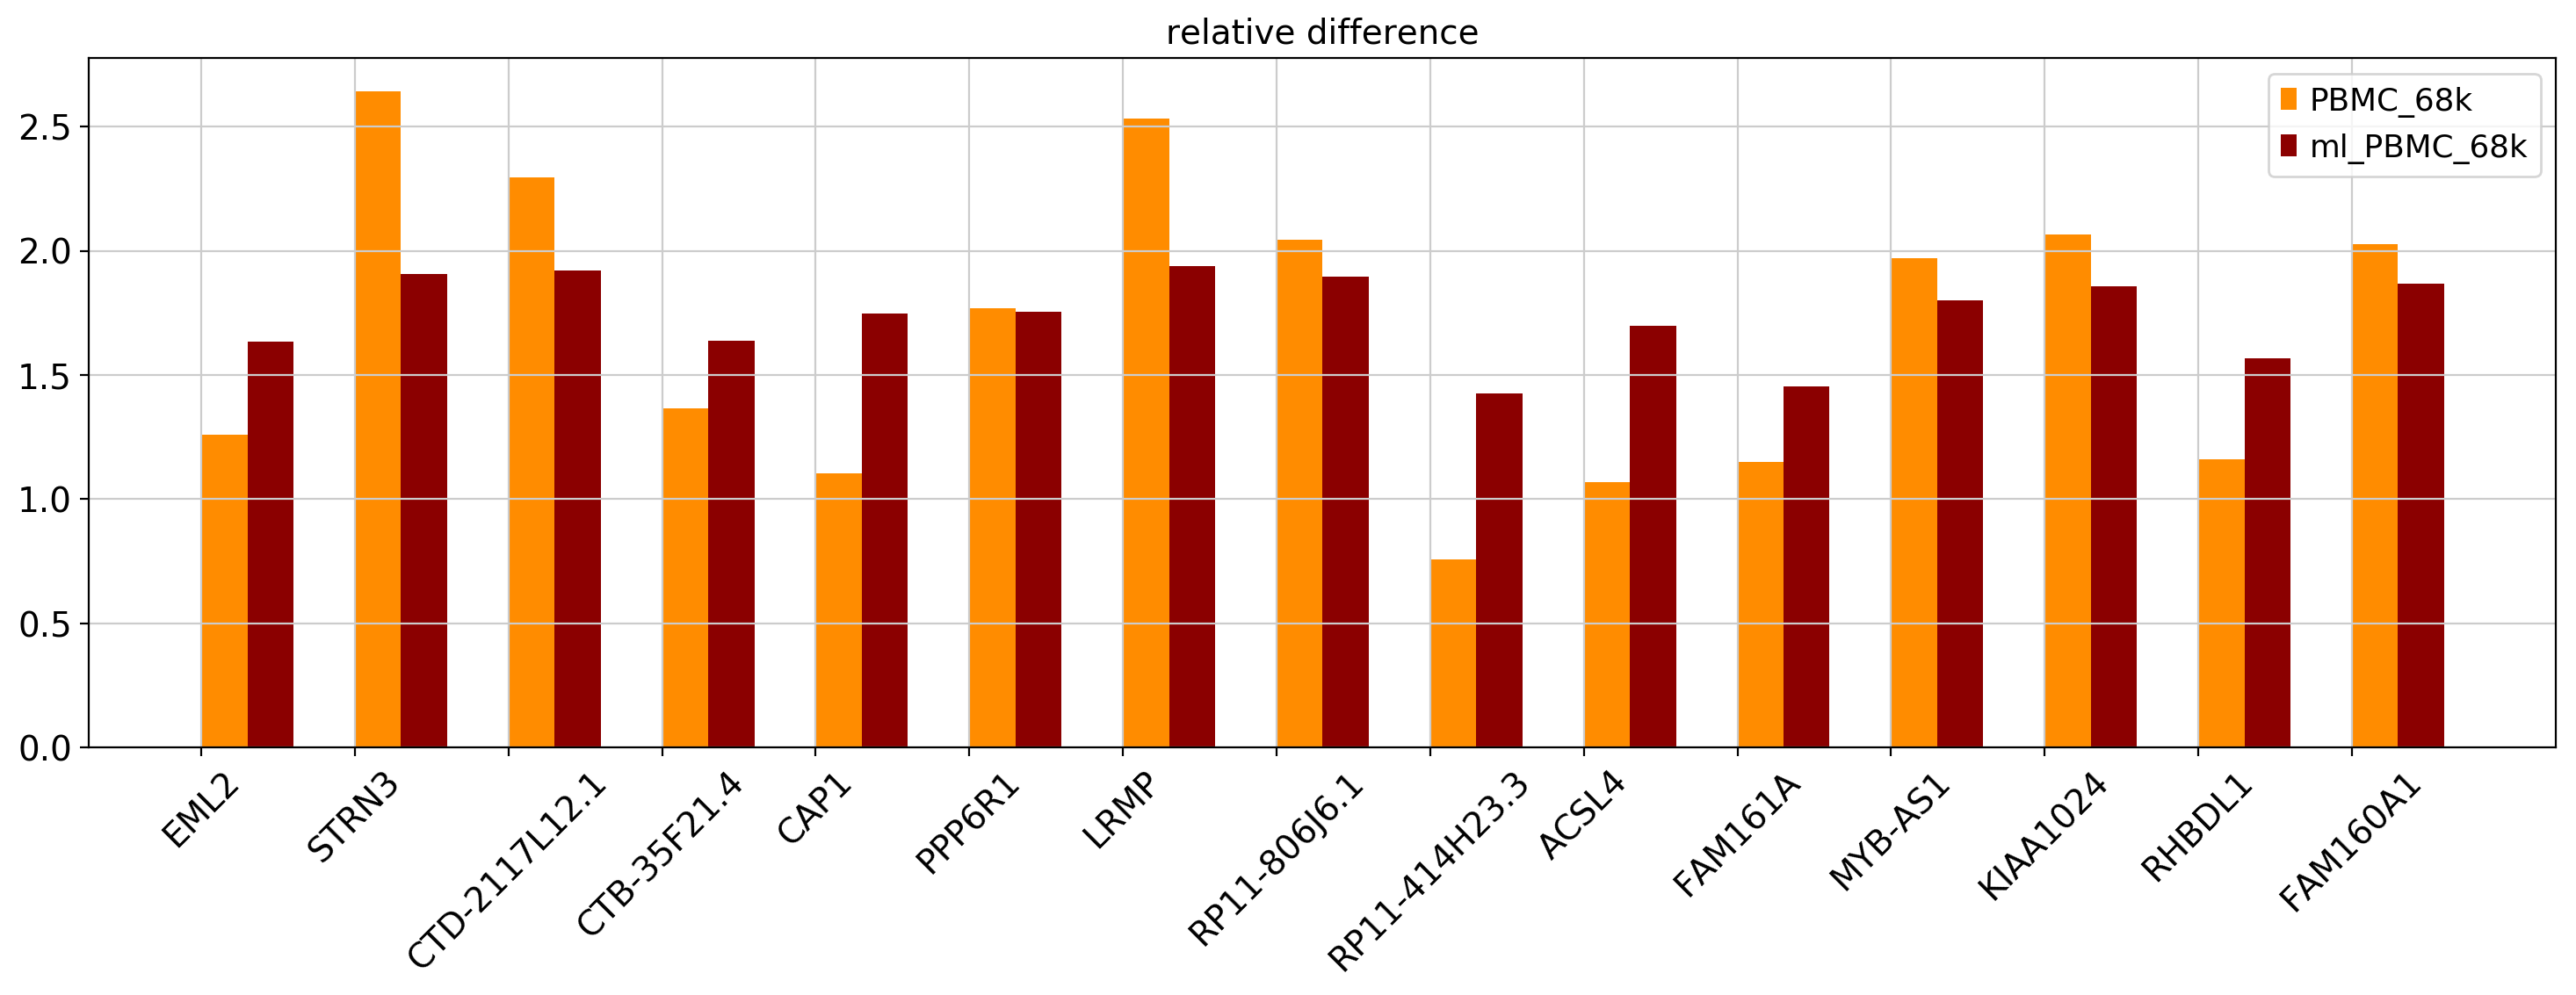

## summary
# average cv_68k:2.8669
# average cv_68k/cv_ml_68k:0.6099
# average cv_68k/cv_8k:2.6811
# average cv_ml_68k/cv_ml_8k:2.7401
# average relative difference: 0.8406
# average relative ml difference: 0.8701


In [39]:
## random gene, both 
gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
       "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=None,size_factor=sf,sub_samp=True,verbose=True)

In [69]:
temp = sc.pp.filter_genes(data_68k,min_counts=0.01*data_68k.shape[0],copy=True)

In [74]:
temp.var_names[[2,1,4]]

Index(['ISG15', 'HES4', 'TNFRSF4'], dtype='object')

MALAT1    2763301.0
RPL13     1640134.0
RPS2      1562425.0
B2M       1519308.0
RPL10     1399585.0
RPL13A    1310894.0
TMSB4X    1282330.0
RPS6      1157146.0
RPL3      1072442.0
RPS4X     1018890.0
RPS3       974927.0
RPS18      933339.0
RPS14      831451.0
RPL19      789759.0
RPL11      778170.0
Name: n_counts, dtype: float32


MALAT1    2763301.0
RPL13     1640134.0
RPS2      1562425.0
B2M       1519308.0
RPL10     1399585.0
RPL13A    1310894.0
TMSB4X    1282330.0
RPS6      1157146.0
RPL3      1072442.0
RPS4X     1018890.0
RPS3       974927.0
RPS18      933339.0
RPS14      831451.0
RPL19      789759.0
RPL11      778170.0
Name: n_counts, dtype: float32
## MALAT1: 
# PBMC_8k
mean=223.5848, var=10139.2246, cv=0.4504, cv_ml=0.4553, B=1873863
# PBMC_68k
mean=40.2937, var=170.2732, cv=0.3238, cv_ml=0.3601, B=2763301


## RPL13: 
# PBMC_8k
mean=43.2320, var=520.8746, cv=0.5279, cv_ml=0.5494, B=362326
# PBMC_68k
mean=23.9160, var=95.0620, cv=0.4077, cv_ml=0.4561, B=1640134


## RPS2: 
# PBMC_8k
mean=33.8738, var=463.6519, cv=0.6357, cv_ml=0.6585, B=283896
# PBMC_68k
mean=22.7828, var=96.5924, cv=0.4314, cv_ml=0.4796, B=1562425


## B2M: 
# PBMC_8k
mean=64.6905, var=1033.9449, cv=0.4971, cv_ml=0.5124, B=542170
# PBMC_68k
mean=22.1541, var=80.6144, cv=0.4053, cv_ml=0.4576, B=1519307


## RPL10: 
# PBMC_8k
mean=46.6280

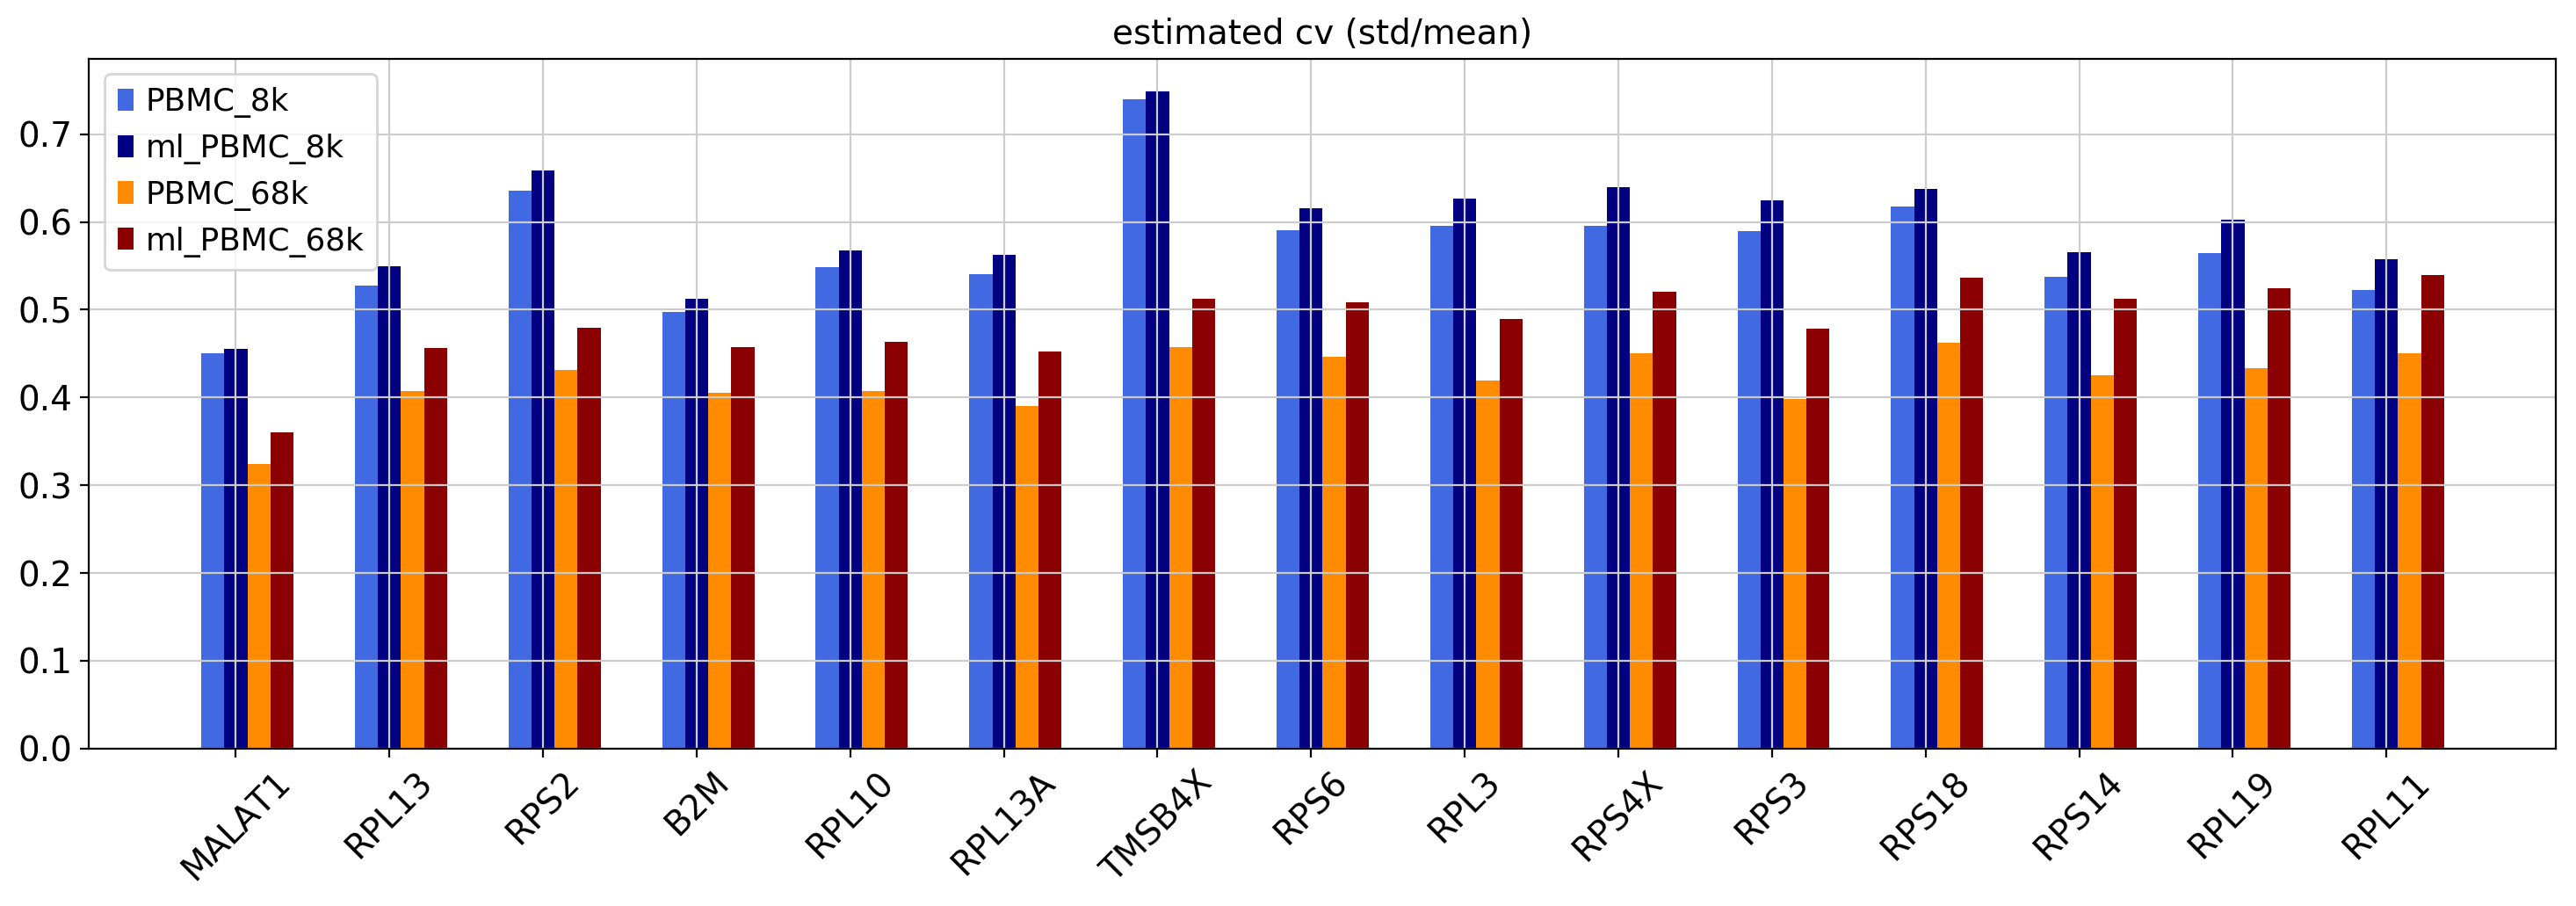

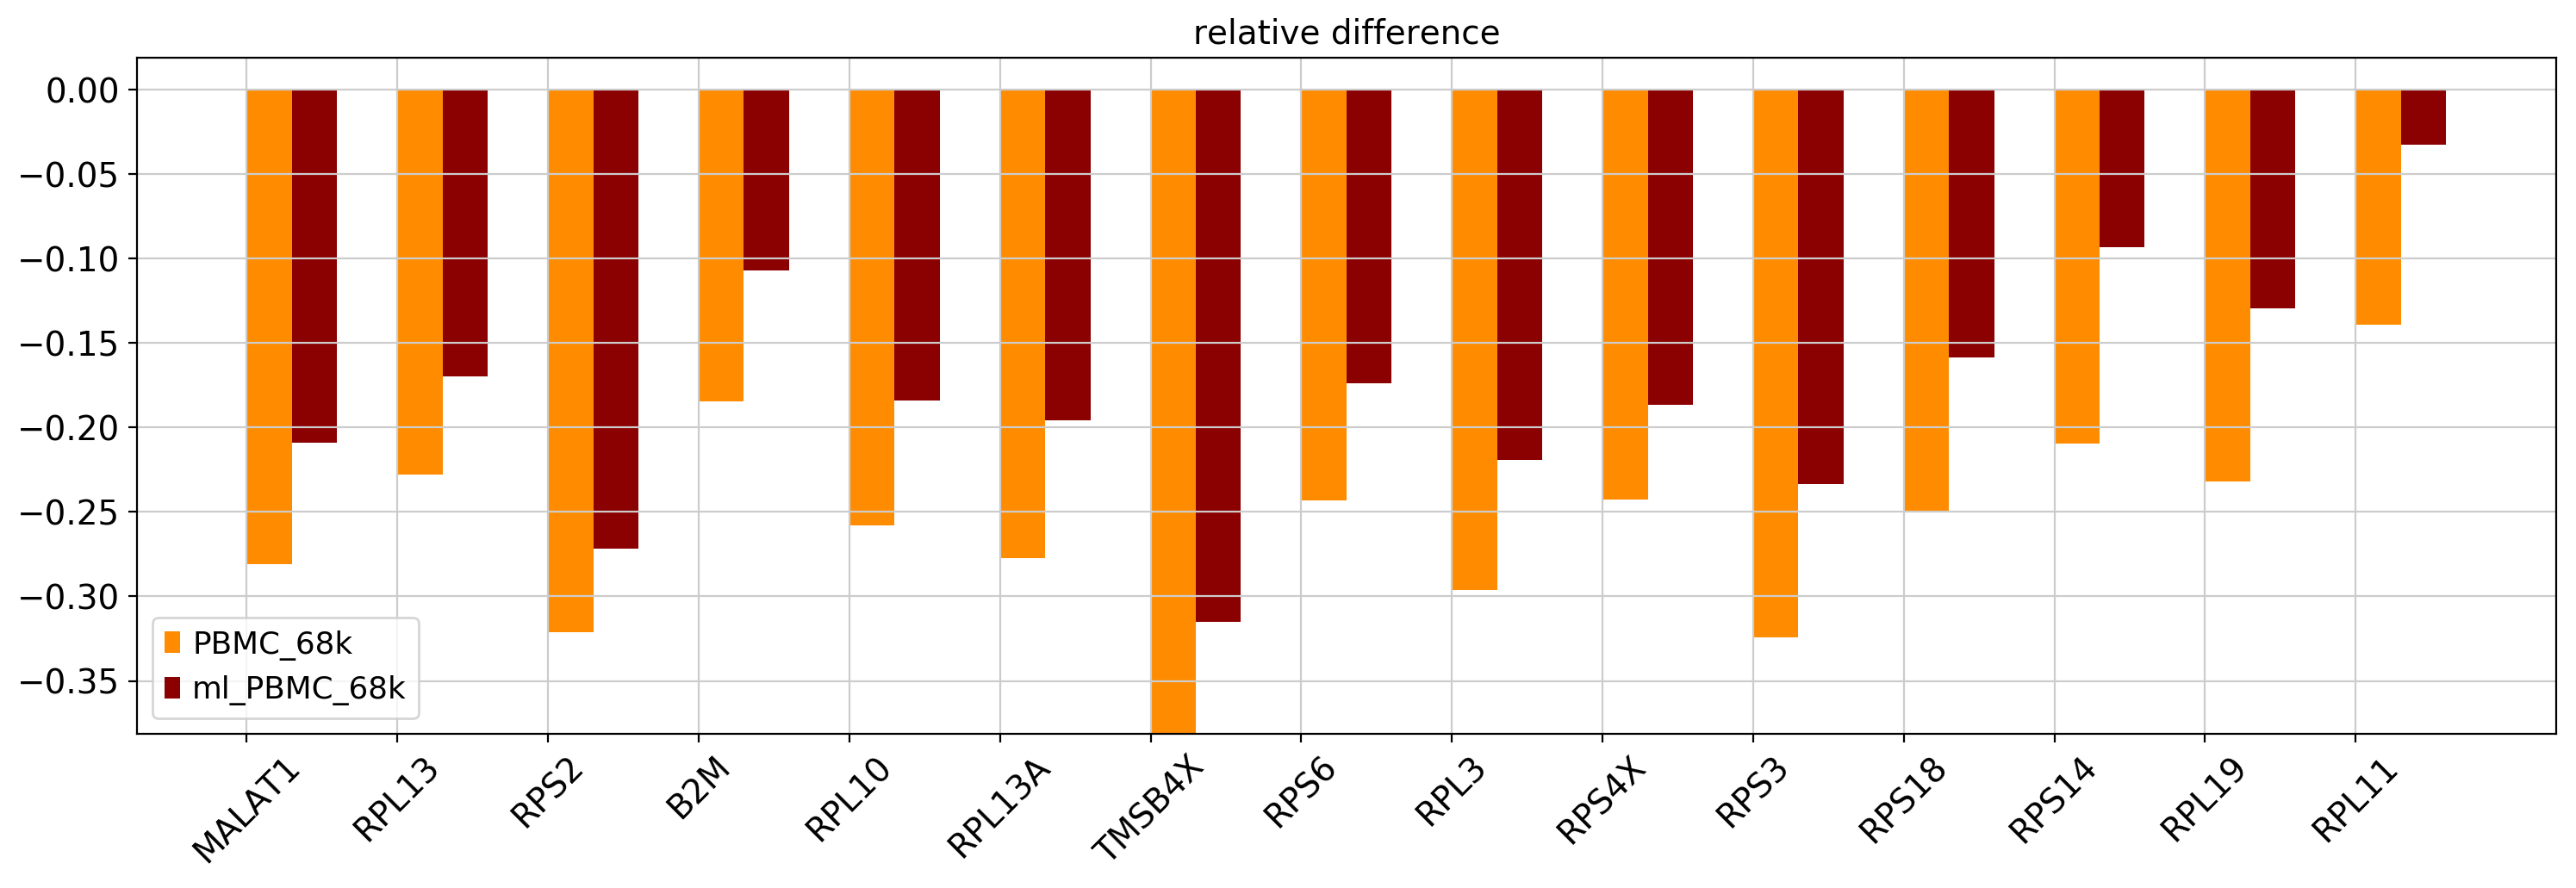

## summary
# average cv_68k:0.4206
# average cv_68k/cv_ml_68k:0.8666
# average cv_68k/cv_8k:0.7421
# average cv_ml_68k/cv_ml_8k:0.8213
# average relative difference: 0.1290
# average relative ml difference: 0.0894


In [84]:
## random gene, high expression in 68k
# gene_list=["FTL","S100A9","S100A8","S100A4","LGALS2","FCN1","CD14","GZMB","IGFBP7","CD79A","CD3E","LYZ","MS4A1",
#        "GNLY","FGFBP2","FCER1G","LDHB","IL7R","LST1","PF4","NKG7","CST3","CCR7"]
temp = sc.pp.filter_genes(data_68k,min_counts=0.01*data_68k.shape[0],copy=True)
sort_idx = temp.var['n_counts'].argsort()[::-1]
gene_list = list(temp.var_names[sort_idx[0:15]])
print(temp.var['n_counts'][gene_list])
data_list=[data_8k,data_68k]
data_name_list=['PBMC_8k','PBMC_68k']
sf = [sf_8k,sf_68k]
compare_moments_across_data(data_list,data_name_list,gene_list=gene_list,size_factor=None,sub_samp=False,verbose=True)